# Authorship
1. Clarine Tan Kaili (20194533)
2. Carolyn Han En Qi (20204040)

Thie file is compiled and edited by Clarine.

***IMPORTANT***<br>
Please download the dataset from https://www.drivendata.org/competitions/66/flu-shot-learning/page/210/<br>
Place the downloaded the dataset in the same folder as this python notebook and rename them as below:<br>
1. *Training Features:* training_features.csv
2. *Training Labels:* training_labels.csv

### Install and import libraries

In [1]:
# Install required libraries
%pip install catboost


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, roc_auc_score, roc_curve, auc

from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN

from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

## Data Analysis (1)
This section is written by Clarine and Carolyn with the references mentioned below.<br>

_References_ <br>
[1]<br>
Title: Lab 2 - Wrangling and preprocessing data<br>
Author: Johann Benerradi, Jeremie Clos<br>
Availability: https://moodle.nottingham.ac.uk/mod/resource/view.php?id=6562915<br>

[2]<br>
Title: Lab 3 - Visualisation with Matplotlib and Seaborn<br>
Author: Johann Benerradi, Jeremie Clos<br>
Availability:https://moodle.nottingham.ac.uk/mod/resource/view.php?id=6575328<br>

[3]<br>
Title: Lab 4 - Data Analysis and Modelling<br>
Author: Nazia Hameed, Jeremie Clos<br>
Availability: https://moodle.nottingham.ac.uk/mod/resource/view.php?id=6590728<br>

[4]<br>
Title: Lab 5 - Clustering Solutions<br>
Availability: https://moodle.nottingham.ac.uk/mod/resource/view.php?id=6597344

In [3]:
# Load data set
df_x = pd.read_csv('training_features.csv', index_col='respondent_id')
df_y = pd.read_csv('training_labels.csv', index_col='respondent_id')

In [4]:
# Visualise the first 5 rows
df_x.head()

h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds   
respondent_id                                                            
0                       1.0             0.0                        0.0  \
1                       3.0             2.0                        0.0   
2                       1.0             1.0                        0.0   
3                       1.0             1.0                        0.0   
4                       2.0             1.0                        0.0   

               behavioral_avoidance  behavioral_face_mask   
respondent_id                                               
0                               0.0                   0.0  \
1                               1.0                   0.0   
2                               1.0                   0.0   
3                               1.0                   0.0   
4                               1.0                   0.0   

               behavioral_wash_hands  behavioral_large_gatherings   
respondent_id                                                       
0                                0.0                          0.0  \
1                                1.0                          0.0   
2                                0.0                          0.0   
3                                1.0                          1.0   
4                                1.0                          1.0   

               behavioral_outside_home  behavioral_touch_face   
respondent_id                                                   
0                                  1.0                    1.0  \
1                                  1.0                    1.0   
2                                  0.0                    0.0   
3                                  0.0                    0.0   
4                                  0.0                    1.0   

               doctor_recc_h1n1  ...             income_poverty   
respondent_id                    ...                              
0                           0.0  ...              Below Poverty  \
1                           0.0  ...              Below Poverty   
2                           NaN  ...  <= $75,000, Above Poverty   
3                           0.0  ...              Below Poverty   
4                           0.0  ...  <= $75,000, Above Poverty   

               marital_status  rent_or_own   employment_status   
respondent_id                                                    
0                 Not Married          Own  Not in Labor Force  \
1                 Not Married         Rent            Employed   
2                 Not Married          Own            Employed   
3                 Not Married         Rent  Not in Labor Force   
4                     Married          Own            Employed   

               hhs_geo_region                census_msa  household_adults   
respondent_id                                                               
0                    oxchjgsf                   Non-MSA               0.0  \
1                    bhuqouqj  MSA, Not Principle  City               0.0   
2                    qufhixun  MSA, Not Principle  City               2.0   
3                    lrircsnp       MSA, Principle City               0.0   
4                    qufhixun  MSA, Not Principle  City               1.0   

               household_children  employment_industry  employment_occupation  
respondent_id                                                                  
0                             0.0                  NaN                    NaN  
1                             0.0             pxcmvdjn               xgwztkwe  
2                             0.0             rucpziij               xtkaffoo  
3                             0.0                  NaN                    NaN  
4                             0.0             wxleyezf               emcorrxb  

[5 rows x 35 columns]

In [5]:
# Dimensionality of data set
print(df_x.shape)
print(df_y.shape)

(26707, 35)
(26707, 2)


In [6]:
# Data set summary
df_x.info()
print()
df_y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker        

In [7]:
# Descriptive statistics of data set features
df_x.describe()

h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds   
count  26615.000000    26591.000000               26636.000000  \
mean       1.618486        1.262532                   0.048844   
std        0.910311        0.618149                   0.215545   
min        0.000000        0.000000                   0.000000   
25%        1.000000        1.000000                   0.000000   
50%        2.000000        1.000000                   0.000000   
75%        2.000000        2.000000                   0.000000   
max        3.000000        2.000000                   1.000000   

       behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands   
count          26499.000000          26688.000000           26665.000000  \
mean               0.725612              0.068982               0.825614   
std                0.446214              0.253429               0.379448   
min                0.000000              0.000000               0.000000   
25%                0.000000              0.000000               1.000000   
50%                1.000000              0.000000               1.000000   
75%                1.000000              0.000000               1.000000   
max                1.000000              1.000000               1.000000   

       behavioral_large_gatherings  behavioral_outside_home   
count                  26620.00000             26625.000000  \
mean                       0.35864                 0.337315   
std                        0.47961                 0.472802   
min                        0.00000                 0.000000   
25%                        0.00000                 0.000000   
50%                        0.00000                 0.000000   
75%                        1.00000                 1.000000   
max                        1.00000                 1.000000   

       behavioral_touch_face  doctor_recc_h1n1  ...  health_worker   
count           26579.000000      24547.000000  ...   25903.000000  \
mean                0.677264          0.220312  ...       0.111918   
std                 0.467531          0.414466  ...       0.315271   
min                 0.000000          0.000000  ...       0.000000   
25%                 0.000000          0.000000  ...       0.000000   
50%                 1.000000          0.000000  ...       0.000000   
75%                 1.000000          0.000000  ...       0.000000   
max                 1.000000          1.000000  ...       1.000000   

       health_insurance  opinion_h1n1_vacc_effective  opinion_h1n1_risk   
count       14433.00000                 26316.000000       26319.000000  \
mean            0.87972                     3.850623           2.342566   
std             0.32530                     1.007436           1.285539   
min             0.00000                     1.000000           1.000000   
25%             1.00000                     3.000000           1.000000   
50%             1.00000                     4.000000           2.000000   
75%             1.00000                     5.000000           4.000000   
max             1.00000                     5.000000           5.000000   

       opinion_h1n1_sick_from_vacc  opinion_seas_vacc_effective   
count                 26312.000000                 26245.000000  \
mean                      2.357670                     4.025986   
std                       1.362766                     1.086565   
min                       1.000000                     1.000000   
25%                       1.000000                     4.000000   
50%                       2.000000                     4.000000   
75%                       4.000000                     5.000000   
max                       5.000000                     5.000000   

       opinion_seas_risk  opinion_seas_sick_from_vacc  household_adults   
count       26193.000000                 26170.000000      26458.000000  \
mean            2.719162                     2.118112          0.886499   
std             1.38505

In [8]:
# Descriptive statistics of data set labels
df_y.describe()

h1n1_vaccine  seasonal_vaccine
count  26707.000000      26707.000000
mean       0.212454          0.465608
std        0.409052          0.498825
min        0.000000          0.000000
25%        0.000000          0.000000
50%        0.000000          0.000000
75%        0.000000          1.000000
max        1.000000          1.000000

In [9]:
# Extract features by data type
numerical_features = [col for col in df_x.columns if 'household' in col]
categorical_features = [col for col in df_x.columns if col not in numerical_features]

binary_features = [col for col in df_x.columns if 'behavioral' in col]
other_binary = ['doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months',
                'health_worker', 'health_insurance']
binary_features.extend(other_binary)

ordinal_features = [col for col in df_x.columns if 'opinion' in col]
other_ordinal = ['h1n1_concern', 'h1n1_knowledge']
ordinal_features.extend(other_ordinal)

nominal_features = [col for col in df_x.columns if col not in numerical_features and 
                    col not in binary_features and 
                    col not in ordinal_features]

In [10]:
# Find unique values in nominal features
# To find if there is any bad data
for col in nominal_features:
    print(col)
    print(df_x[col].unique())
    print()

age_group
['55 - 64 Years' '35 - 44 Years' '18 - 34 Years' '65+ Years'
 '45 - 54 Years']

education
['< 12 Years' '12 Years' 'College Graduate' 'Some College' nan]

race
['White' 'Black' 'Other or Multiple' 'Hispanic']

sex
['Female' 'Male']

income_poverty
['Below Poverty' '<= $75,000, Above Poverty' '> $75,000' nan]

marital_status
['Not Married' 'Married' nan]

rent_or_own
['Own' 'Rent' nan]

employment_status
['Not in Labor Force' 'Employed' 'Unemployed' nan]

hhs_geo_region
['oxchjgsf' 'bhuqouqj' 'qufhixun' 'lrircsnp' 'atmpeygn' 'lzgpxyit'
 'fpwskwrf' 'mlyzmhmf' 'dqpwygqj' 'kbazzjca']

census_msa
['Non-MSA' 'MSA, Not Principle  City' 'MSA, Principle City']

employment_industry
[nan 'pxcmvdjn' 'rucpziij' 'wxleyezf' 'saaquncn' 'xicduogh' 'ldnlellj'
 'wlfvacwt' 'nduyfdeo' 'fcxhlnwr' 'vjjrobsf' 'arjwrbjb' 'atmlpfrs'
 'msuufmds' 'xqicxuve' 'phxvnwax' 'dotnnunm' 'mfikgejo' 'cfqqtusy'
 'mcubkhph' 'haxffmxo' 'qnlwzans']

employment_occupation
[nan 'xgwztkwe' 'xtkaffoo' 'emcorrxb' 'vlluhbo

In [11]:
# Find duplicates
df_x[df_x.duplicated(keep=False)]

Empty DataFrame
Columns: [h1n1_concern, h1n1_knowledge, behavioral_antiviral_meds, behavioral_avoidance, behavioral_face_mask, behavioral_wash_hands, behavioral_large_gatherings, behavioral_outside_home, behavioral_touch_face, doctor_recc_h1n1, doctor_recc_seasonal, chronic_med_condition, child_under_6_months, health_worker, health_insurance, opinion_h1n1_vacc_effective, opinion_h1n1_risk, opinion_h1n1_sick_from_vacc, opinion_seas_vacc_effective, opinion_seas_risk, opinion_seas_sick_from_vacc, age_group, education, race, sex, income_poverty, marital_status, rent_or_own, employment_status, hhs_geo_region, census_msa, household_adults, household_children, employment_industry, employment_occupation]
Index: []

[0 rows x 35 columns]

In [12]:
# Find number of missing rows
df_x[df_x.isna().any(axis=1)].shape

(20270, 35)

In [13]:
# Find columns with missing values
missing_data = df_x.notnull()

for col in missing_data.columns.values.tolist():
    print(col)
    print(missing_data[col].value_counts())
    print()

h1n1_concern
h1n1_concern
True     26615
False       92
Name: count, dtype: int64

h1n1_knowledge
h1n1_knowledge
True     26591
False      116
Name: count, dtype: int64

behavioral_antiviral_meds
behavioral_antiviral_meds
True     26636
False       71
Name: count, dtype: int64

behavioral_avoidance
behavioral_avoidance
True     26499
False      208
Name: count, dtype: int64

behavioral_face_mask
behavioral_face_mask
True     26688
False       19
Name: count, dtype: int64

behavioral_wash_hands
behavioral_wash_hands
True     26665
False       42
Name: count, dtype: int64

behavioral_large_gatherings
behavioral_large_gatherings
True     26620
False       87
Name: count, dtype: int64

behavioral_outside_home
behavioral_outside_home
True     26625
False       82
Name: count, dtype: int64

behavioral_touch_face
behavioral_touch_face
True     26579
False      128
Name: count, dtype: int64

doctor_recc_h1n1
doctor_recc_h1n1
True     24547
False     2160
Name: count, dtype: int64

doctor_recc_

In [14]:
# To be sure that all missings are labelled as np.nan
# Find if there exist any row with '?'
df_x.eq('?').any(axis=1).any()

False

In [15]:
# Find number of rows with at least half of its value missing
missing_count_per_row = df_x.isna().sum(axis=1)
percent_missing = missing_count_per_row / df_x.shape[1] * 100
rows_half_missing = percent_missing[percent_missing >= 50]
len(rows_half_missing)

206

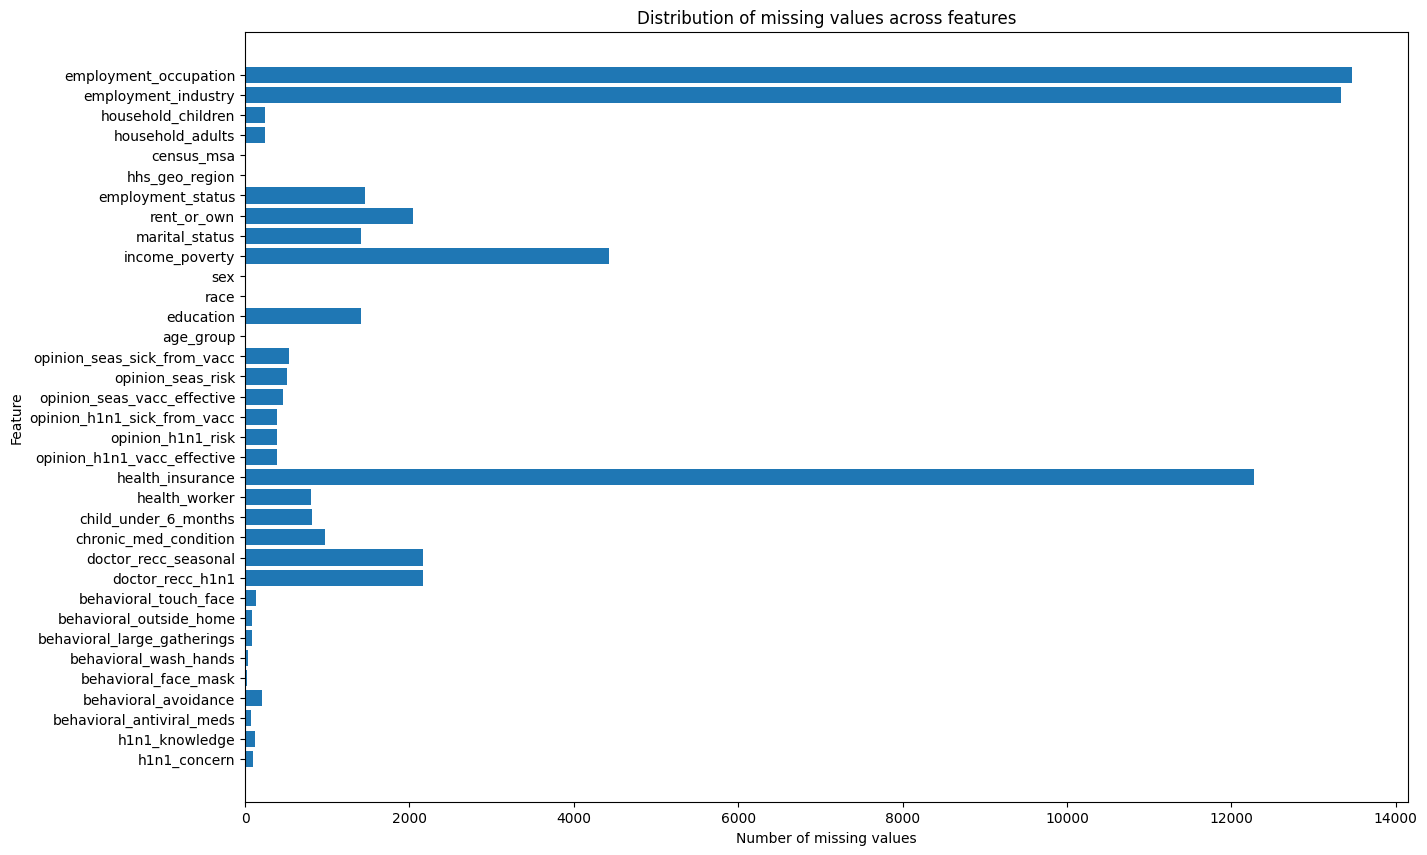

In [16]:
# Plot horizontal bar chart to show the number of missing values for each features
# Written by Clarine

missing_count_per_col = [sum(df_x[col].isna()) for col in df_x.columns]

plt.figure(figsize=(15,10))
plt.barh(df_x.columns, missing_count_per_col)
plt.xlabel('Number of missing values')
plt.ylabel('Feature')
plt.title('Distribution of missing values across features')

plt.show()

In [17]:
# Find unique values in numerical features
# Both features are top coded to 3

for col in numerical_features:
    print(col)
    print(df_x[col].unique())
    print()

household_adults
[ 0.  2.  1.  3. nan]

household_children
[ 0.  3.  2.  1. nan]



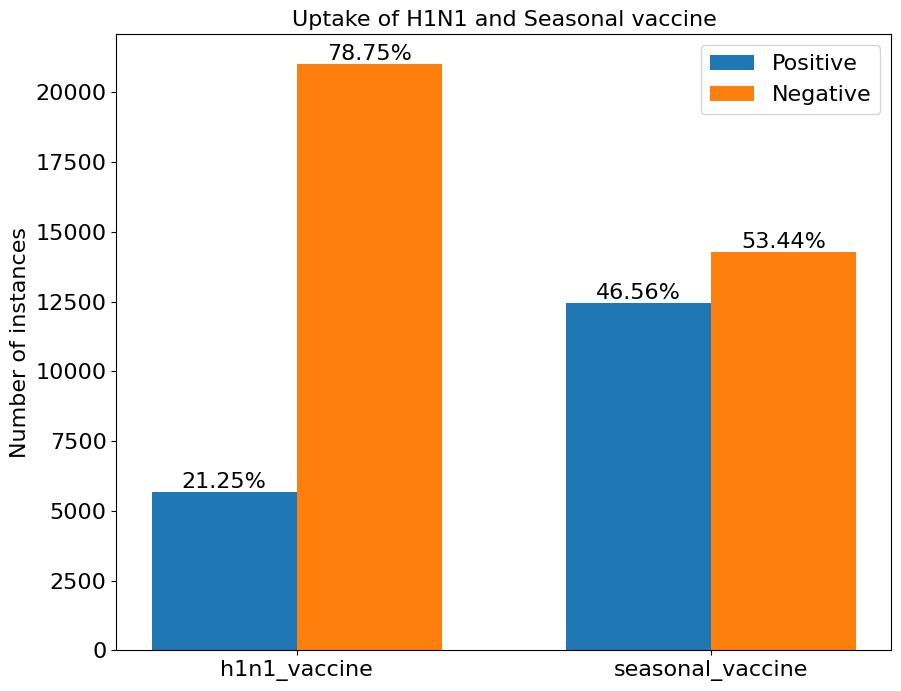

In [18]:
# Plot bar chart to visualise dataset imbalanced
# Written by Clarine

label_counts = df_y.sum()
h1n1_pos = label_counts.values[0]
h1n1_neg = df_x.shape[0] - h1n1_pos
seasonal_pos = label_counts.values[1]
seasonal_neg = df_x.shape[0] - seasonal_pos

pos_data = [h1n1_pos, seasonal_pos]
neg_data = [h1n1_neg, seasonal_neg]

bar_width = 0.35
label_loc = np.arange(2)

# Plot historgram
fig, ax = plt.subplots(figsize=(10,8))
pos_bar = ax.bar(label_loc - bar_width/2, pos_data, bar_width, label='Positive')
neg_bar = ax.bar(label_loc + bar_width/2, neg_data, bar_width, label='Negative')

# Add title, legend, and labels
ax.set_title('Uptake of H1N1 and Seasonal vaccine', fontsize=16)
ax.set_xticks(label_loc)
ax.set_xticklabels([label_counts.index[0], label_counts.index[1]], fontsize=16)
ax.set_ylabel("Number of instances", fontsize=16)
plt.yticks(fontsize=16)
ax.legend(fontsize=16)

# Add text label on top of bars
for bar in pos_bar + neg_bar:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, 
            str(round(float(height/df_x.shape[0]*100), 2)) + '%', 
            ha='center', va='bottom', fontsize=16)

plt.show()

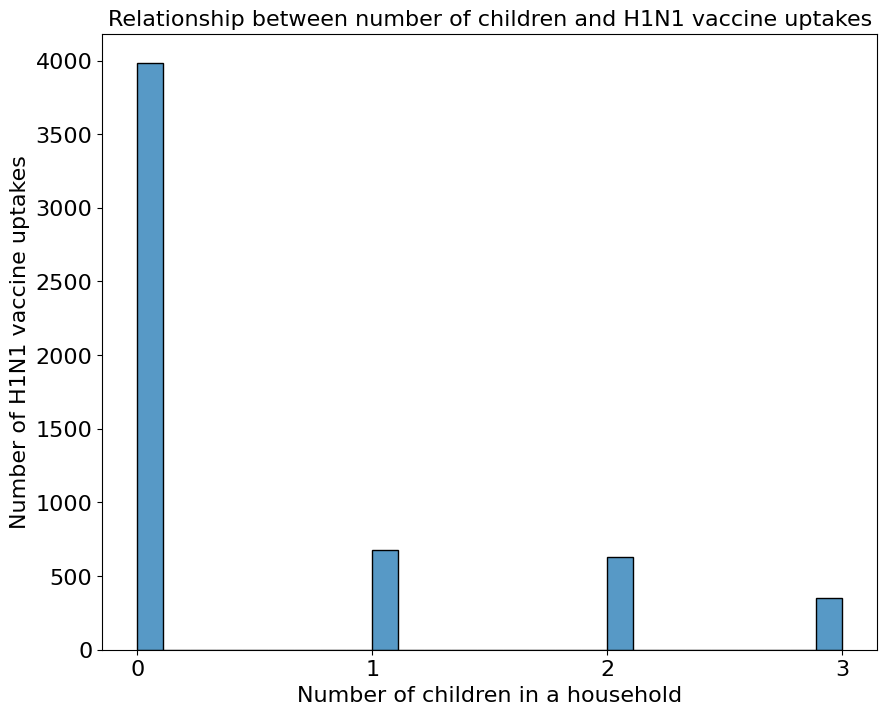

In [25]:
# Visualise data distribution of number of children vs. H1N1 vaccine uptake
# Written by Carolyn

range_array = np.array([0,1,2,3])
df_merged = pd.concat([df_x, df_y], axis=1)
h1n1_children = df_merged[(df_merged['h1n1_vaccine']==1)]

# Plot histogram
plt.figure(figsize=(10,8))
sns.histplot(h1n1_children, x='household_children')

# Add labels
plt.xlabel('Number of children in a household', fontsize=16)
plt.ylabel('Number of H1N1 vaccine uptakes', fontsize=16)
plt.title('Relationship between number of children and H1N1 vaccine uptakes', fontsize=16)
plt.xticks(range_array, fontsize=16)
plt.yticks(fontsize=16)

plt.show()

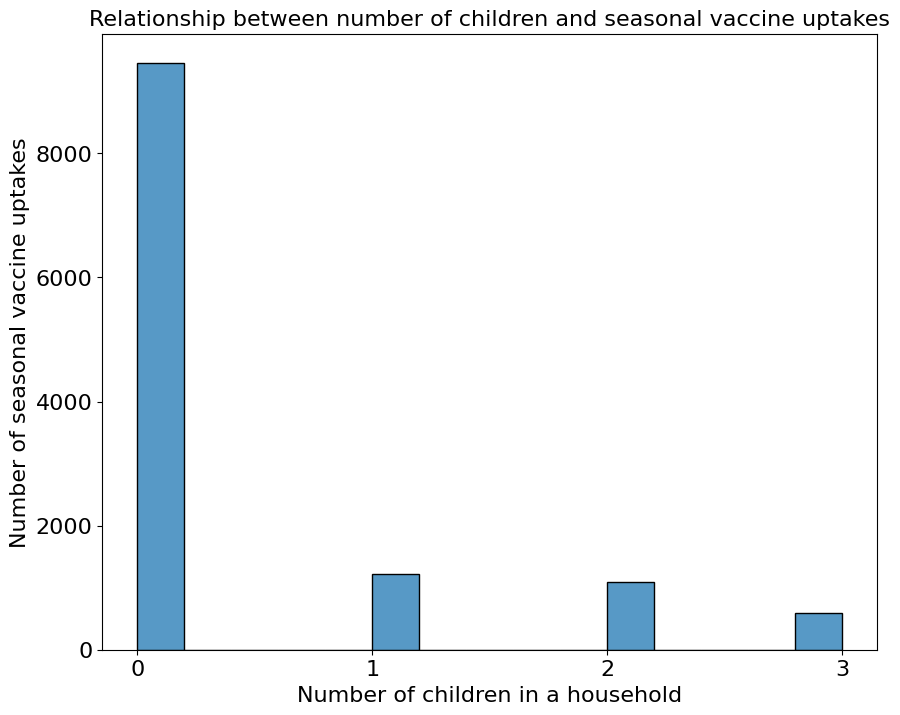

In [26]:
# Visualise data distribution of number of children vs. seasonal vaccine uptake
# Written by Carolyn

range_array = np.array([0,1,2,3])
df_merged = pd.concat([df_x, df_y], axis=1)
seasonal_children = df_merged[(df_merged['seasonal_vaccine']==1)]

# Plot histogram
plt.figure(figsize=(10,8))
sns.histplot(seasonal_children, x='household_children')

# Add labels
plt.xlabel('Number of children in a household', fontsize=16)
plt.ylabel('Number of seasonal vaccine uptakes', fontsize=16)
plt.title('Relationship between number of children and seasonal vaccine uptakes', fontsize=16)
plt.xticks(range_array, fontsize=16)
plt.yticks(fontsize=16)

plt.show()

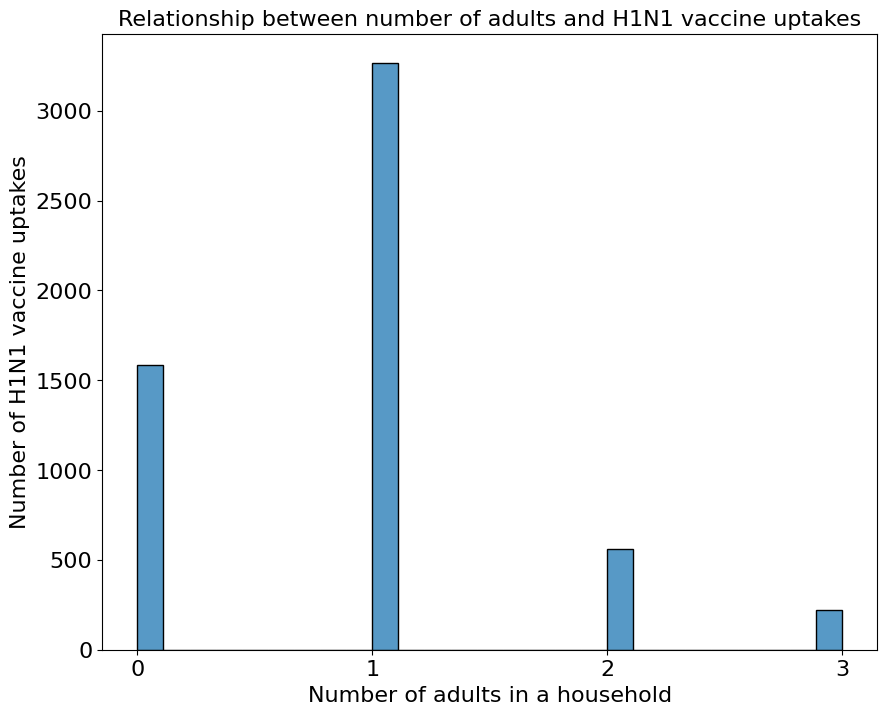

In [27]:
# Visualise data distribution of number of adults vs. H1N1 vaccine uptake
# Written by Carolyn

range_array = np.array([0,1,2,3])
df_merged = pd.concat([df_x, df_y], axis=1)
h1n1_adults = df_merged[(df_merged['h1n1_vaccine']==1)]

# Plot histogram
plt.figure(figsize=(10,8))
sns.histplot(h1n1_adults, x='household_adults')

# Add labels
plt.xlabel('Number of adults in a household', fontsize=16)
plt.ylabel('Number of H1N1 vaccine uptakes', fontsize=16)
plt.title('Relationship between number of adults and H1N1 vaccine uptakes', fontsize=16)
plt.xticks(range_array, fontsize=16)
plt.yticks(fontsize=16)

plt.show()

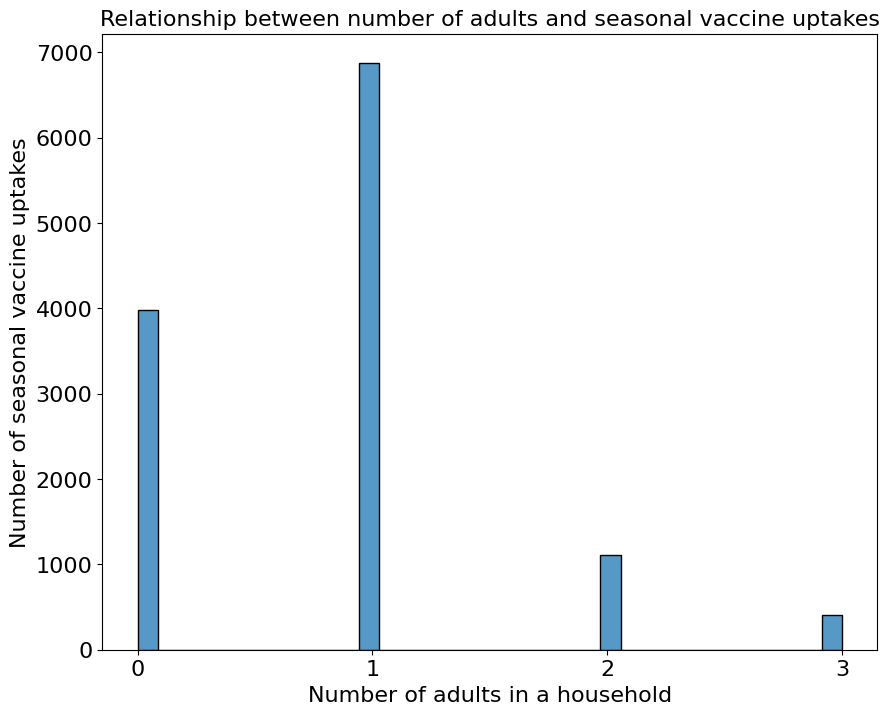

In [22]:
# Visualise data distribution of number of adults vs. seasonal vaccine uptake
# Written by Carolyn

range_array = np.array([0,1,2,3])
df_merged = pd.concat([df_x, df_y], axis=1)
seasonal_adults = df_merged[(df_merged['seasonal_vaccine']==1)]

# Plot histogram
plt.figure(figsize=(10,8))
sns.histplot(seasonal_adults, x='household_adults')

# Add labels
plt.xlabel('Number of adults in a household', fontsize=16)
plt.ylabel('Number of seasonal vaccine uptakes', fontsize=16)
plt.title('Relationship between number of adults and seasonal vaccine uptakes', fontsize=16)
plt.xticks(range_array, fontsize=16)
plt.yticks(fontsize=16)

plt.show()

## Data Pre-Processing (1)

This section is written by Clarine and Carolyn with the references mentioned below. Each cell is written by both of us unless specified.<br>

_References_ <br>
[1]<br>
Title: Lab 2 - Wrangling and preprocessing data<br>
Author: Johann Benerradi, Jeremie Clos<br>
Availability: https://moodle.nottingham.ac.uk/mod/resource/view.php?id=6562915<br>

[2]<br>
Title: Lab 4 - Data Analysis and Modelling<br>
Author: Nazia Hameed, Jeremie Clos<br>
Availability: https://moodle.nottingham.ac.uk/mod/resource/view.php?id=6590728<br>

### Dealing with missing values
1. Drop all rows with at least 50% of missing values
2. Mean vs median imputation
3. Mode imputation

In [23]:
# Drop rows with at least half of its value missing

feature_num = len(df_x.columns)
df_x.dropna(thresh=feature_num/2, inplace=True)

# Delete the same rows from df_y
dropped_rows = df_y[~df_y.index.isin(df_x.index)]
print(len(dropped_rows))
df_y.drop(dropped_rows.index, inplace=True)

206


In [24]:
# Data imputation: numerical features

# Create 2 copies of the DataFrame
df_x_mean = df_x.copy()
df_x_median = df_x.copy()

# Mean imputation
# Written by Clarine
numerical_feature_mean = round(df_x[numerical_features].mean())
df_x_mean.fillna(numerical_feature_mean, inplace=True)

# Median imputation
# Written by Carolyn
numerical_feature_median = df_x[numerical_features].median()
df_x_median.fillna(numerical_feature_median, inplace=True)

In [25]:
# Data imputation: categorical (binary + ordinal + nominal) features
# Mode imputation
categorical_features_mode = df_x[categorical_features].mode()
df_x_mean.fillna(categorical_features_mode.iloc[0], inplace=True)
df_x_median.fillna(categorical_features_mode.iloc[0], inplace=True)

In [26]:
# Check if there still exist missing values in the DataFrame
print(df_x_mean.isnull().values.any())
print(df_x_median.isnull().values.any())

False
False


### Change data type (1)
1. Numerical features: float to int8
2. Binary features: float to bool
3. Ordinal features: float to int
<br>
***Note:*** *the data type of nominal features needs to be changed after data encoding (which will be done later)*

In [27]:
# Check original data type
print(df_x_mean.info())
print()
print(df_x_median.info())

<class 'pandas.core.frame.DataFrame'>
Index: 26501 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26501 non-null  float64
 1   h1n1_knowledge               26501 non-null  float64
 2   behavioral_antiviral_meds    26501 non-null  float64
 3   behavioral_avoidance         26501 non-null  float64
 4   behavioral_face_mask         26501 non-null  float64
 5   behavioral_wash_hands        26501 non-null  float64
 6   behavioral_large_gatherings  26501 non-null  float64
 7   behavioral_outside_home      26501 non-null  float64
 8   behavioral_touch_face        26501 non-null  float64
 9   doctor_recc_h1n1             26501 non-null  float64
 10  doctor_recc_seasonal         26501 non-null  float64
 11  chronic_med_condition        26501 non-null  float64
 12  child_under_6_months         26501 non-null  float64
 13  health_worker        

In [28]:
# Function to convert data type of numerical, binary, and ordinal features
# Written by Clarine

def convert_dtype(df):
    # Change data type of numerical features
    df[numerical_features] = df[numerical_features].astype("int8")
    
    # Change data type of binary features
    df[binary_features] = df[binary_features].astype("bool")
    
    # Change data type of ordinal features
    df[ordinal_features] = df[ordinal_features].astype("int")
    
    return df

In [29]:
# Call convert_dtype() to change data type for each DataFrame
df_x_mean = convert_dtype(df_x_mean)
df_x_median = convert_dtype(df_x_median)

In [30]:
# Check if data types are changed properly
df_x_mean.info()
print()
df_x_median.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26501 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   h1n1_concern                 26501 non-null  int64 
 1   h1n1_knowledge               26501 non-null  int64 
 2   behavioral_antiviral_meds    26501 non-null  bool  
 3   behavioral_avoidance         26501 non-null  bool  
 4   behavioral_face_mask         26501 non-null  bool  
 5   behavioral_wash_hands        26501 non-null  bool  
 6   behavioral_large_gatherings  26501 non-null  bool  
 7   behavioral_outside_home      26501 non-null  bool  
 8   behavioral_touch_face        26501 non-null  bool  
 9   doctor_recc_h1n1             26501 non-null  bool  
 10  doctor_recc_seasonal         26501 non-null  bool  
 11  chronic_med_condition        26501 non-null  bool  
 12  child_under_6_months         26501 non-null  bool  
 13  health_worker                26501 n

## Data Analysis (2)
This section is written by Clarine (after discussion with Carolyn) with the references mentioned below.<br>

_References_ <br>
[1]<br>
Title: Lab 3 - Visualisation with Matplotlib and Seaborn<br>
Author: Johann Benerradi, Jeremie Clos<br>
Availability:https://moodle.nottingham.ac.uk/mod/resource/view.php?id=6575328<br>

[2]<br>
Title: Lab 4 - Data Analysis and Modelling<br>
Author: Nazia Hameed, Jeremie Clos<br>
Availability: https://moodle.nottingham.ac.uk/mod/resource/view.php?id=6590728<br>

[3]<br>
Title: Constructing heat map for Chi-square test of independence<br>
Author: Shafqaat Ahmad<br>
Availability: https://medium.com/analytics-vidhya/constructing-heat-map-for-chi-square-test-of-independence-6d78aa2b140f

In [31]:
# Function to plot p-values heatmap from Chi-Square test matrix
def plot_p_values(p_values, feature_dtype, imputation):
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(p_values, dtype=bool))
    
    # Plot the heatmap
    plt.figure(figsize=(30, 30))
    sns.heatmap(p_values.astype(float), annot=True, cmap='coolwarm_r', fmt='.4f', linewidths=0.5, cbar=False, mask=mask, annot_kws={"fontsize": 25})
    plt.title(f"Chi-Square P-Value Heatmap for {feature_dtype} using {imputation} imputation", fontsize=45)
    plt.xticks(rotation=45, ha="right", fontsize=30)
    plt.yticks(rotation=0, fontsize=30)
    plt.show()

In [32]:
# Function to plot Chi-Square statistic heatmap from Chi-Square test matrix
def plot_chi_square_stats(chi_values, feature_dtype, imputation):
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(chi_values, dtype=bool))
    
    # Plot the heatmap
    plt.figure(figsize=(30, 30))
    sns.heatmap(chi_values.astype(float), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=False, mask=mask, annot_kws={"fontsize": 25})
    plt.title(f"Chi-Square Statistic Heatmap for {feature_dtype} using {imputation} imputation", fontsize=45)
    plt.xticks(rotation=45, ha="right", fontsize=30)
    plt.yticks(rotation=0, fontsize=30)
    plt.show()

In [33]:
# Function to get Chi-Square test matrix
def chi_square_matrix(df, feature_dtype, imputation):
    # Concatenate the features and target variables
    df_concat =  pd.concat([df, df_y], axis=1)
    
    # Create empty DataFrame to store p-values and Chi-Square values
    p_values = pd.DataFrame(index=df_concat.columns, columns=df_concat.columns)
    chi_values = pd.DataFrame(index=df_concat.columns, columns=df_concat.columns)
    
    # Calculate the p-values and Chi-Square values for each pair of features
    for col1 in df_concat.columns:
        for col2 in df_concat.columns:
            contingency_table = pd.crosstab(index=df_concat[col1], columns=df_concat[col2])
            chi, p_value, _, _ = chi2_contingency(contingency_table)
            p_values.loc[col1, col2] = p_value
            chi_values.loc[col1, col2] = chi
            
    # Call plot_p_values() to plot the p-values heatmap
    plot_p_values(p_values, feature_dtype, imputation)
    
    # Call plot_chi_square_stats() to plot the Chi Square value heatmap
    plot_chi_square_stats(chi_values, feature_dtype, imputation)
    
    chi_values = chi_values.astype(float)
    return chi_values

#### TO VIEW ALL FIGURES on Anaconda Python Notebook
1. Click on "File" in the top menu bar.
2. Select "Print Preview" from the dropdown menu.

***NOTE***: **The values in the Chi-Square Heatmap consists of values that are smaller than 4 decimal places which are not shown due to space constraint. Therefore, the heatmap plot can have different colours for each grid despite having the 'same value' of 0.0000.**

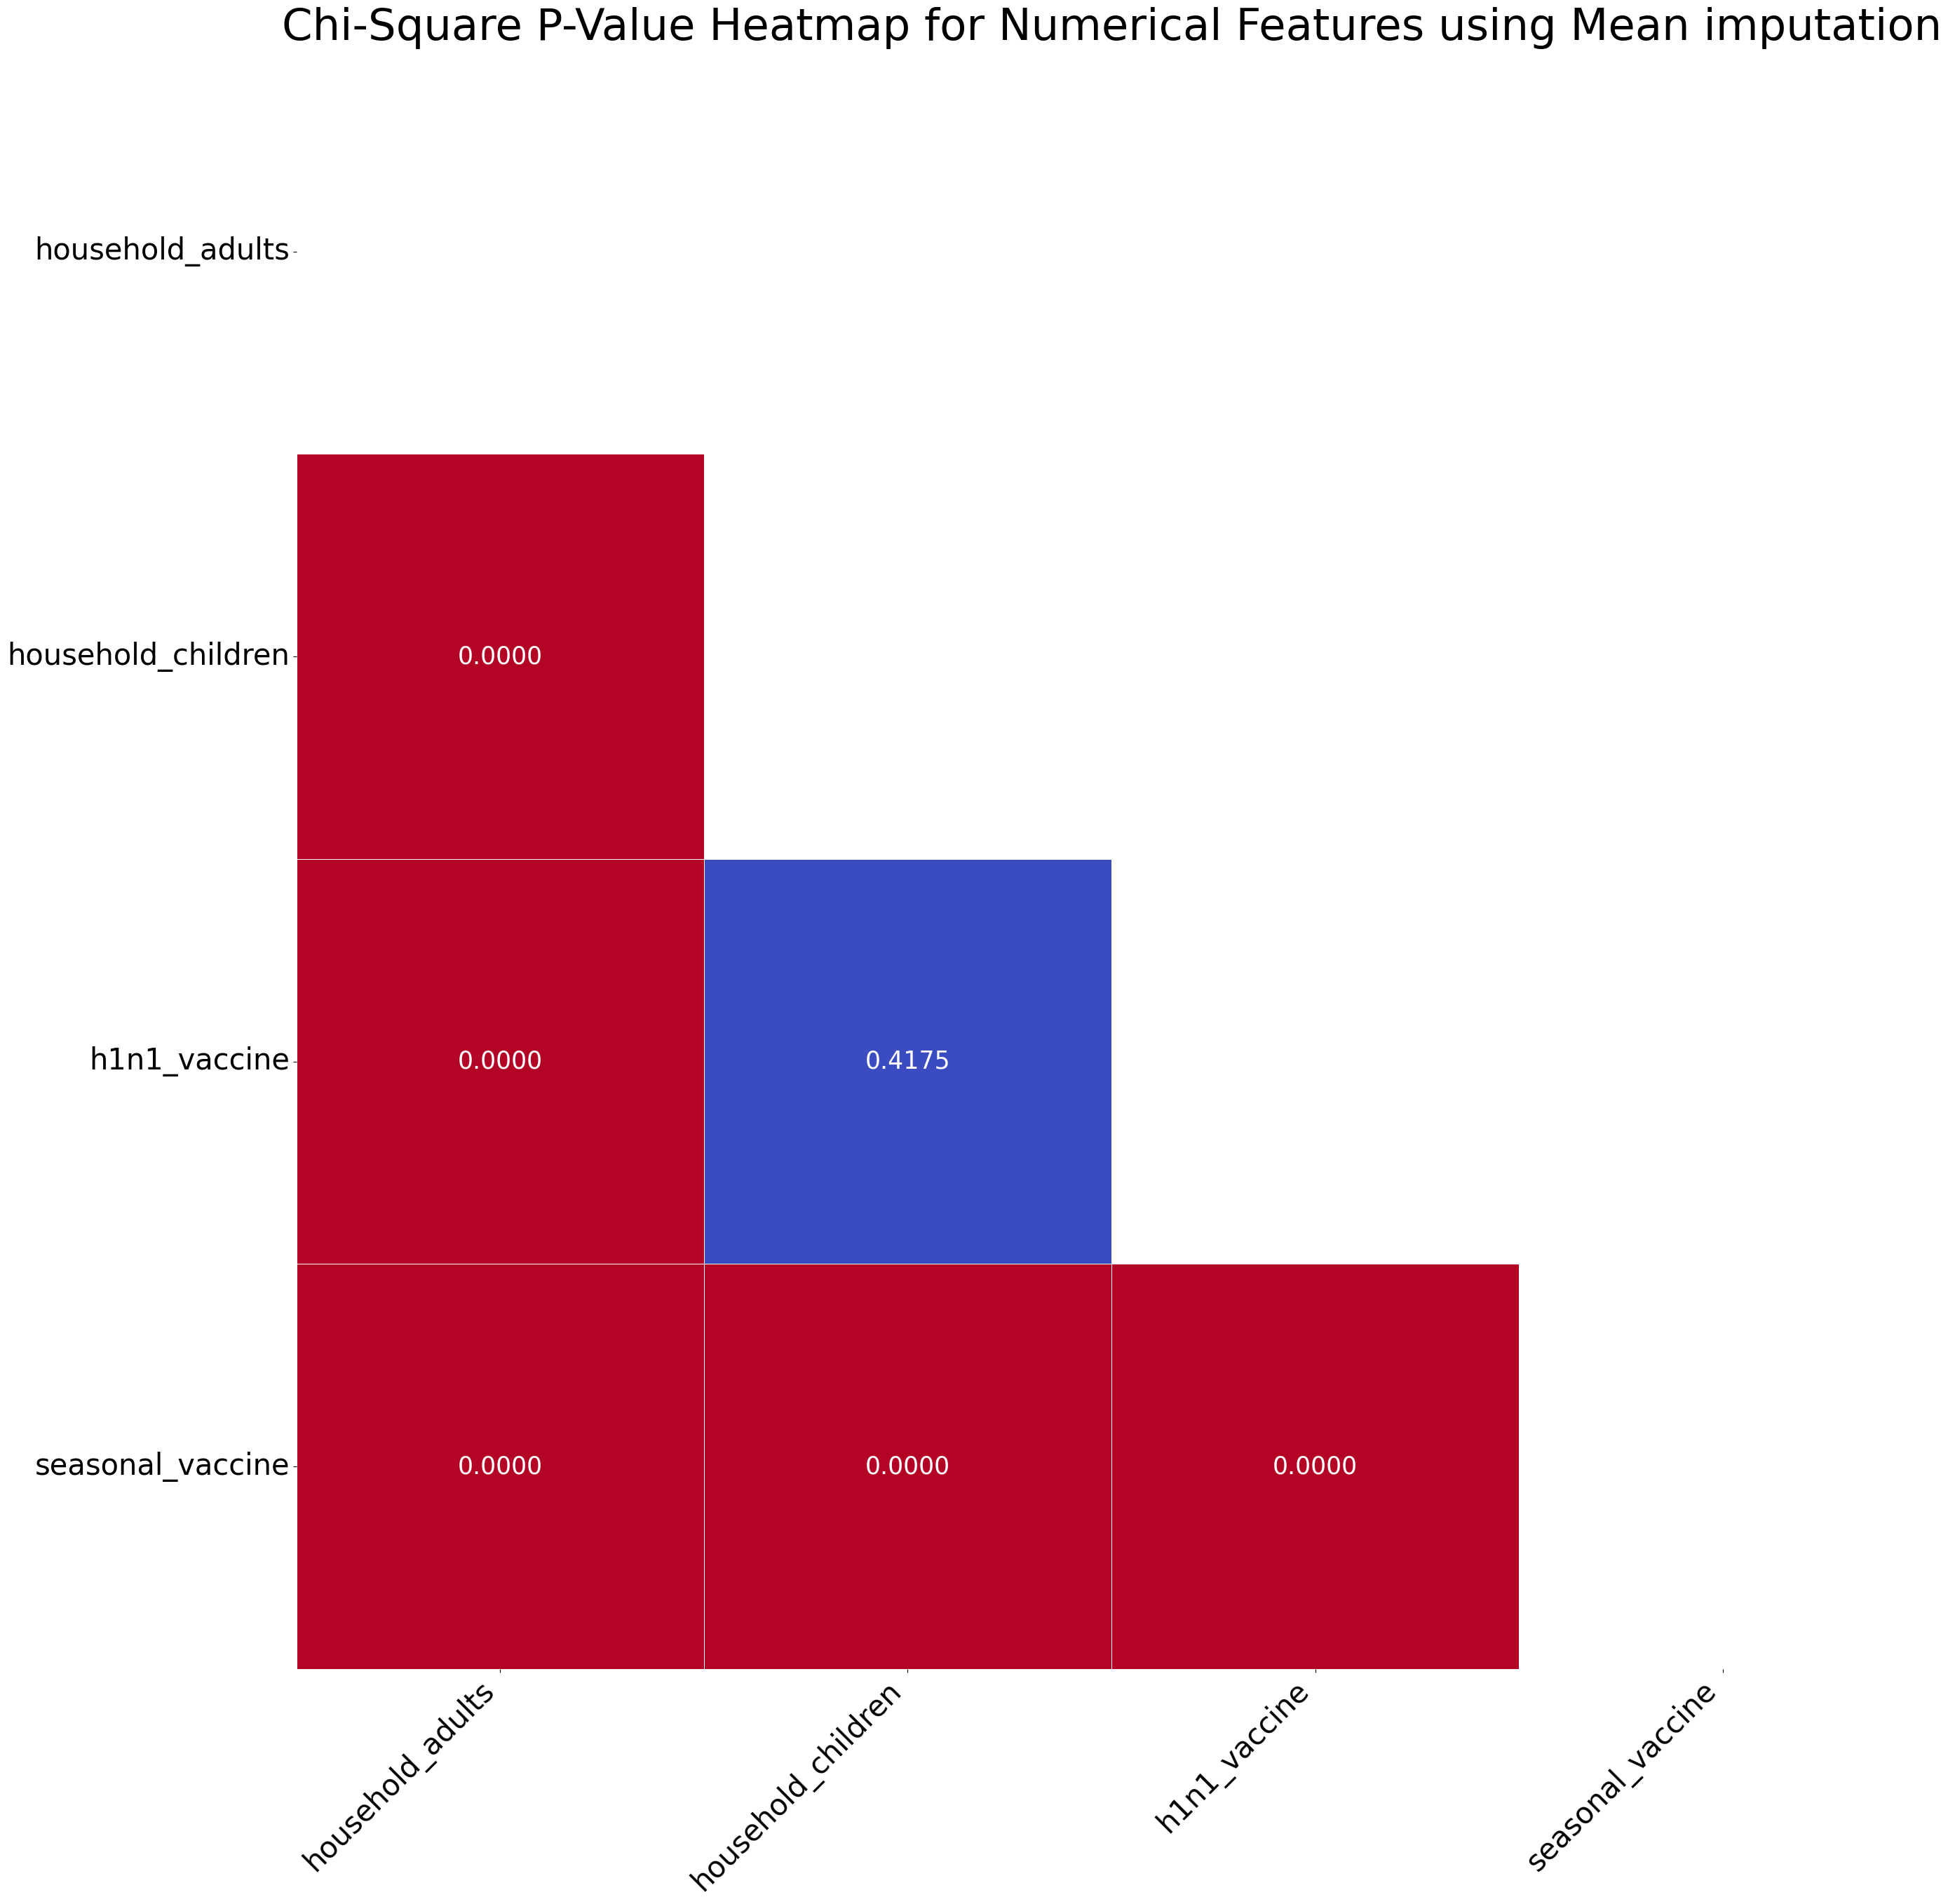

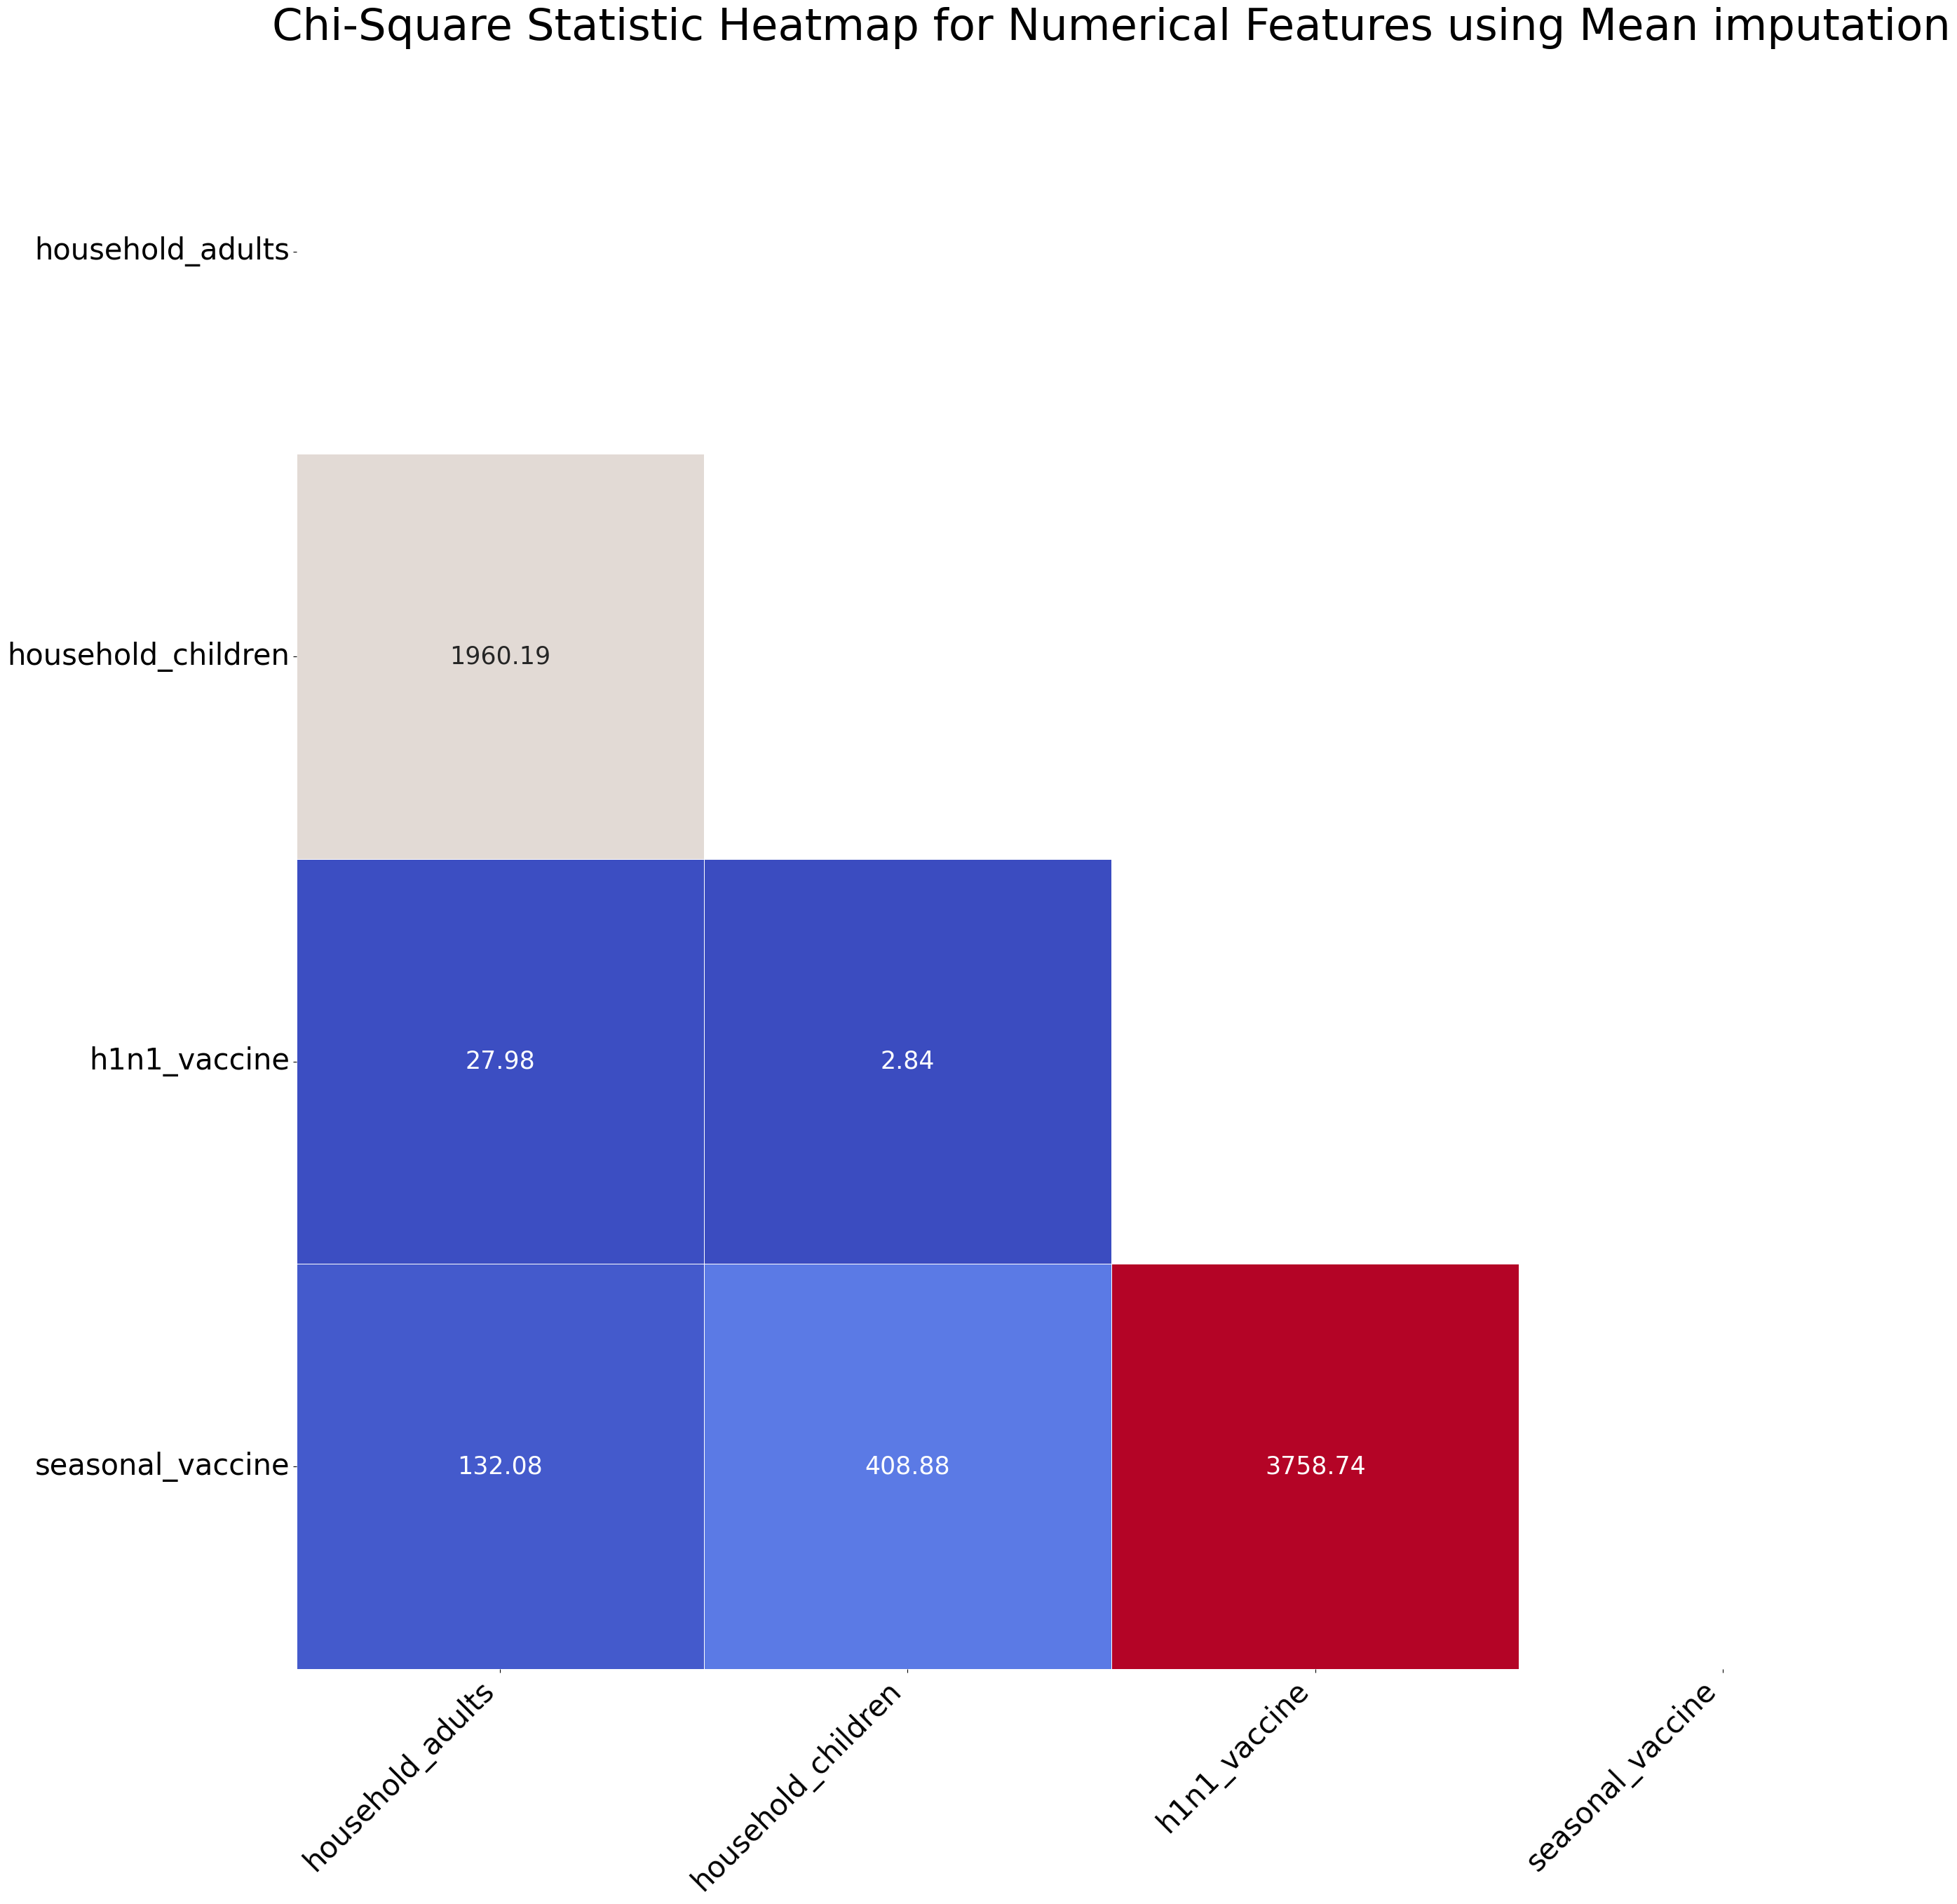

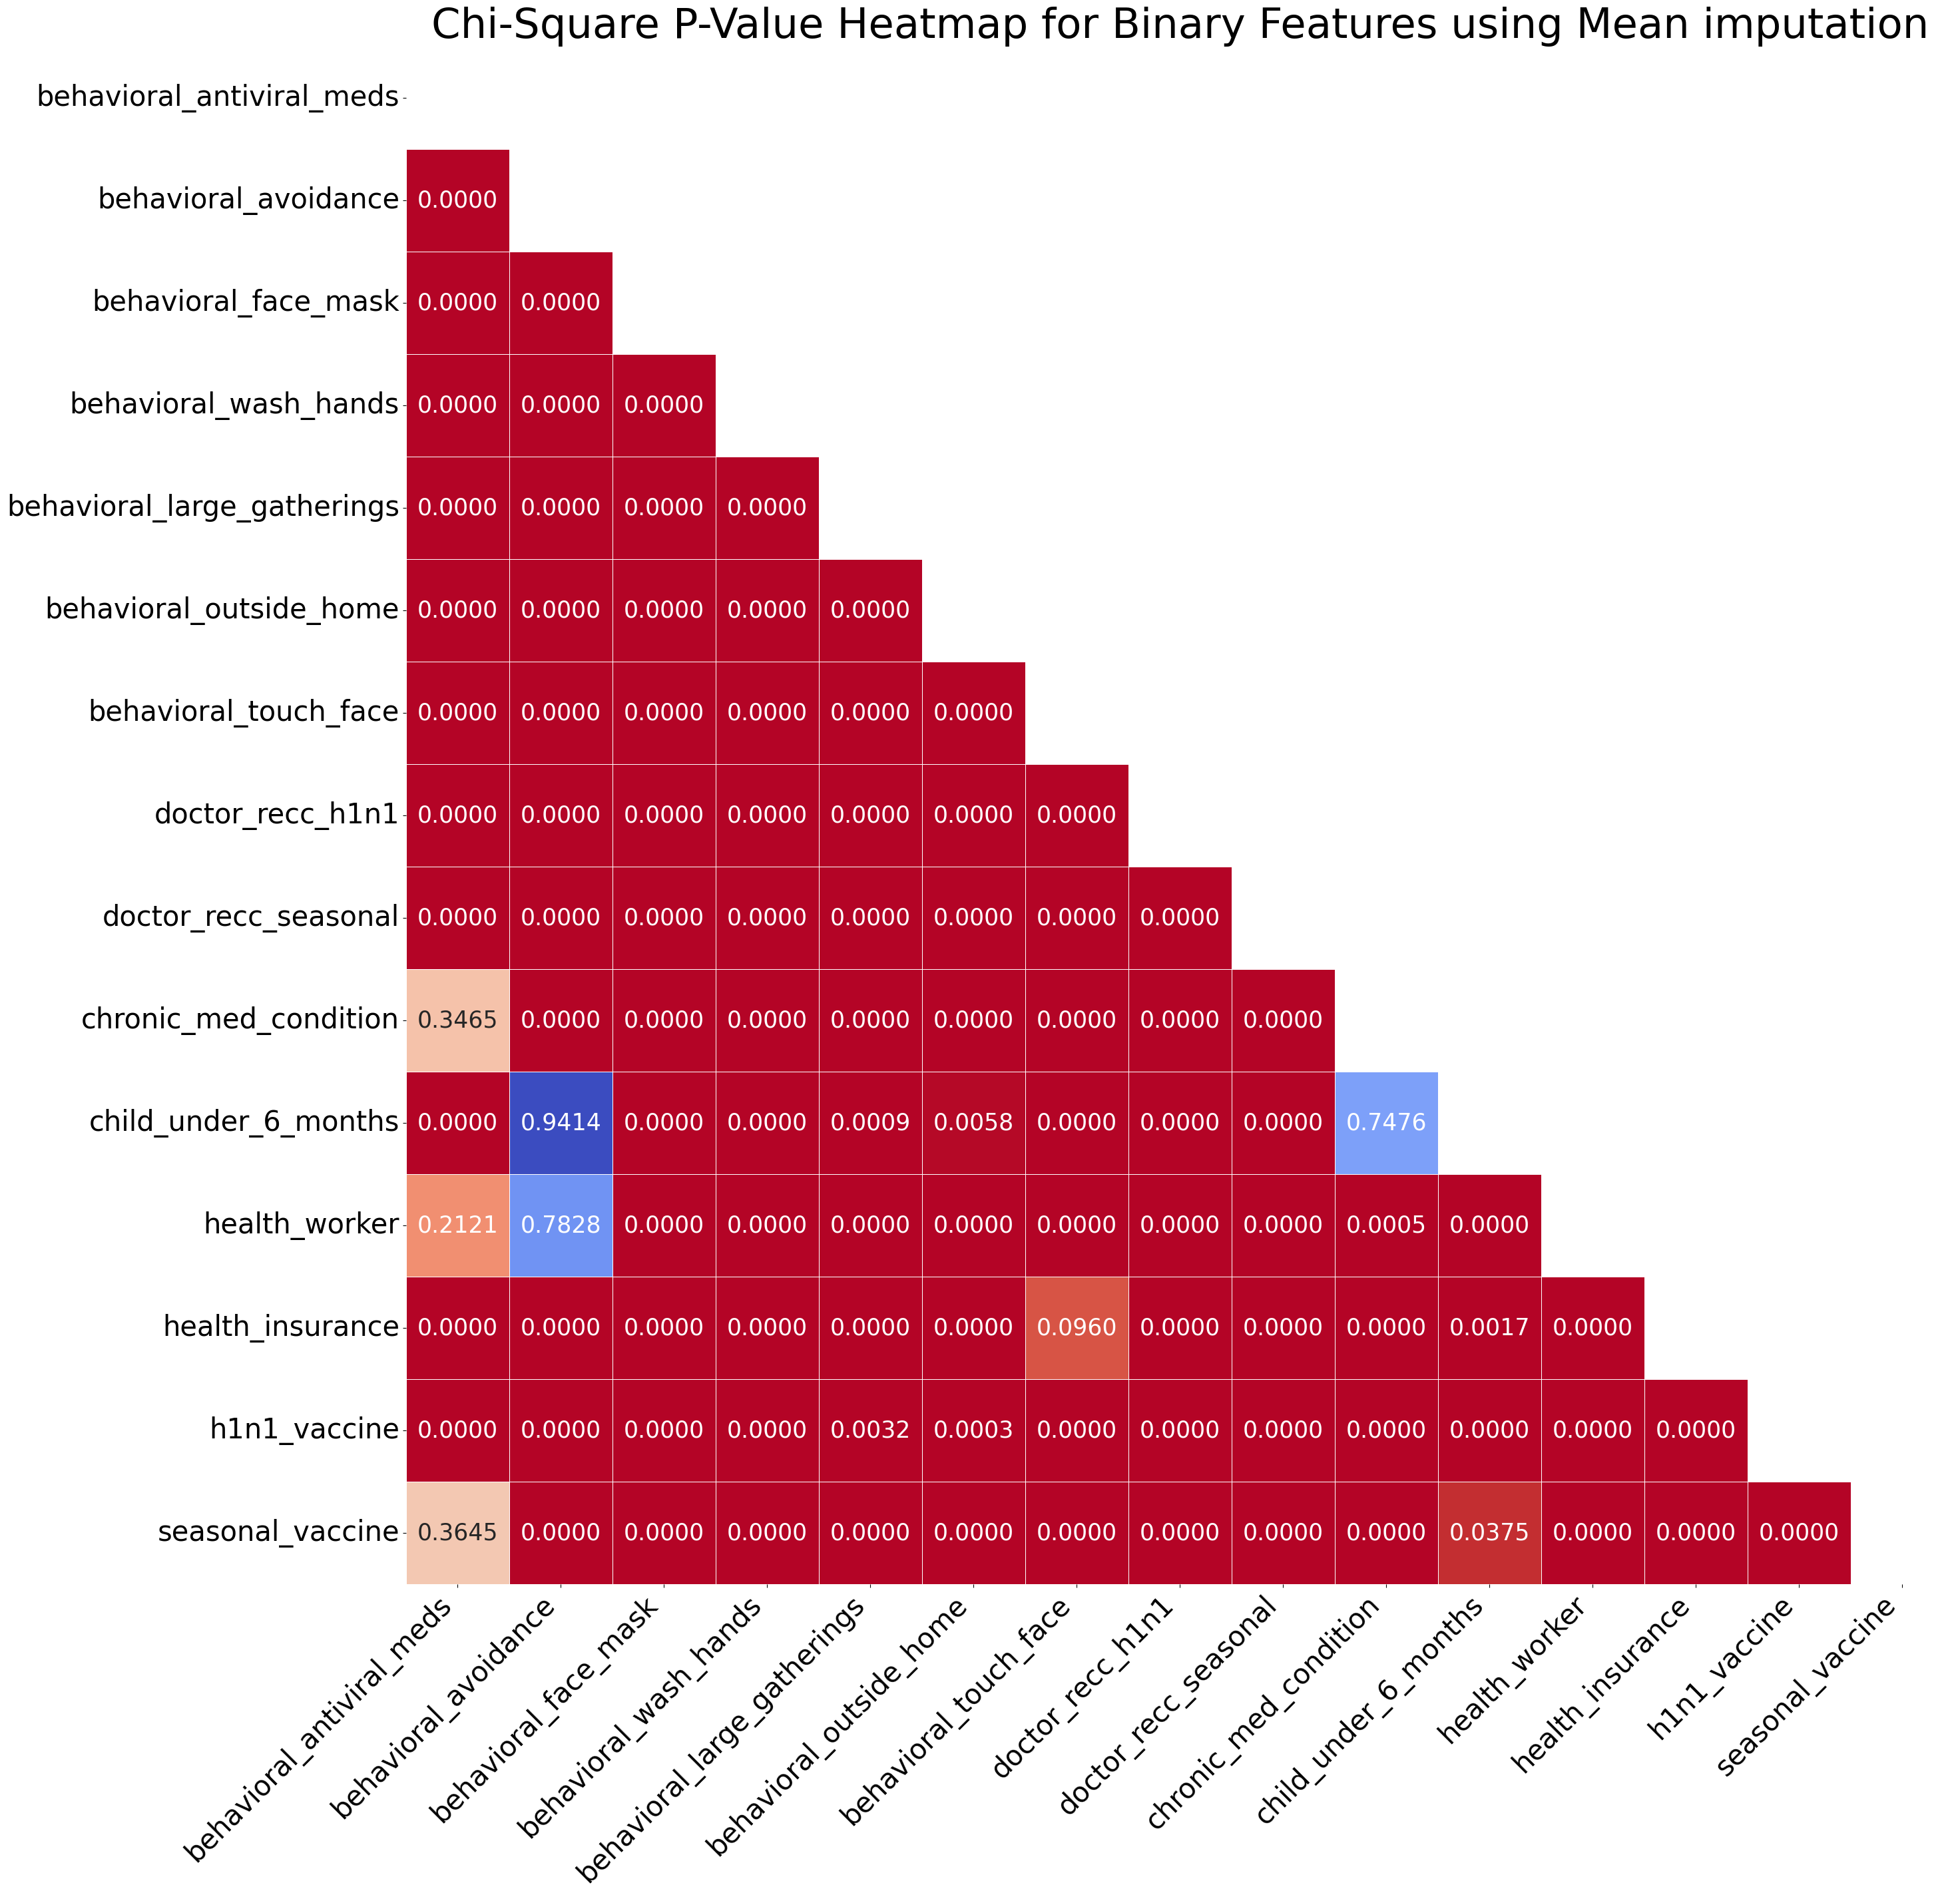

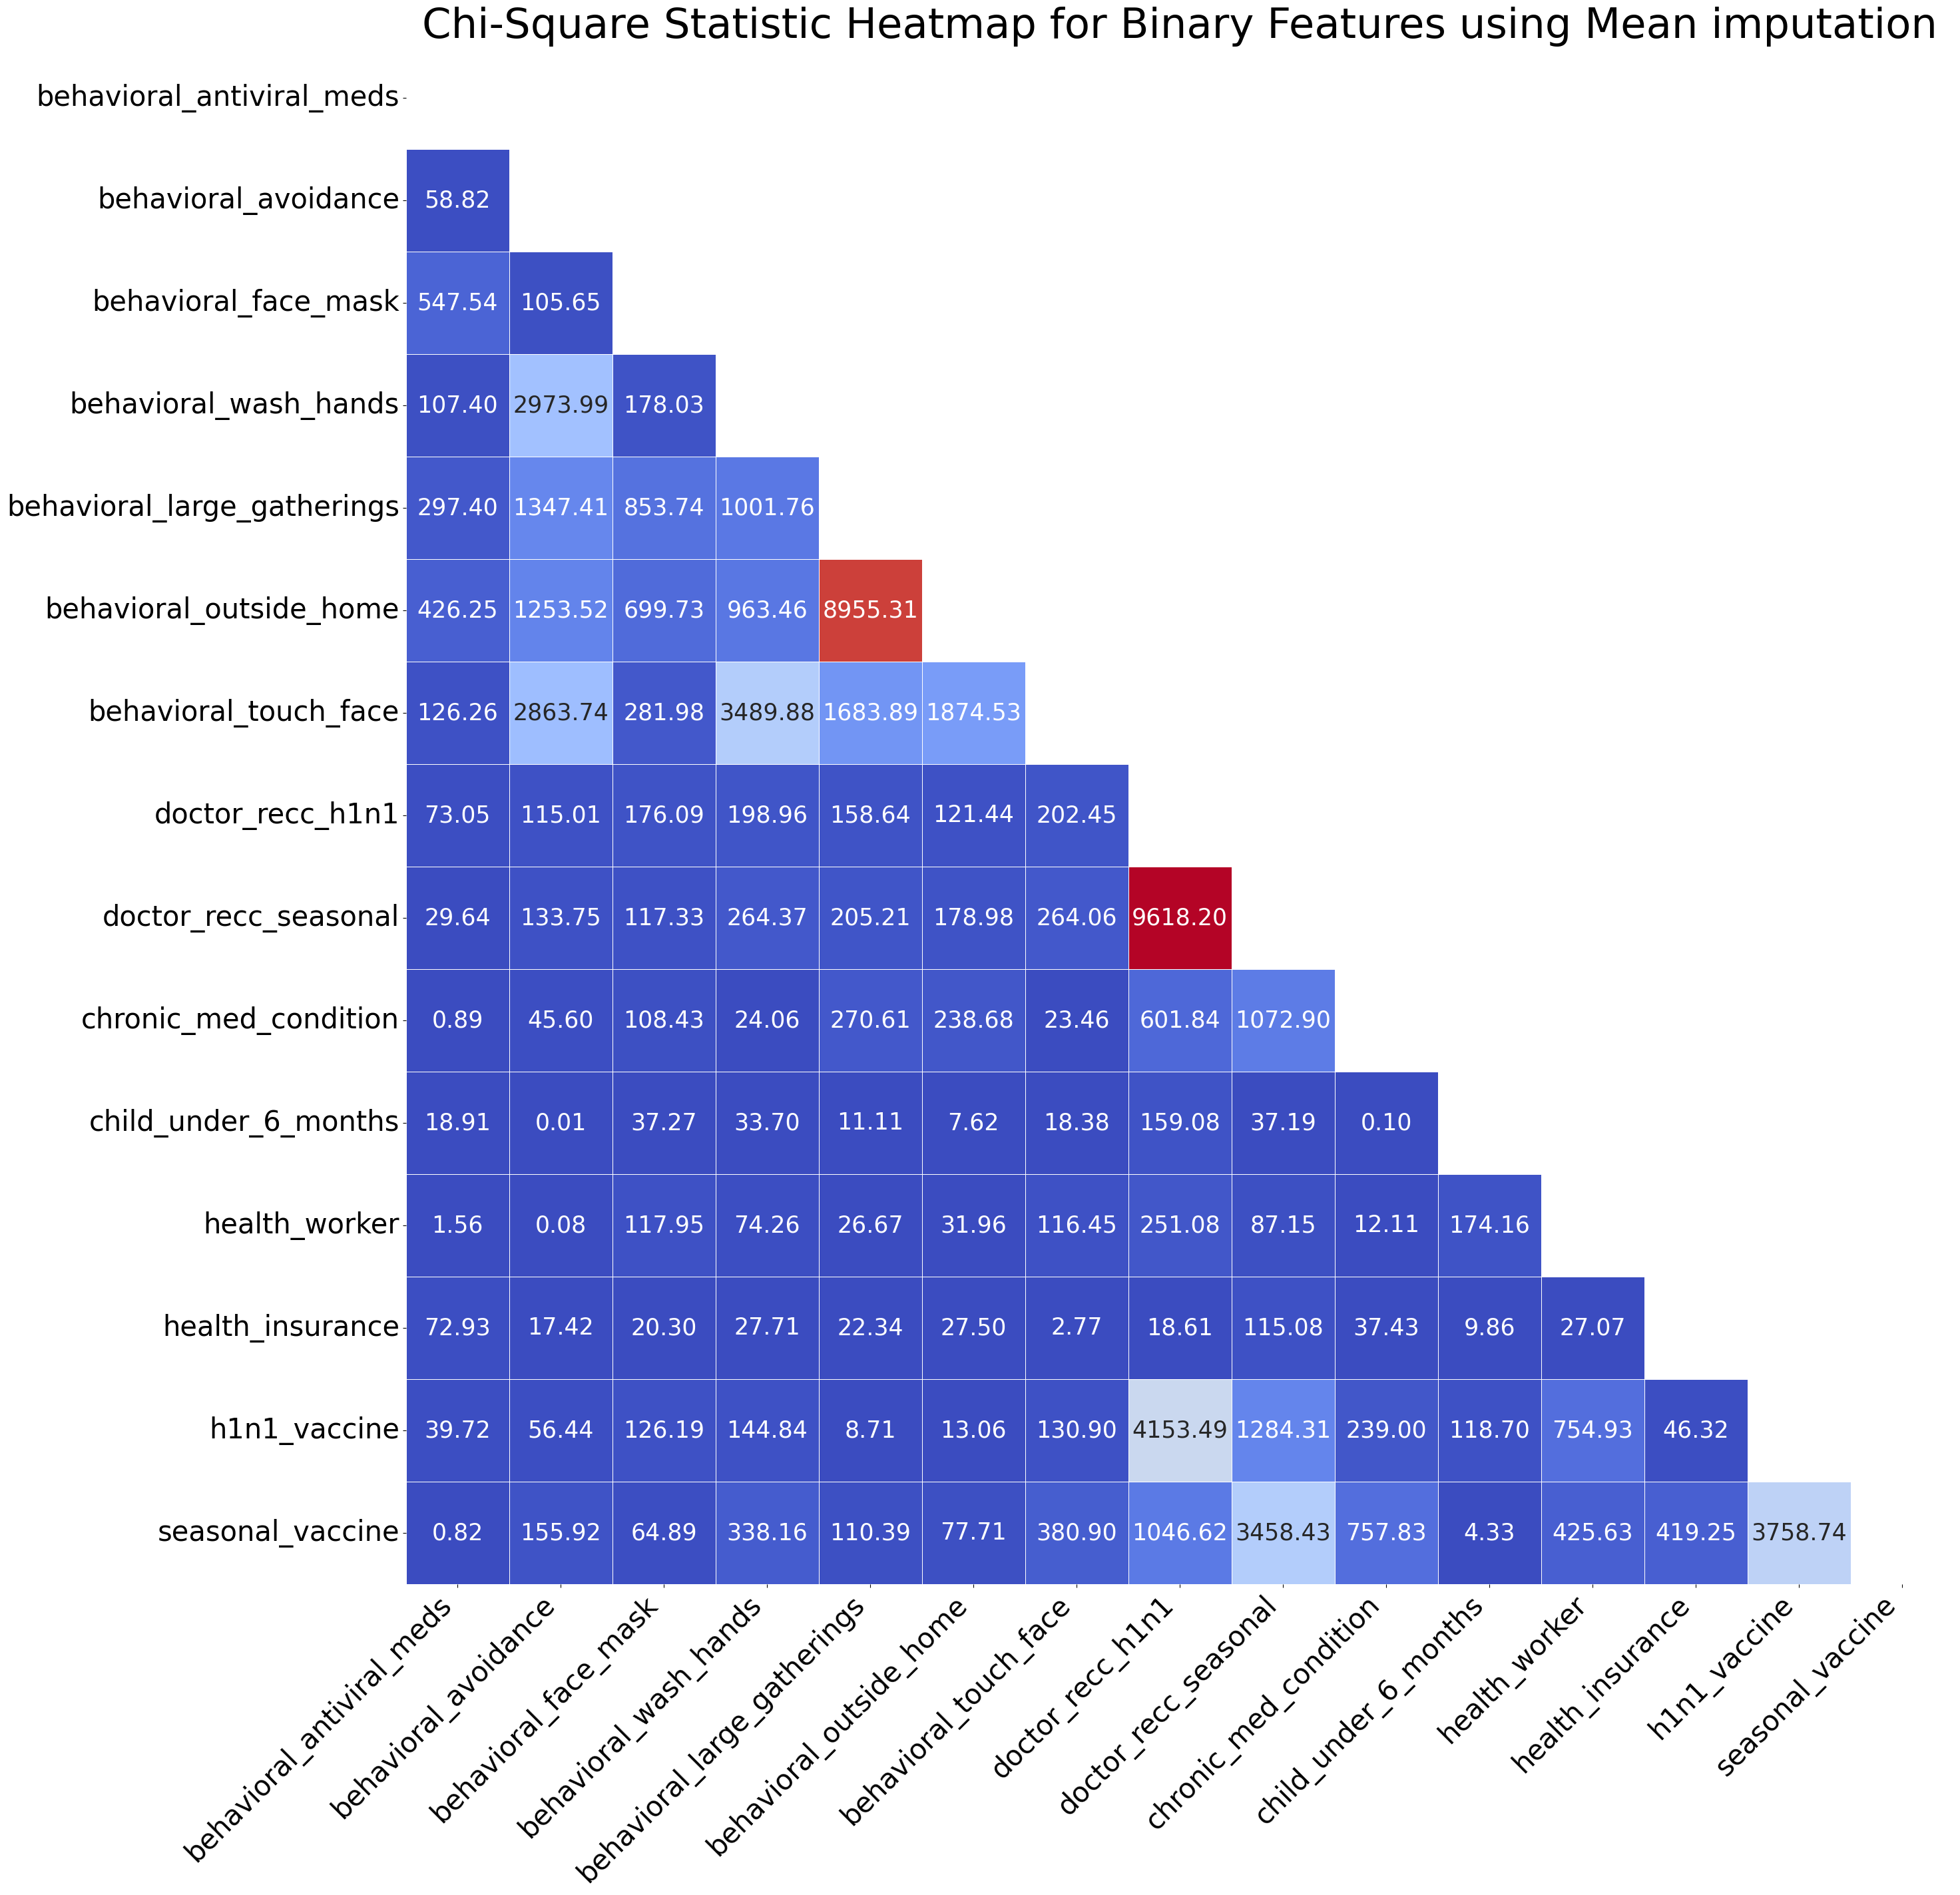

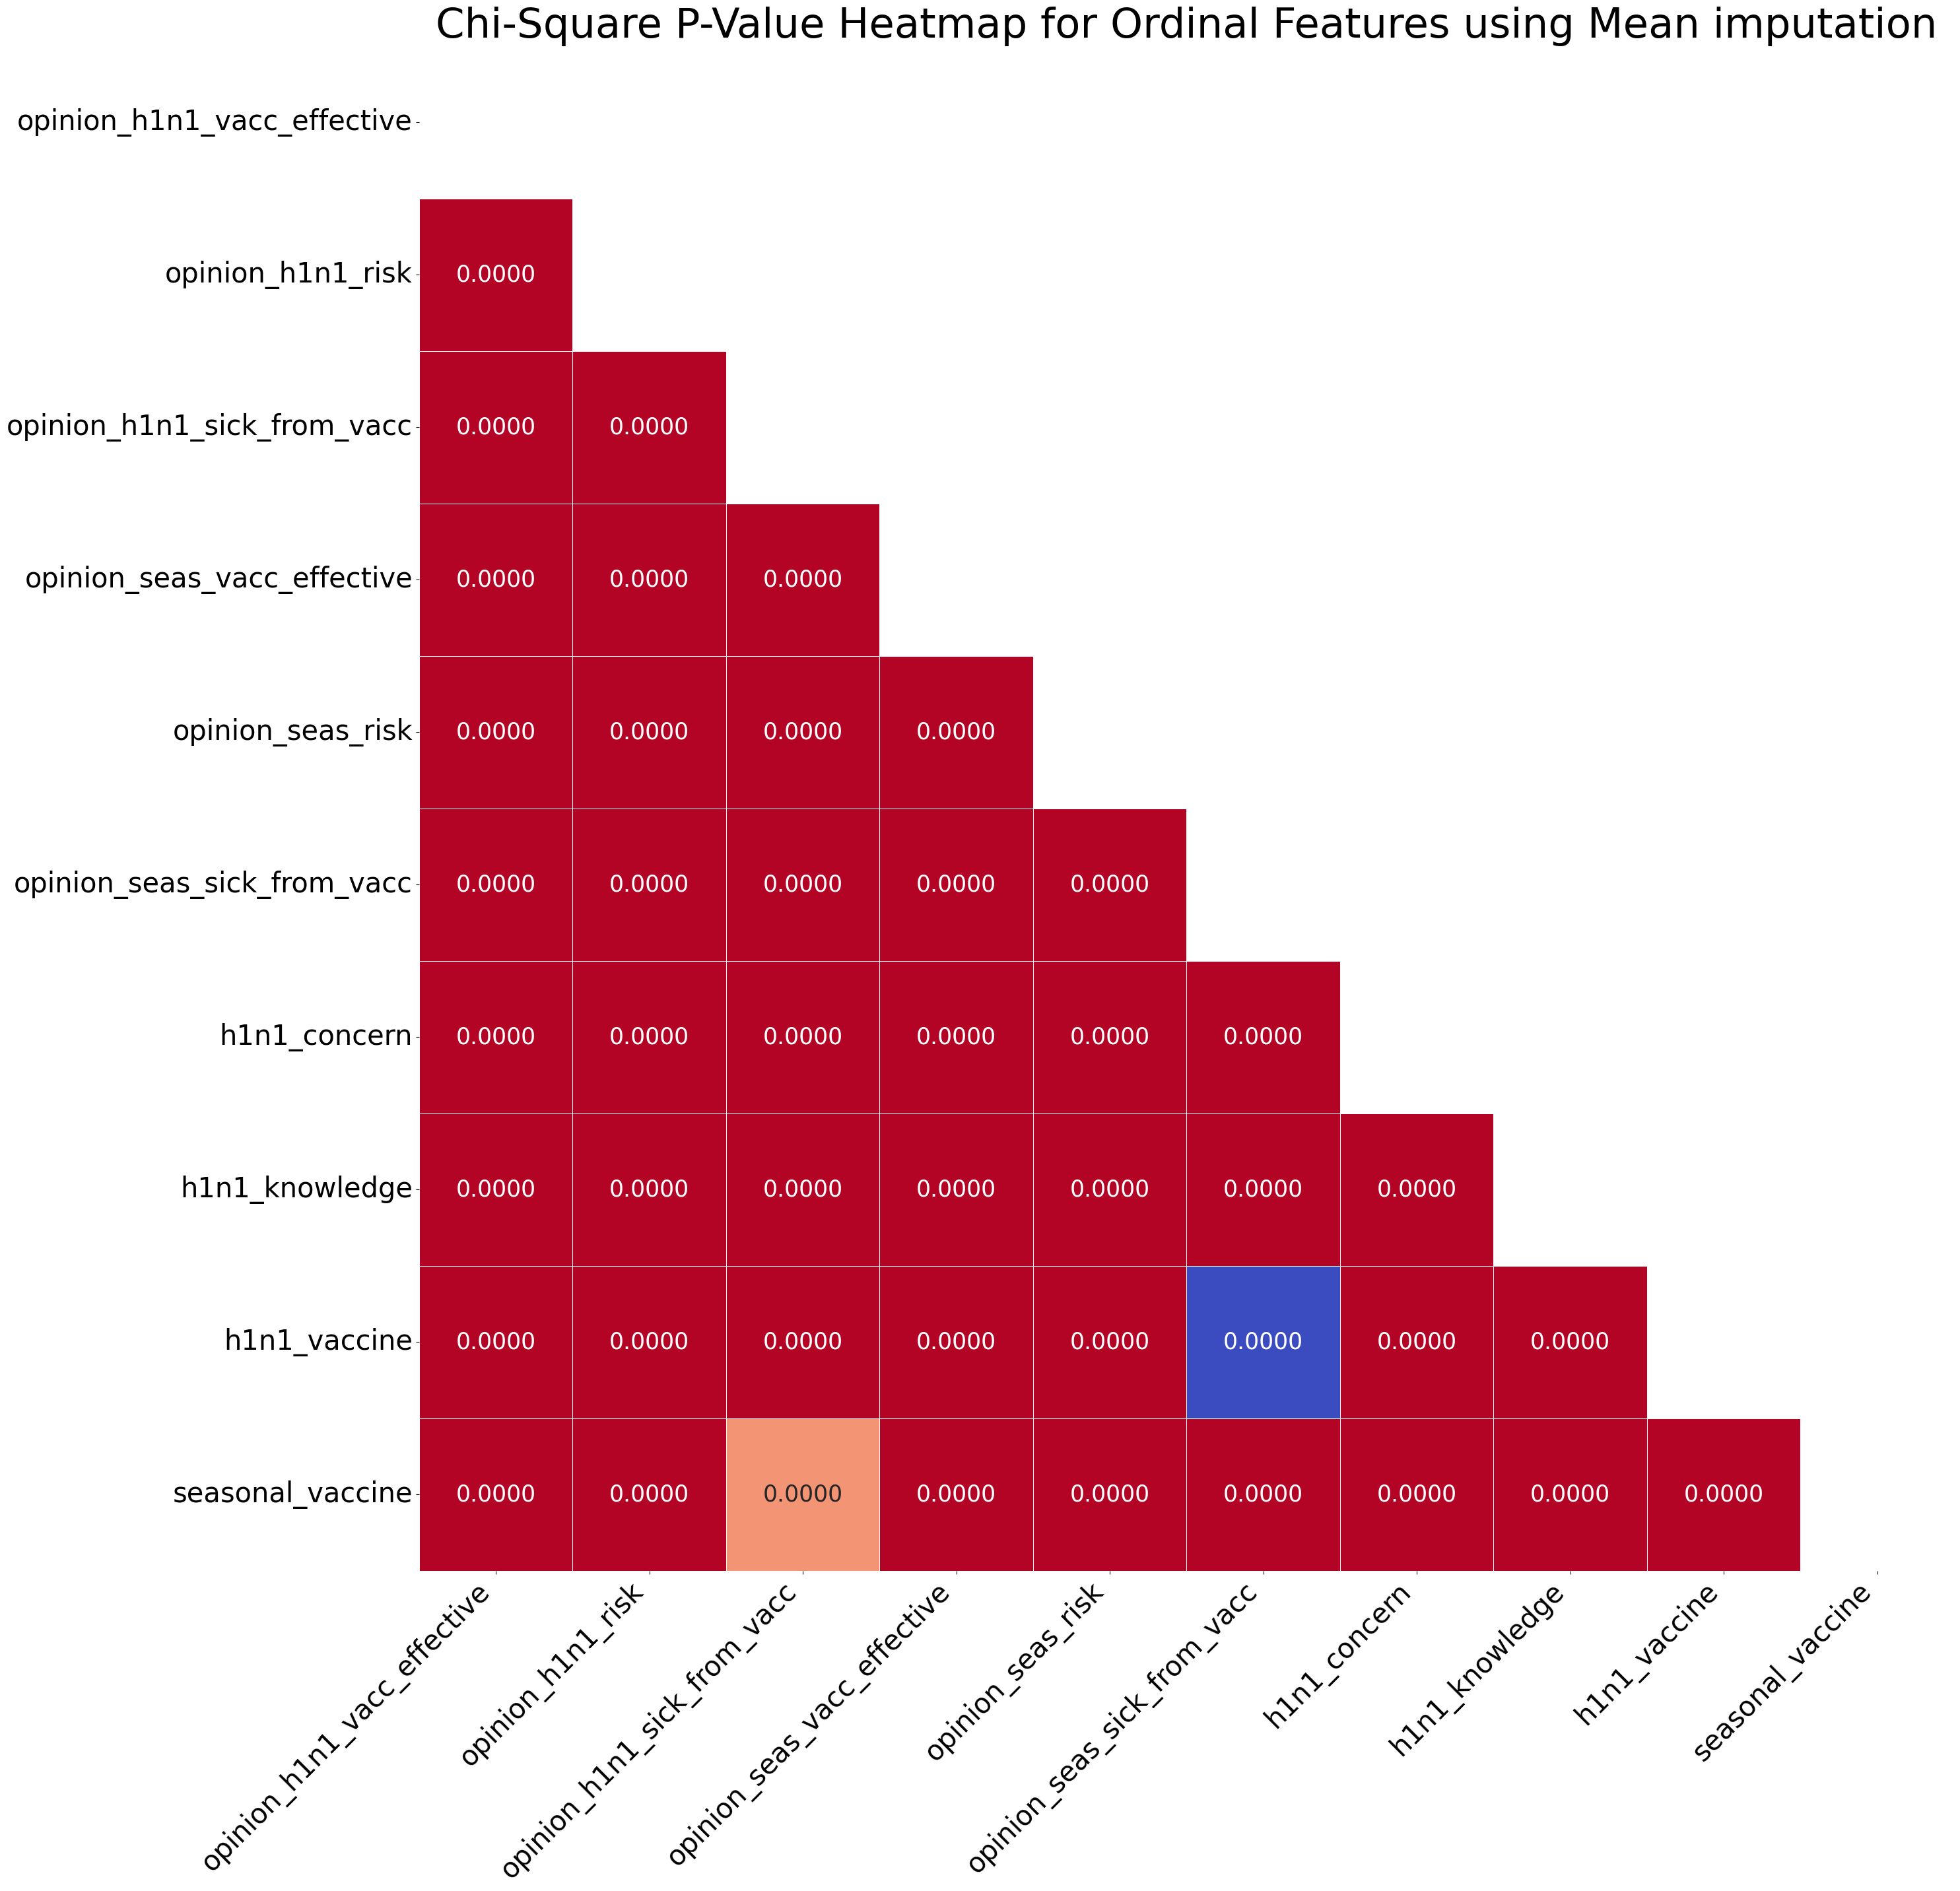

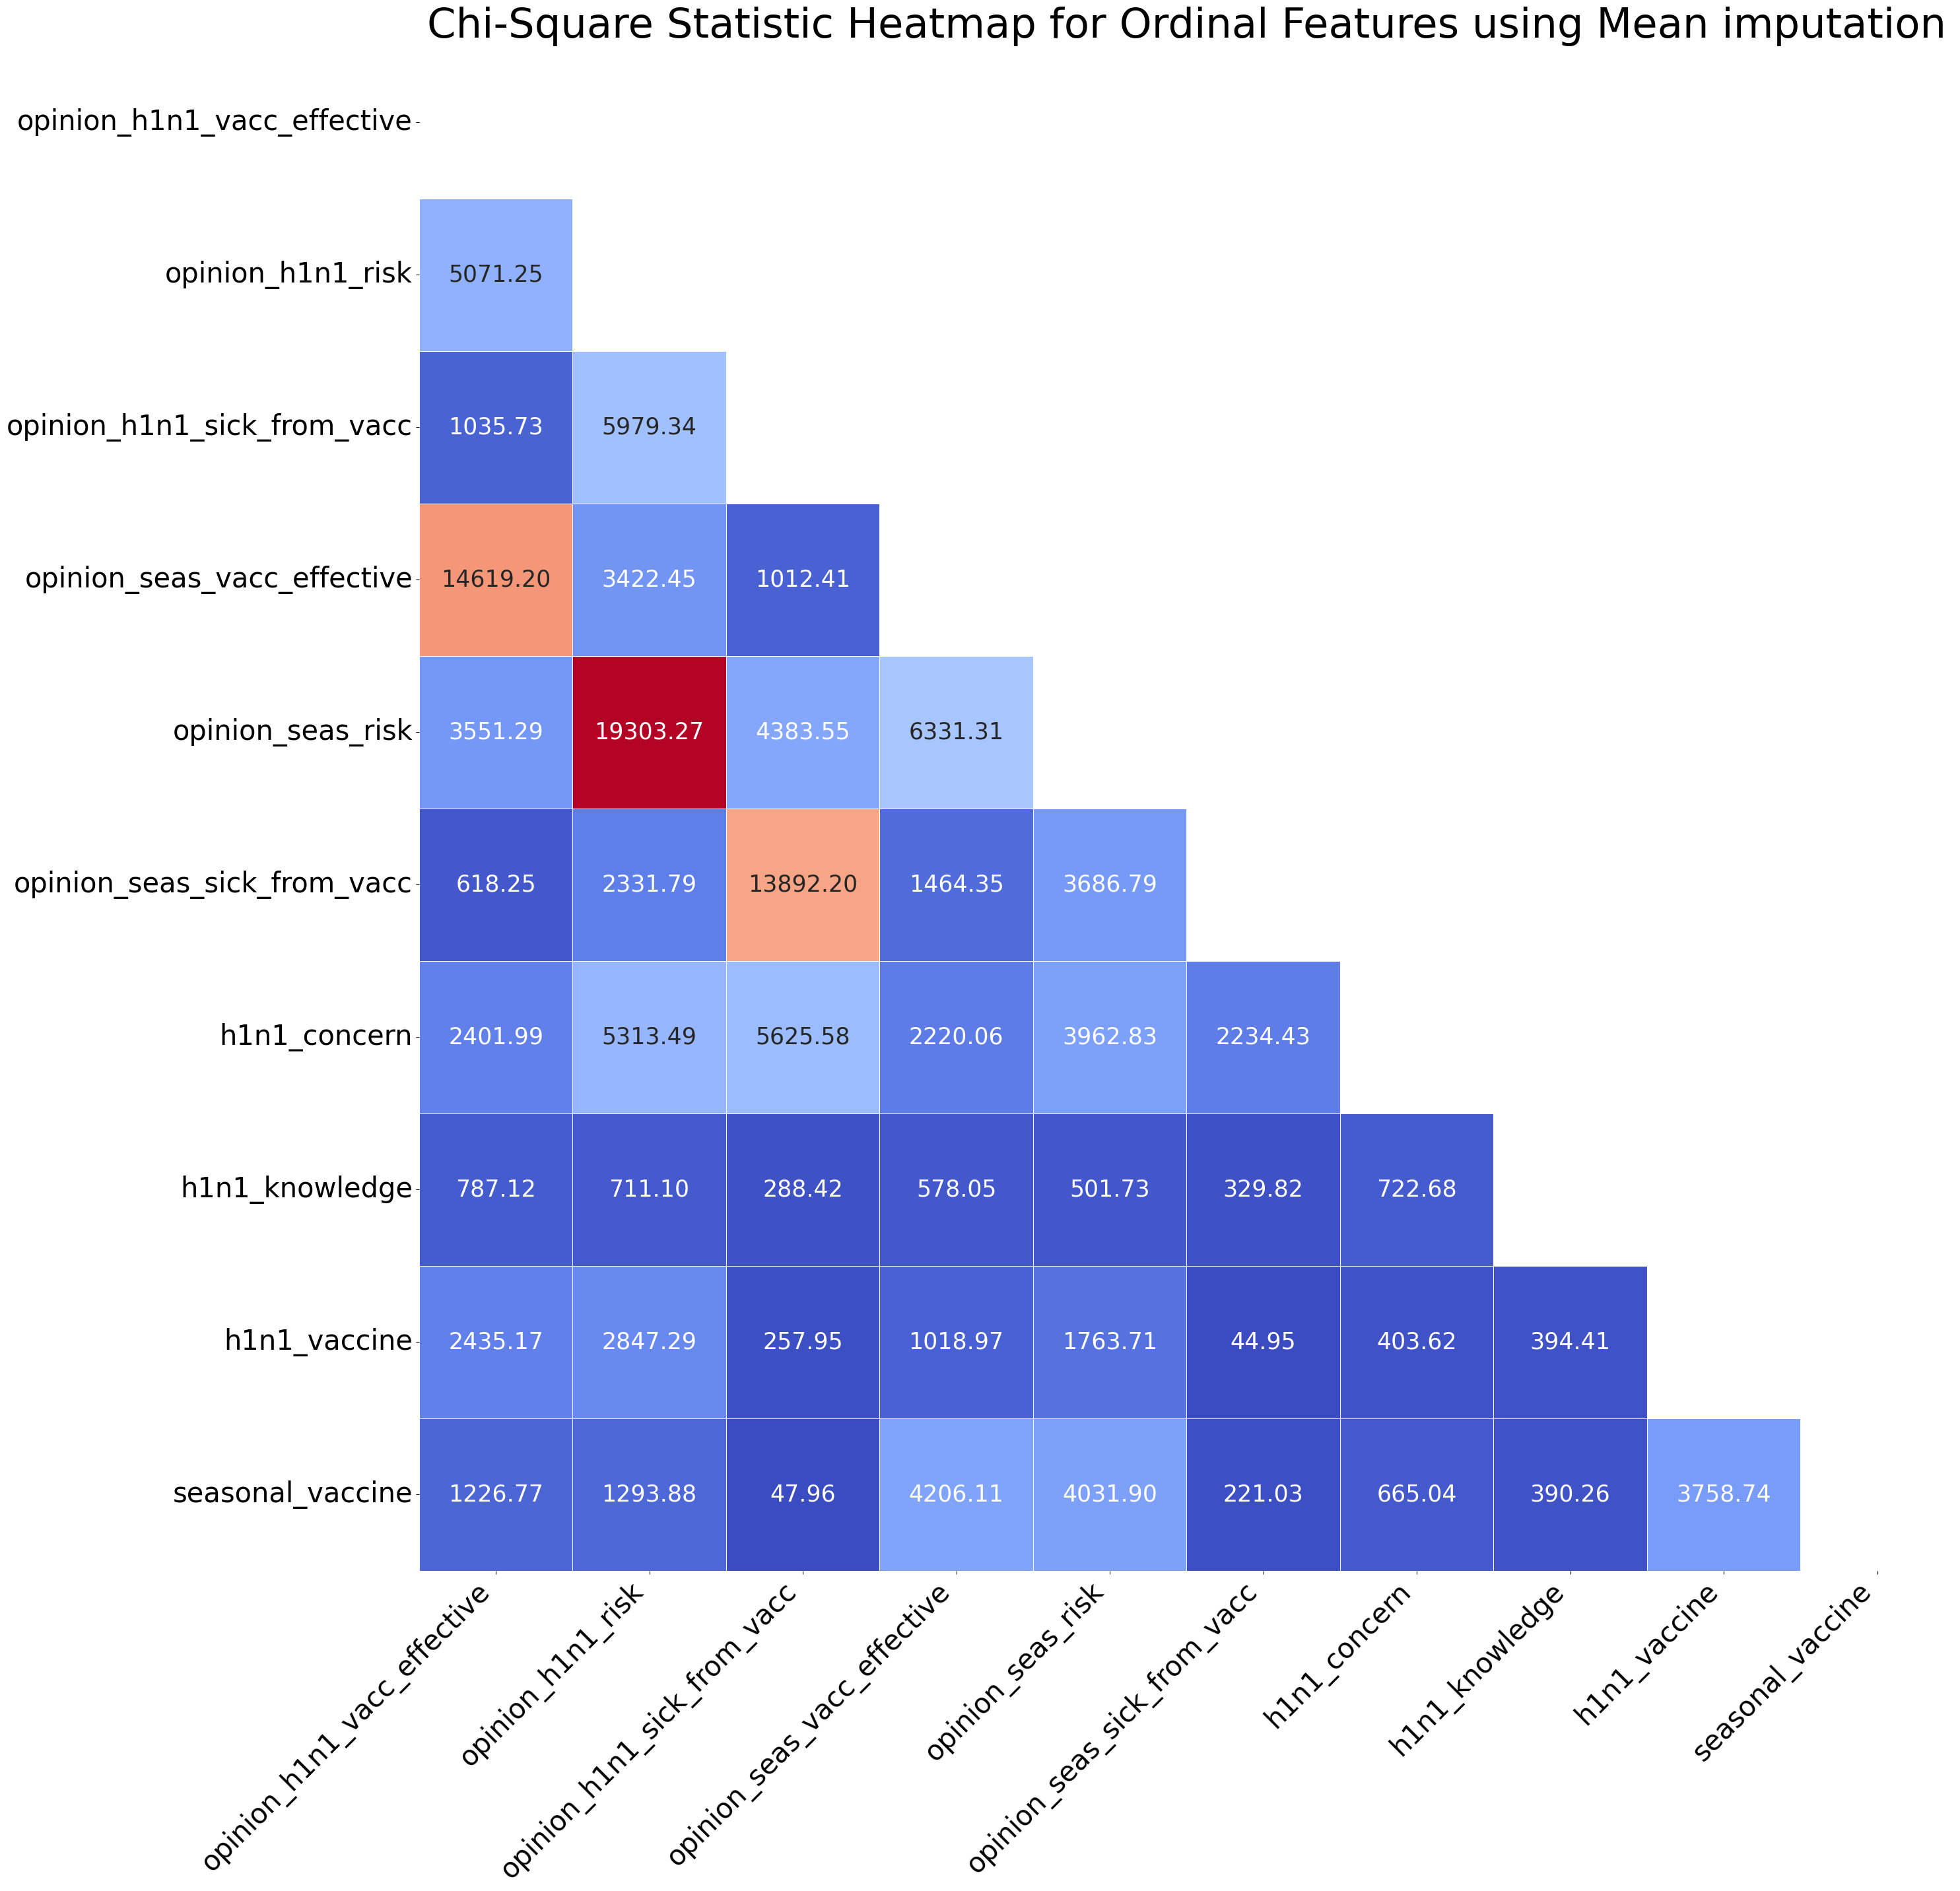

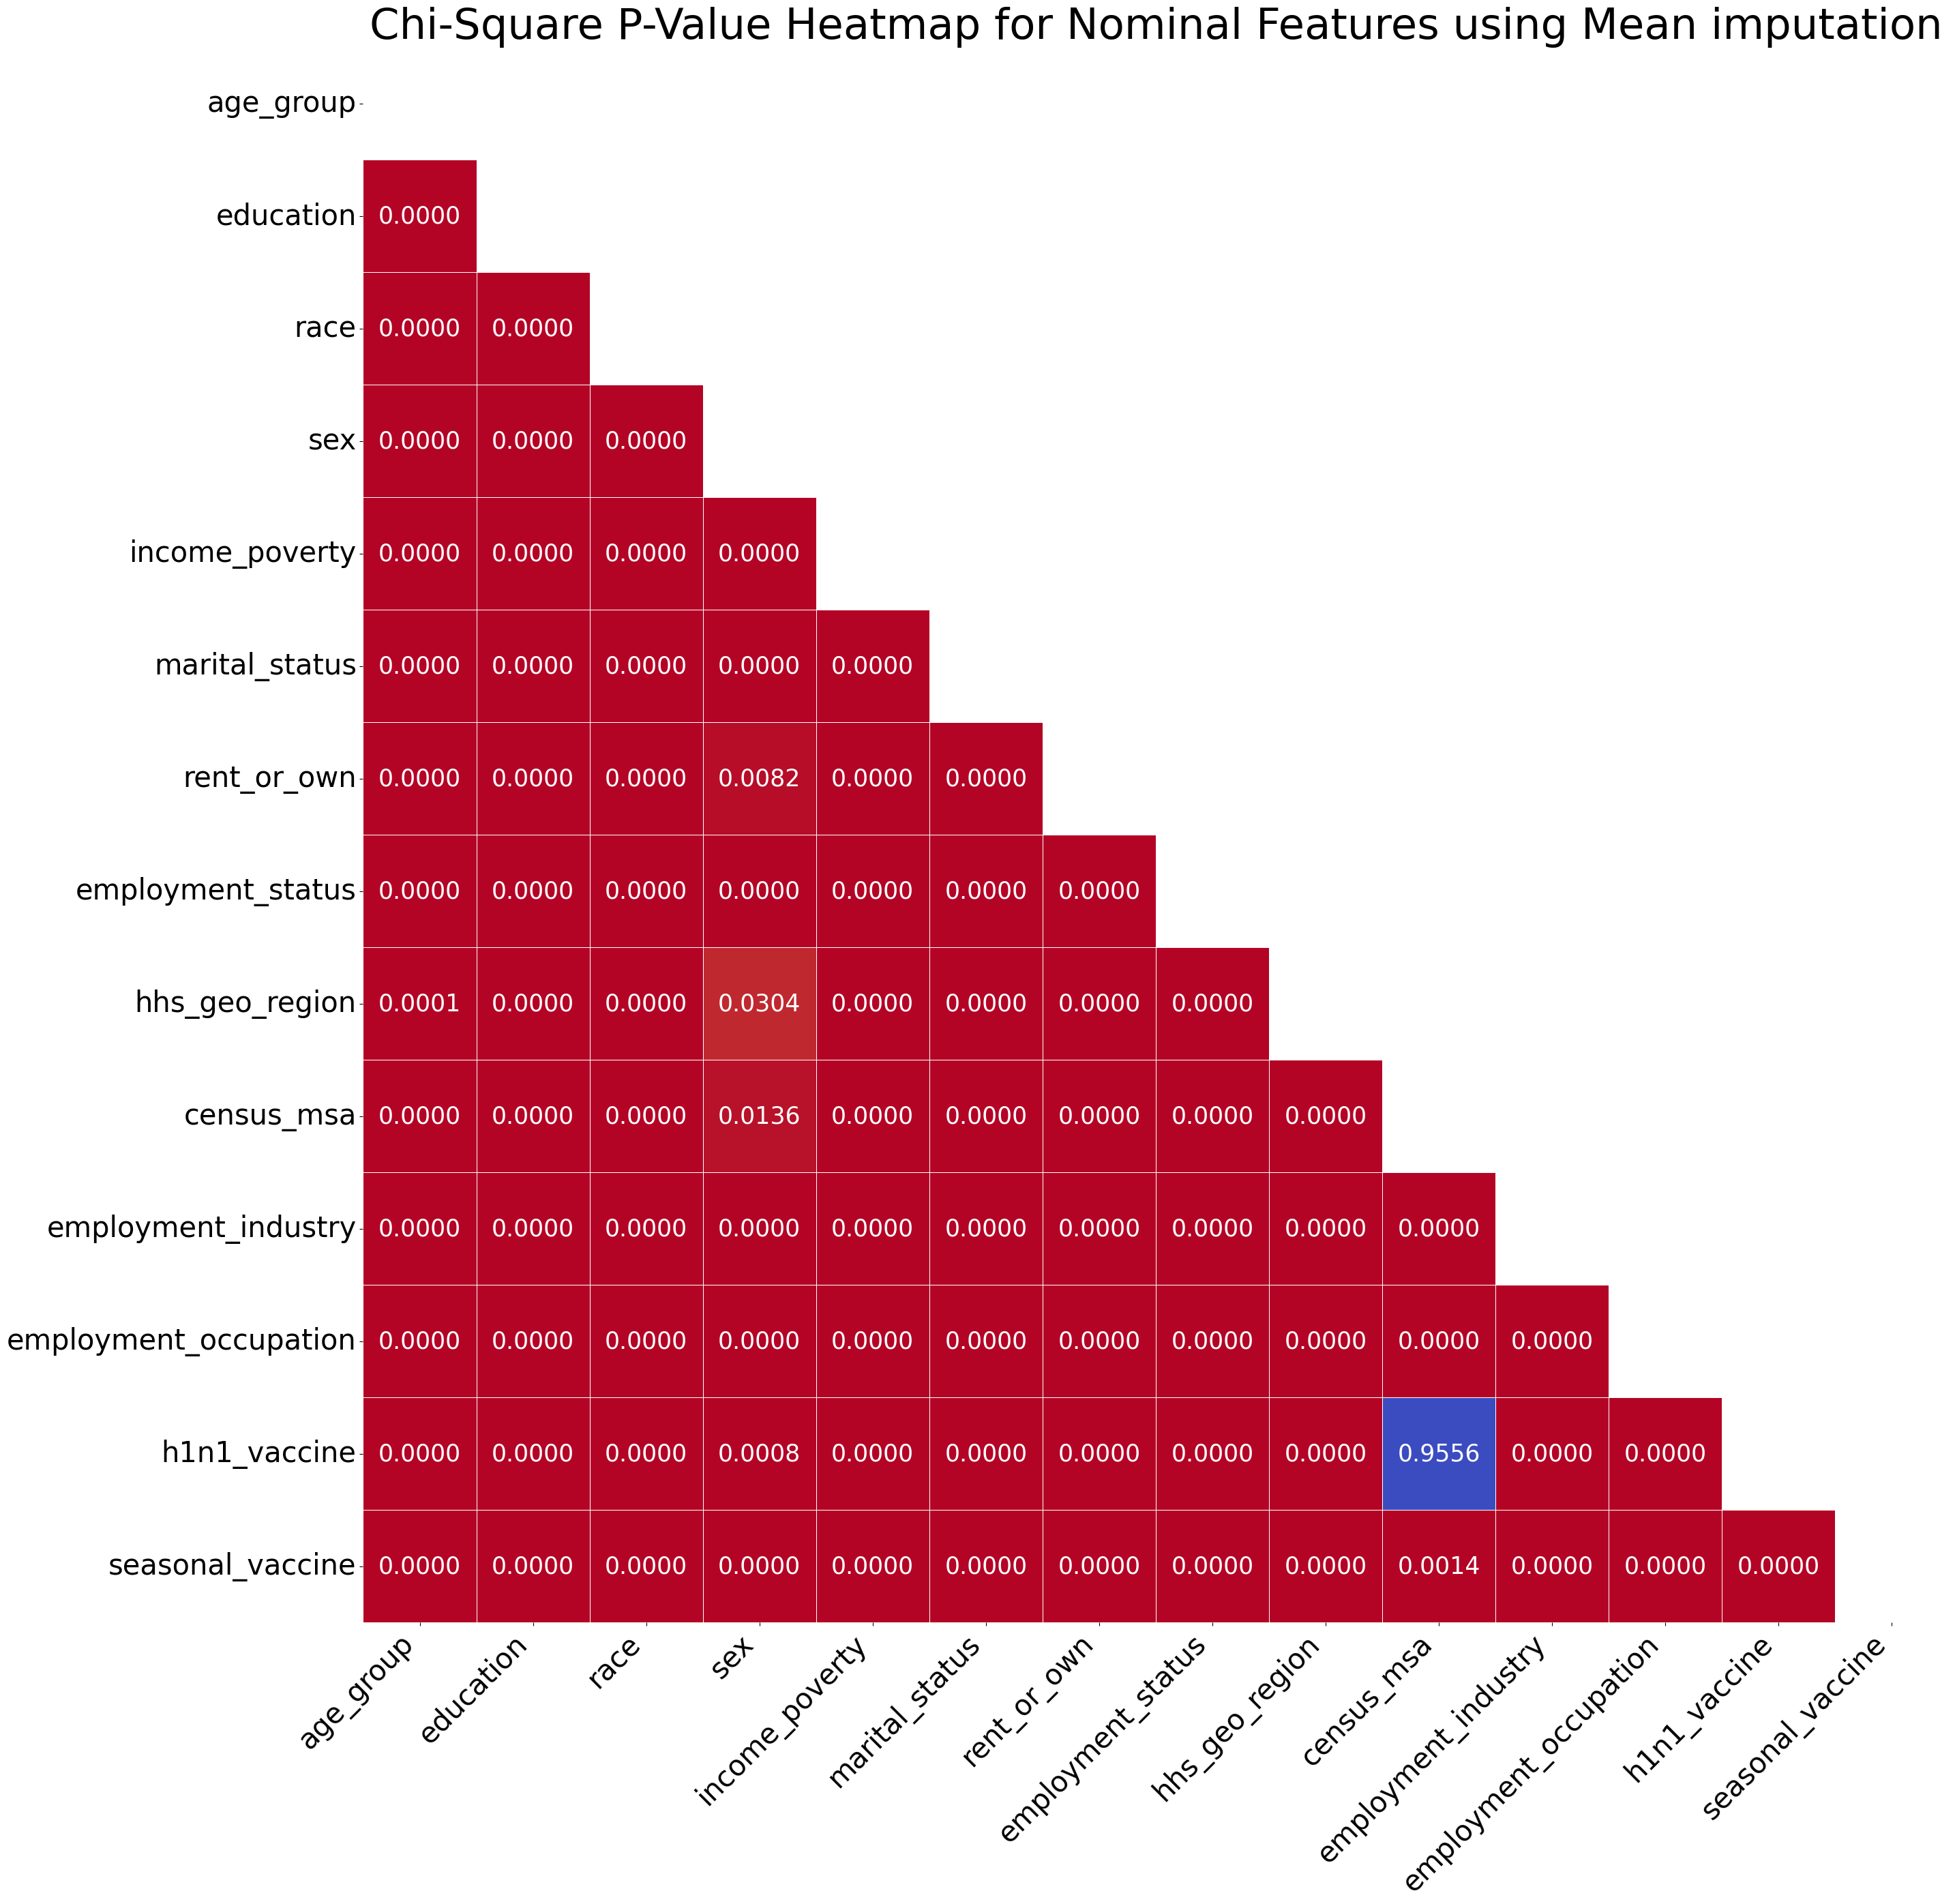

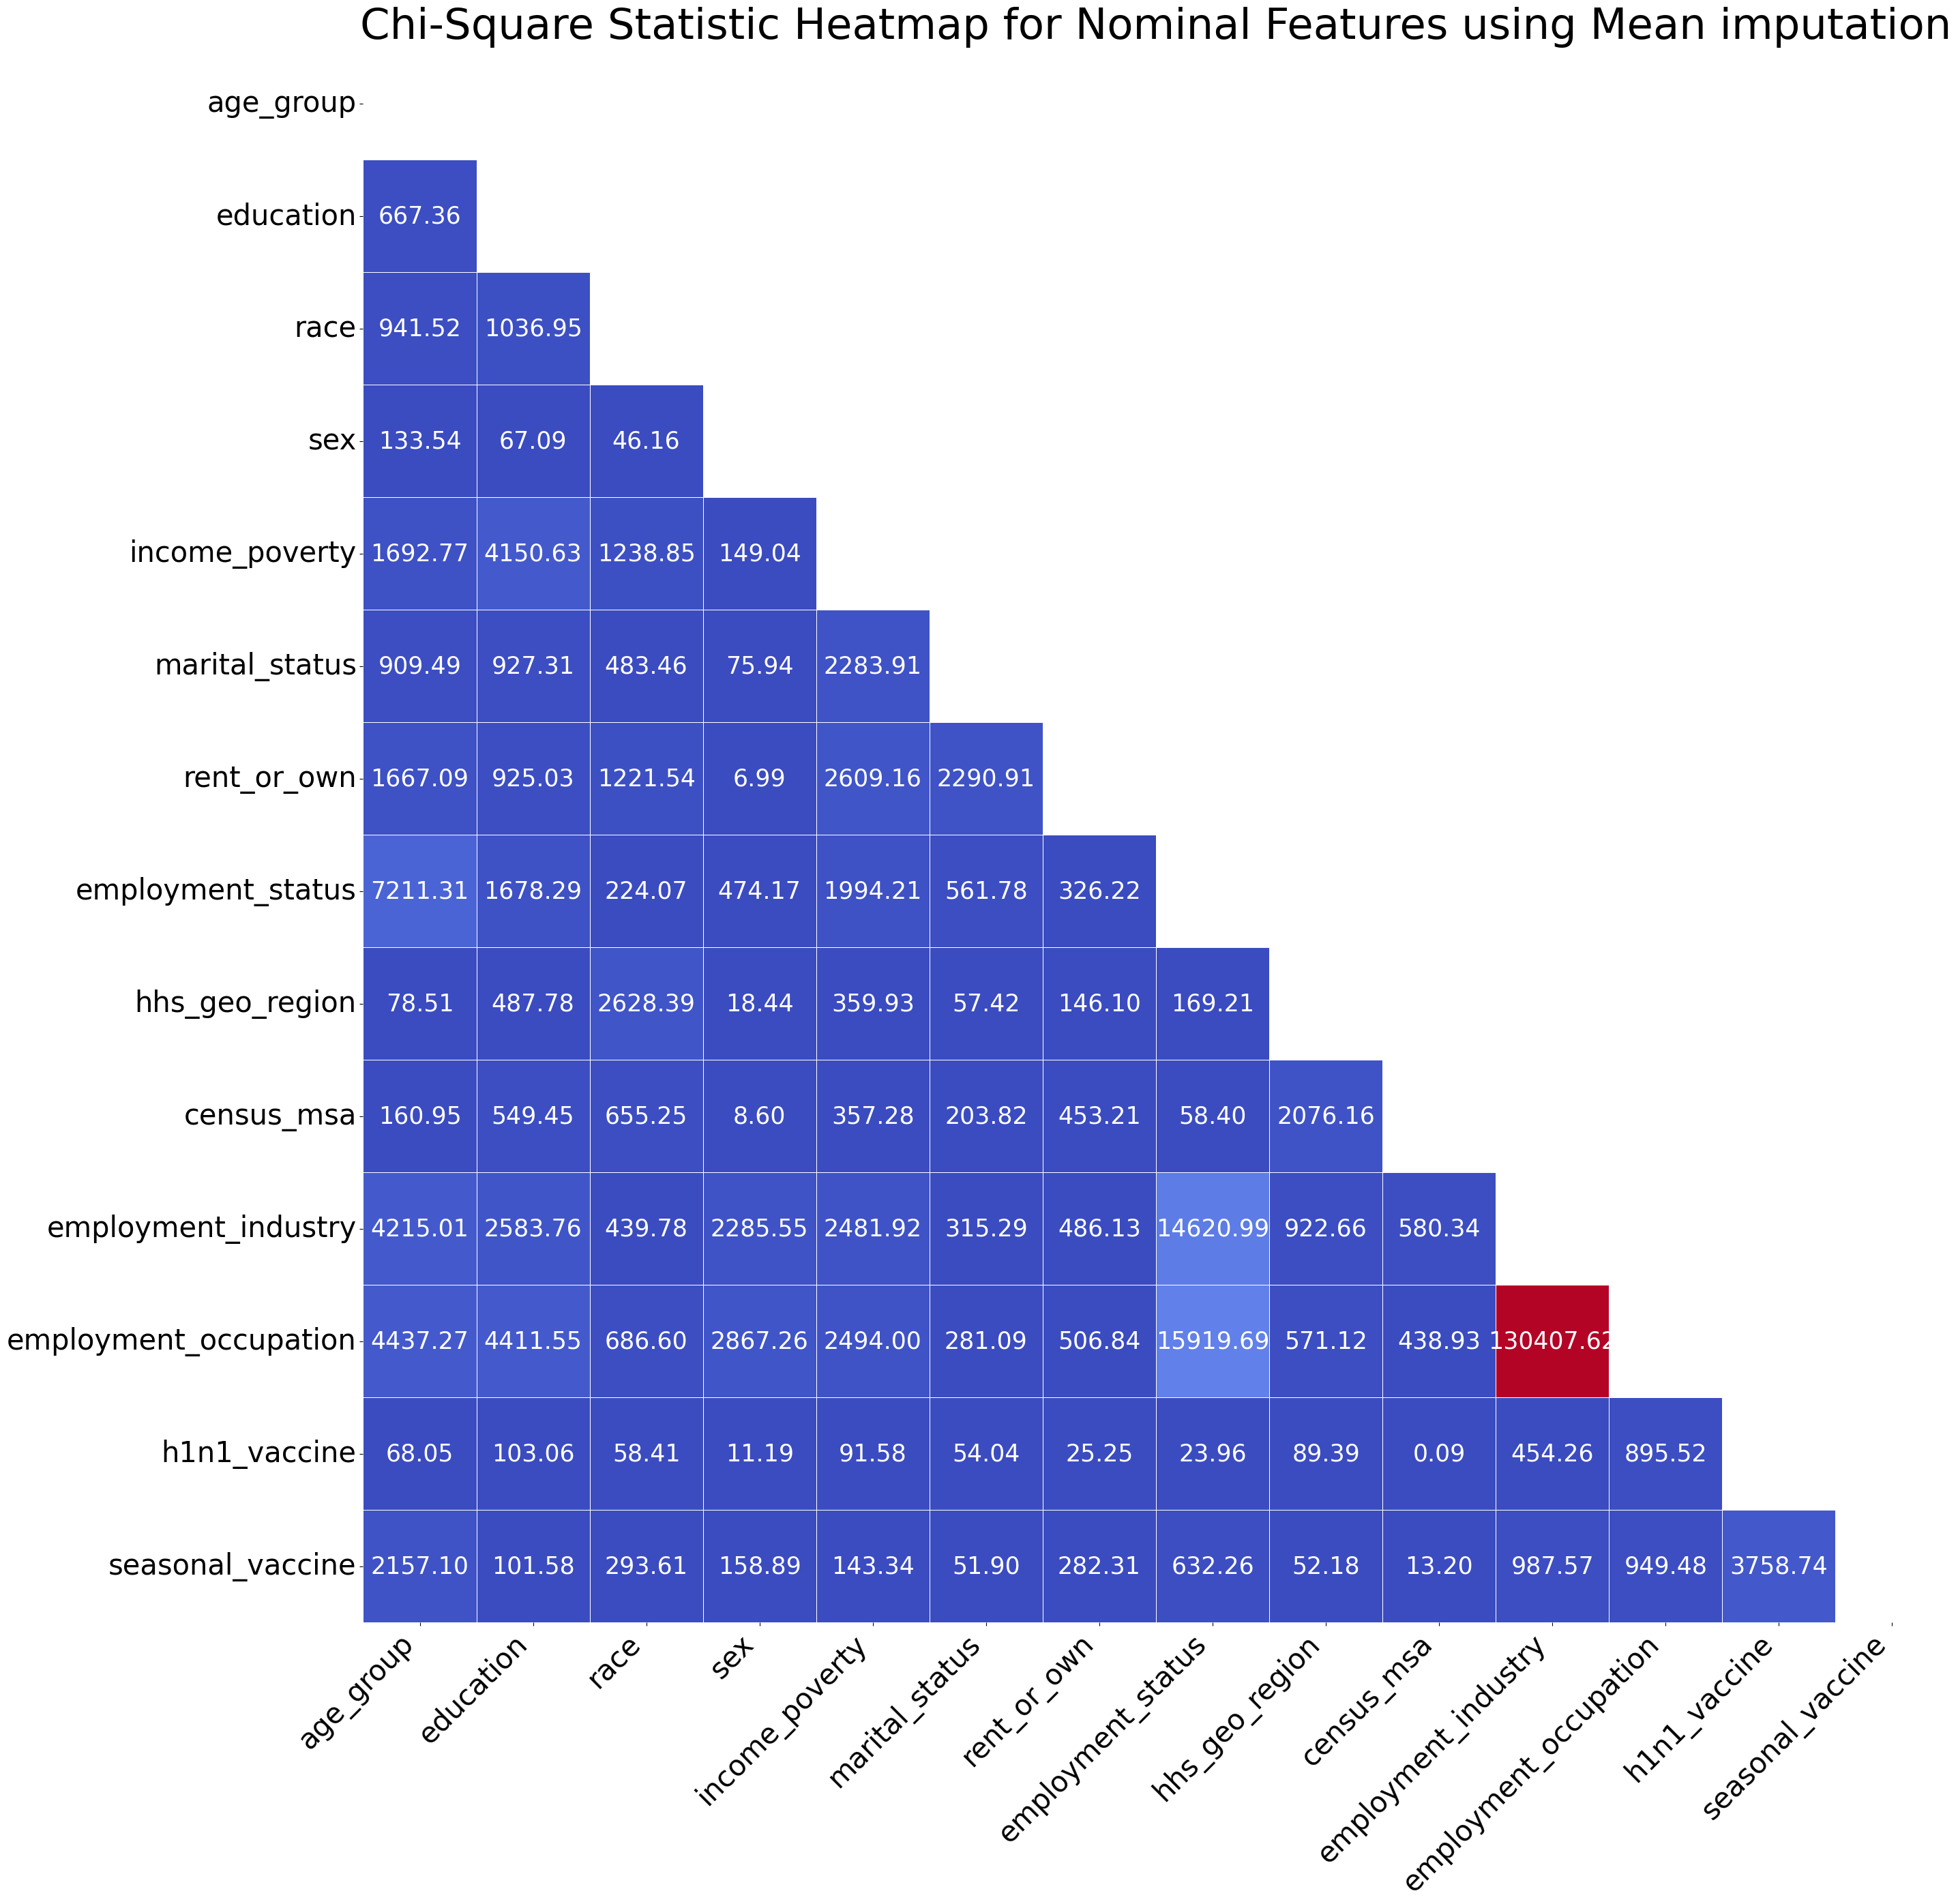

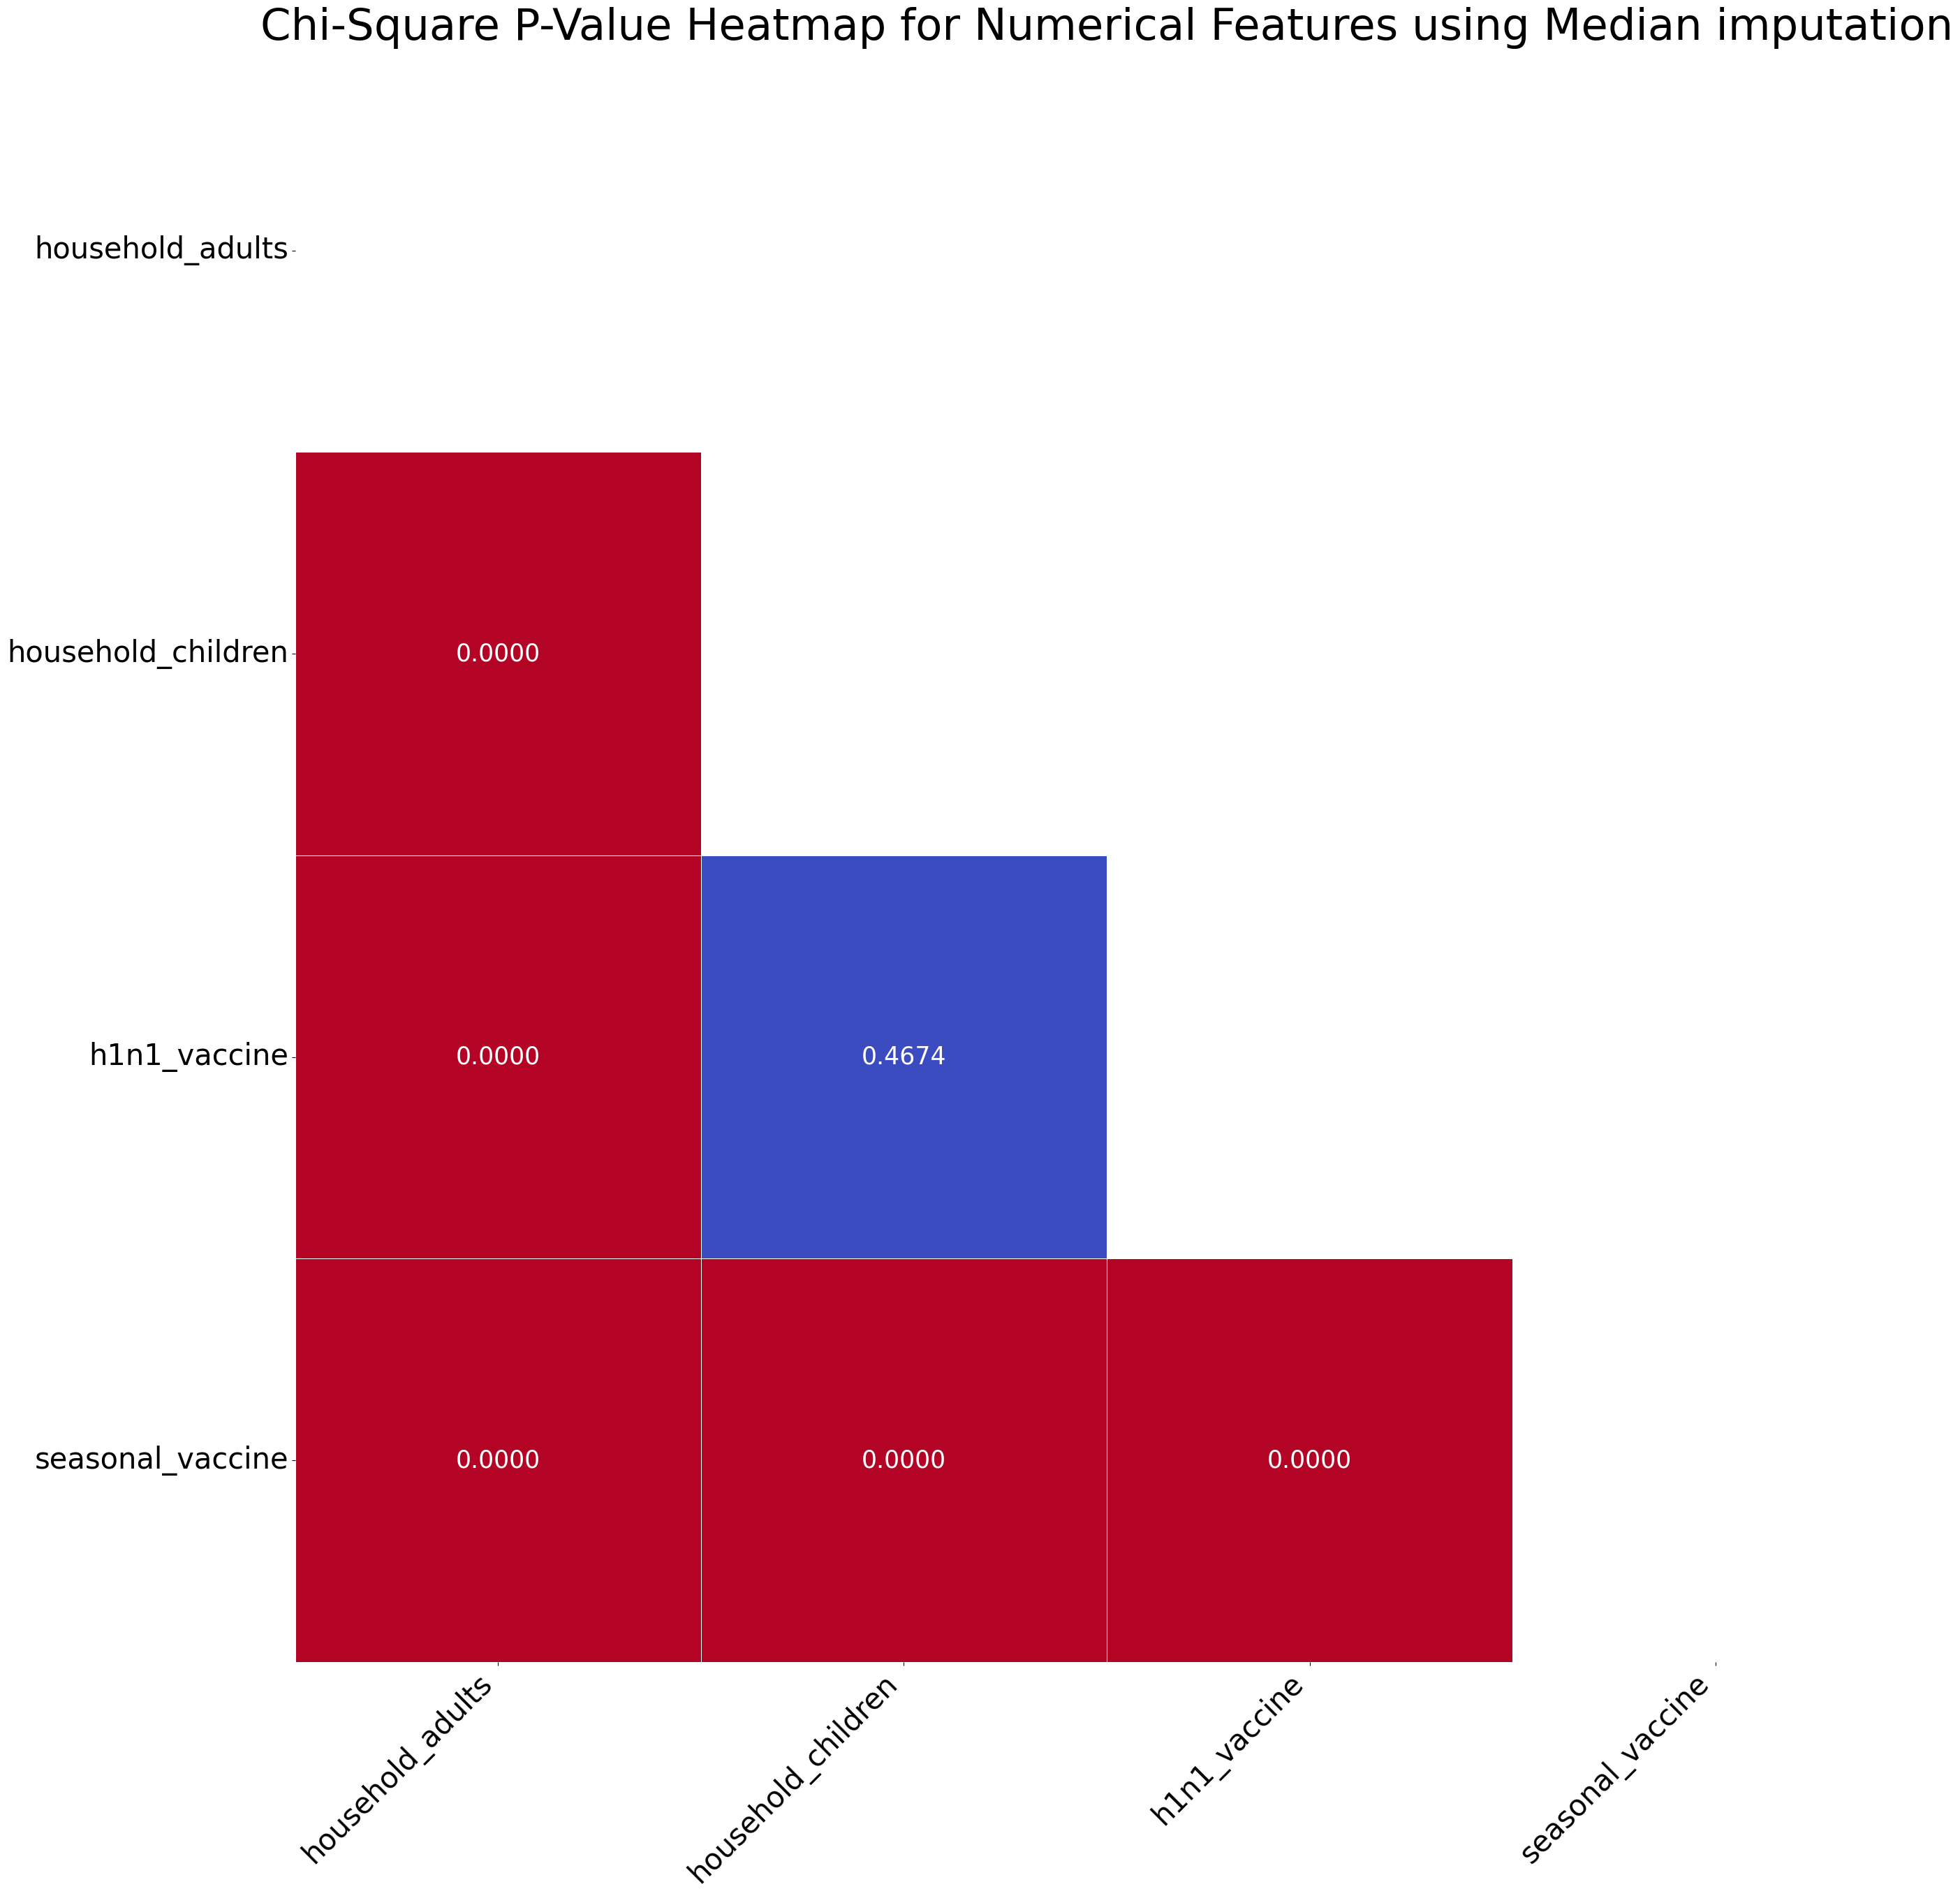

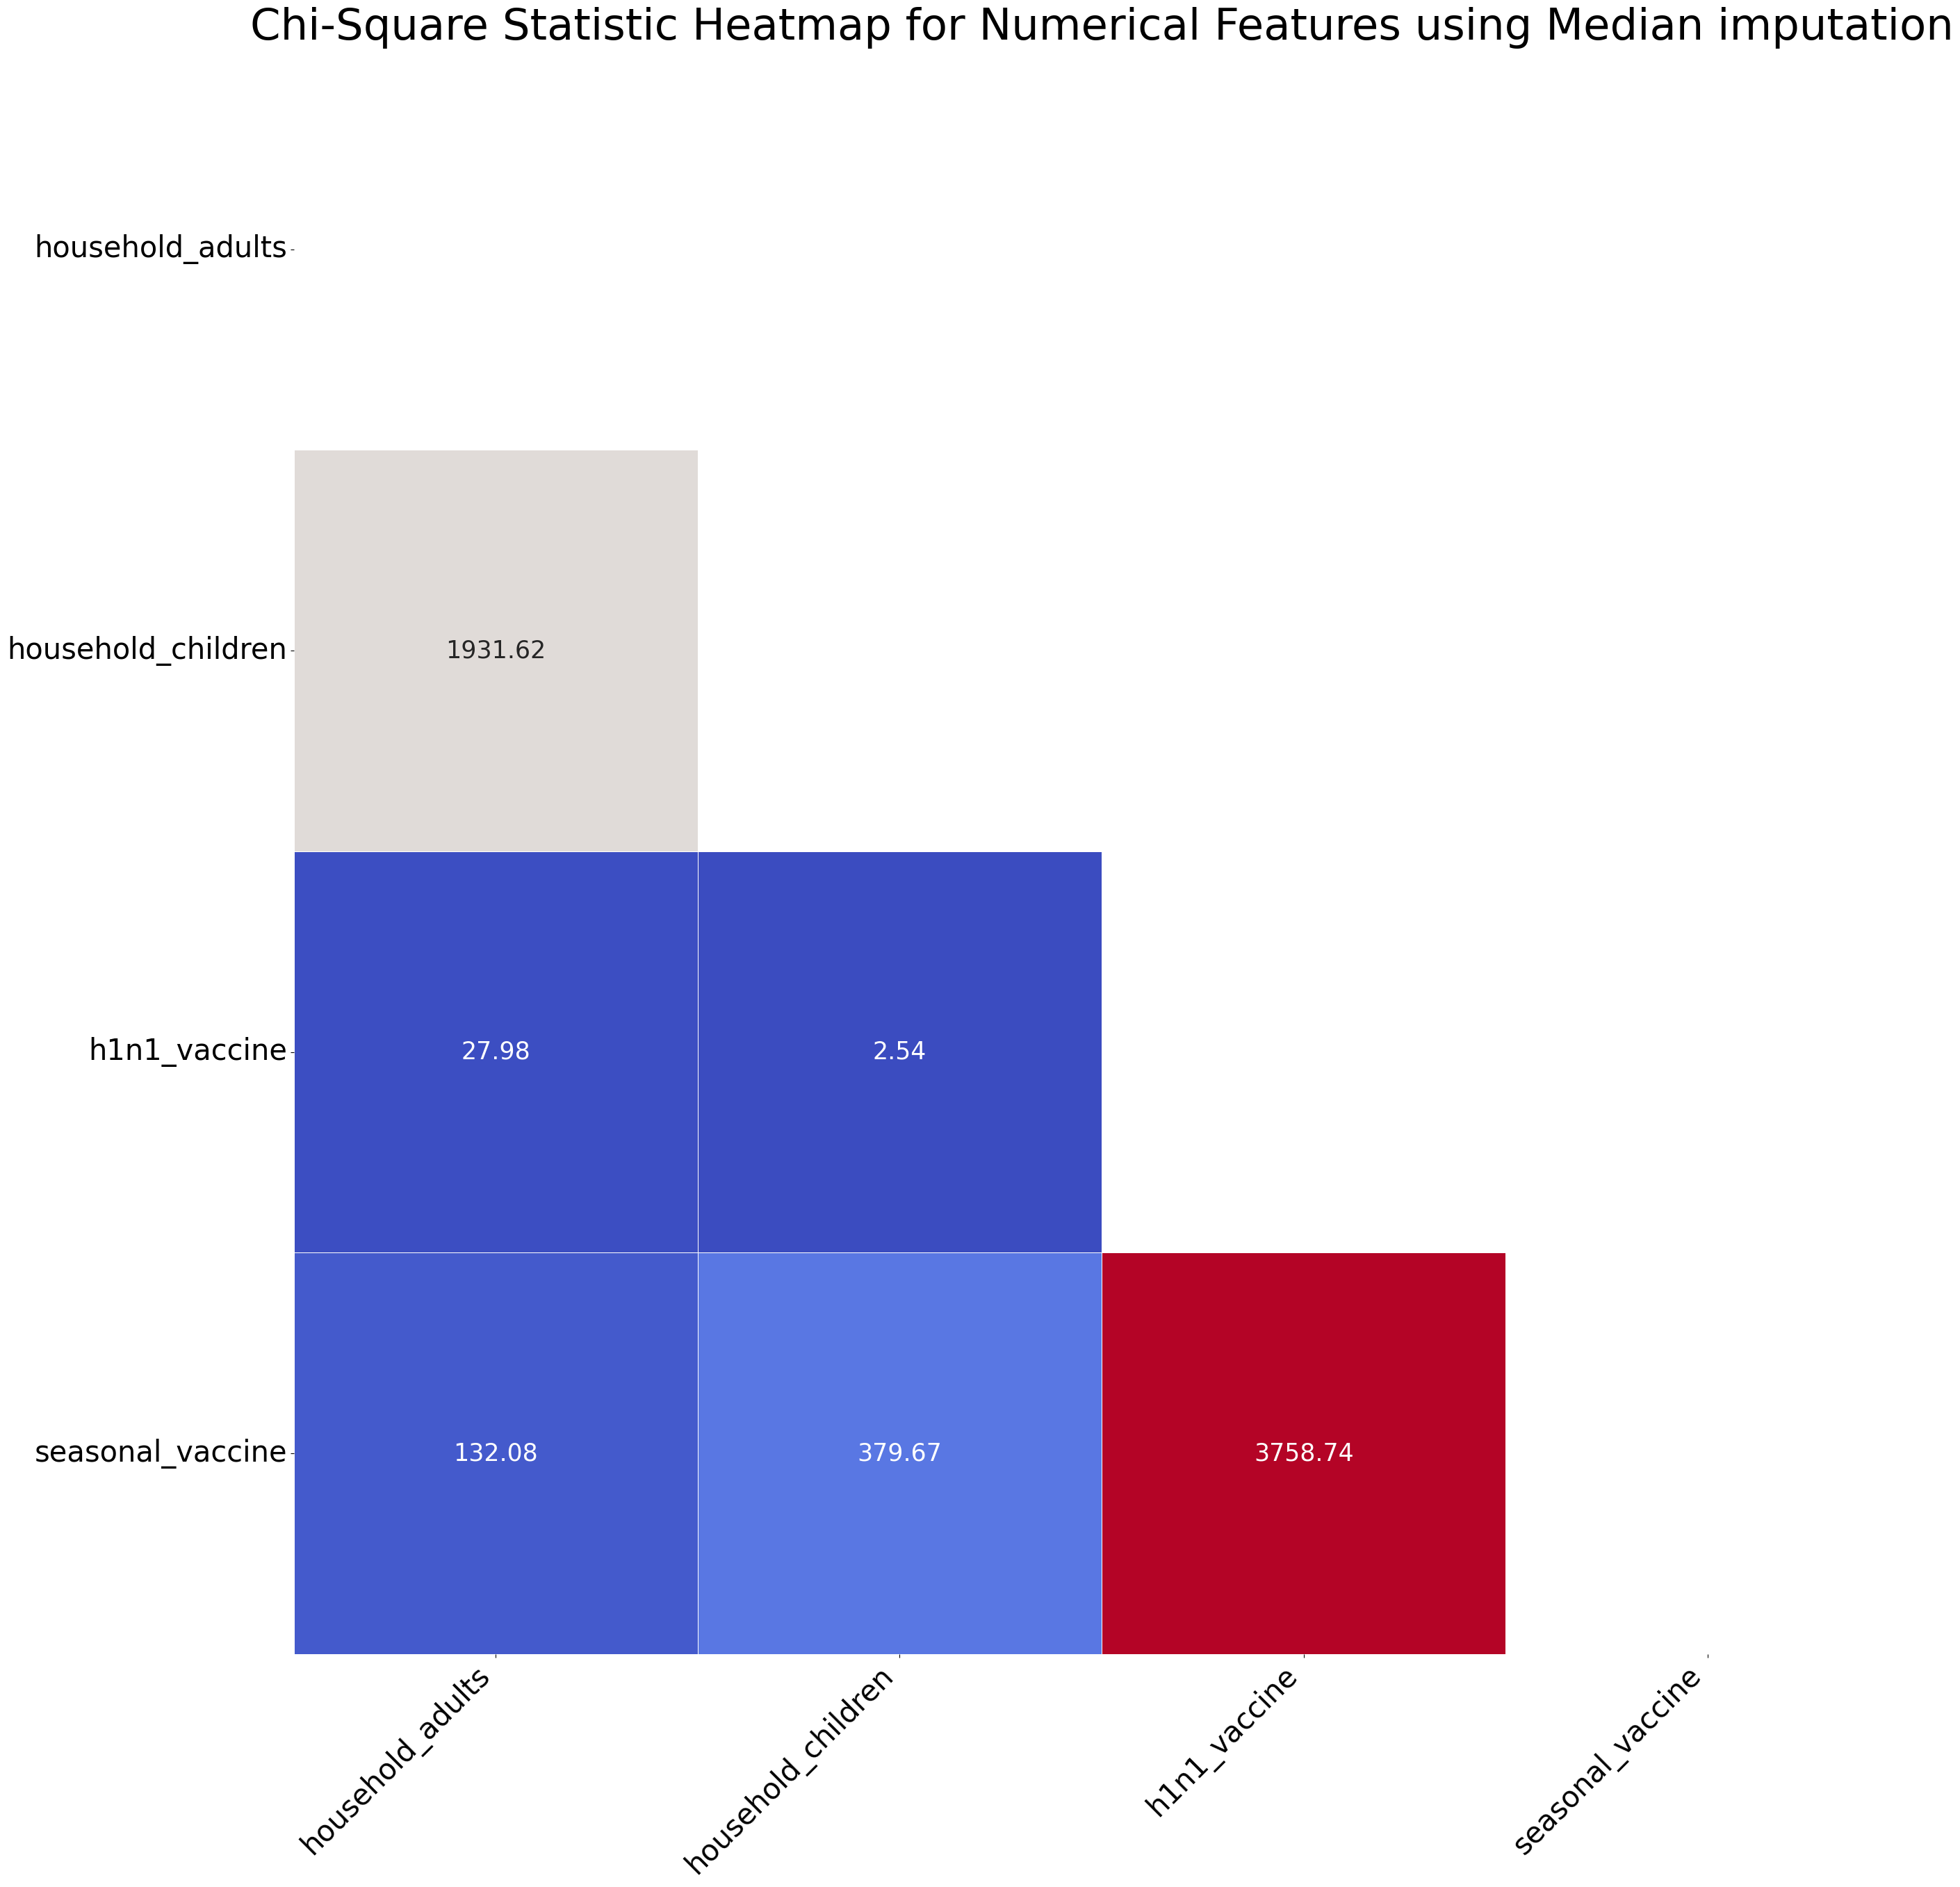

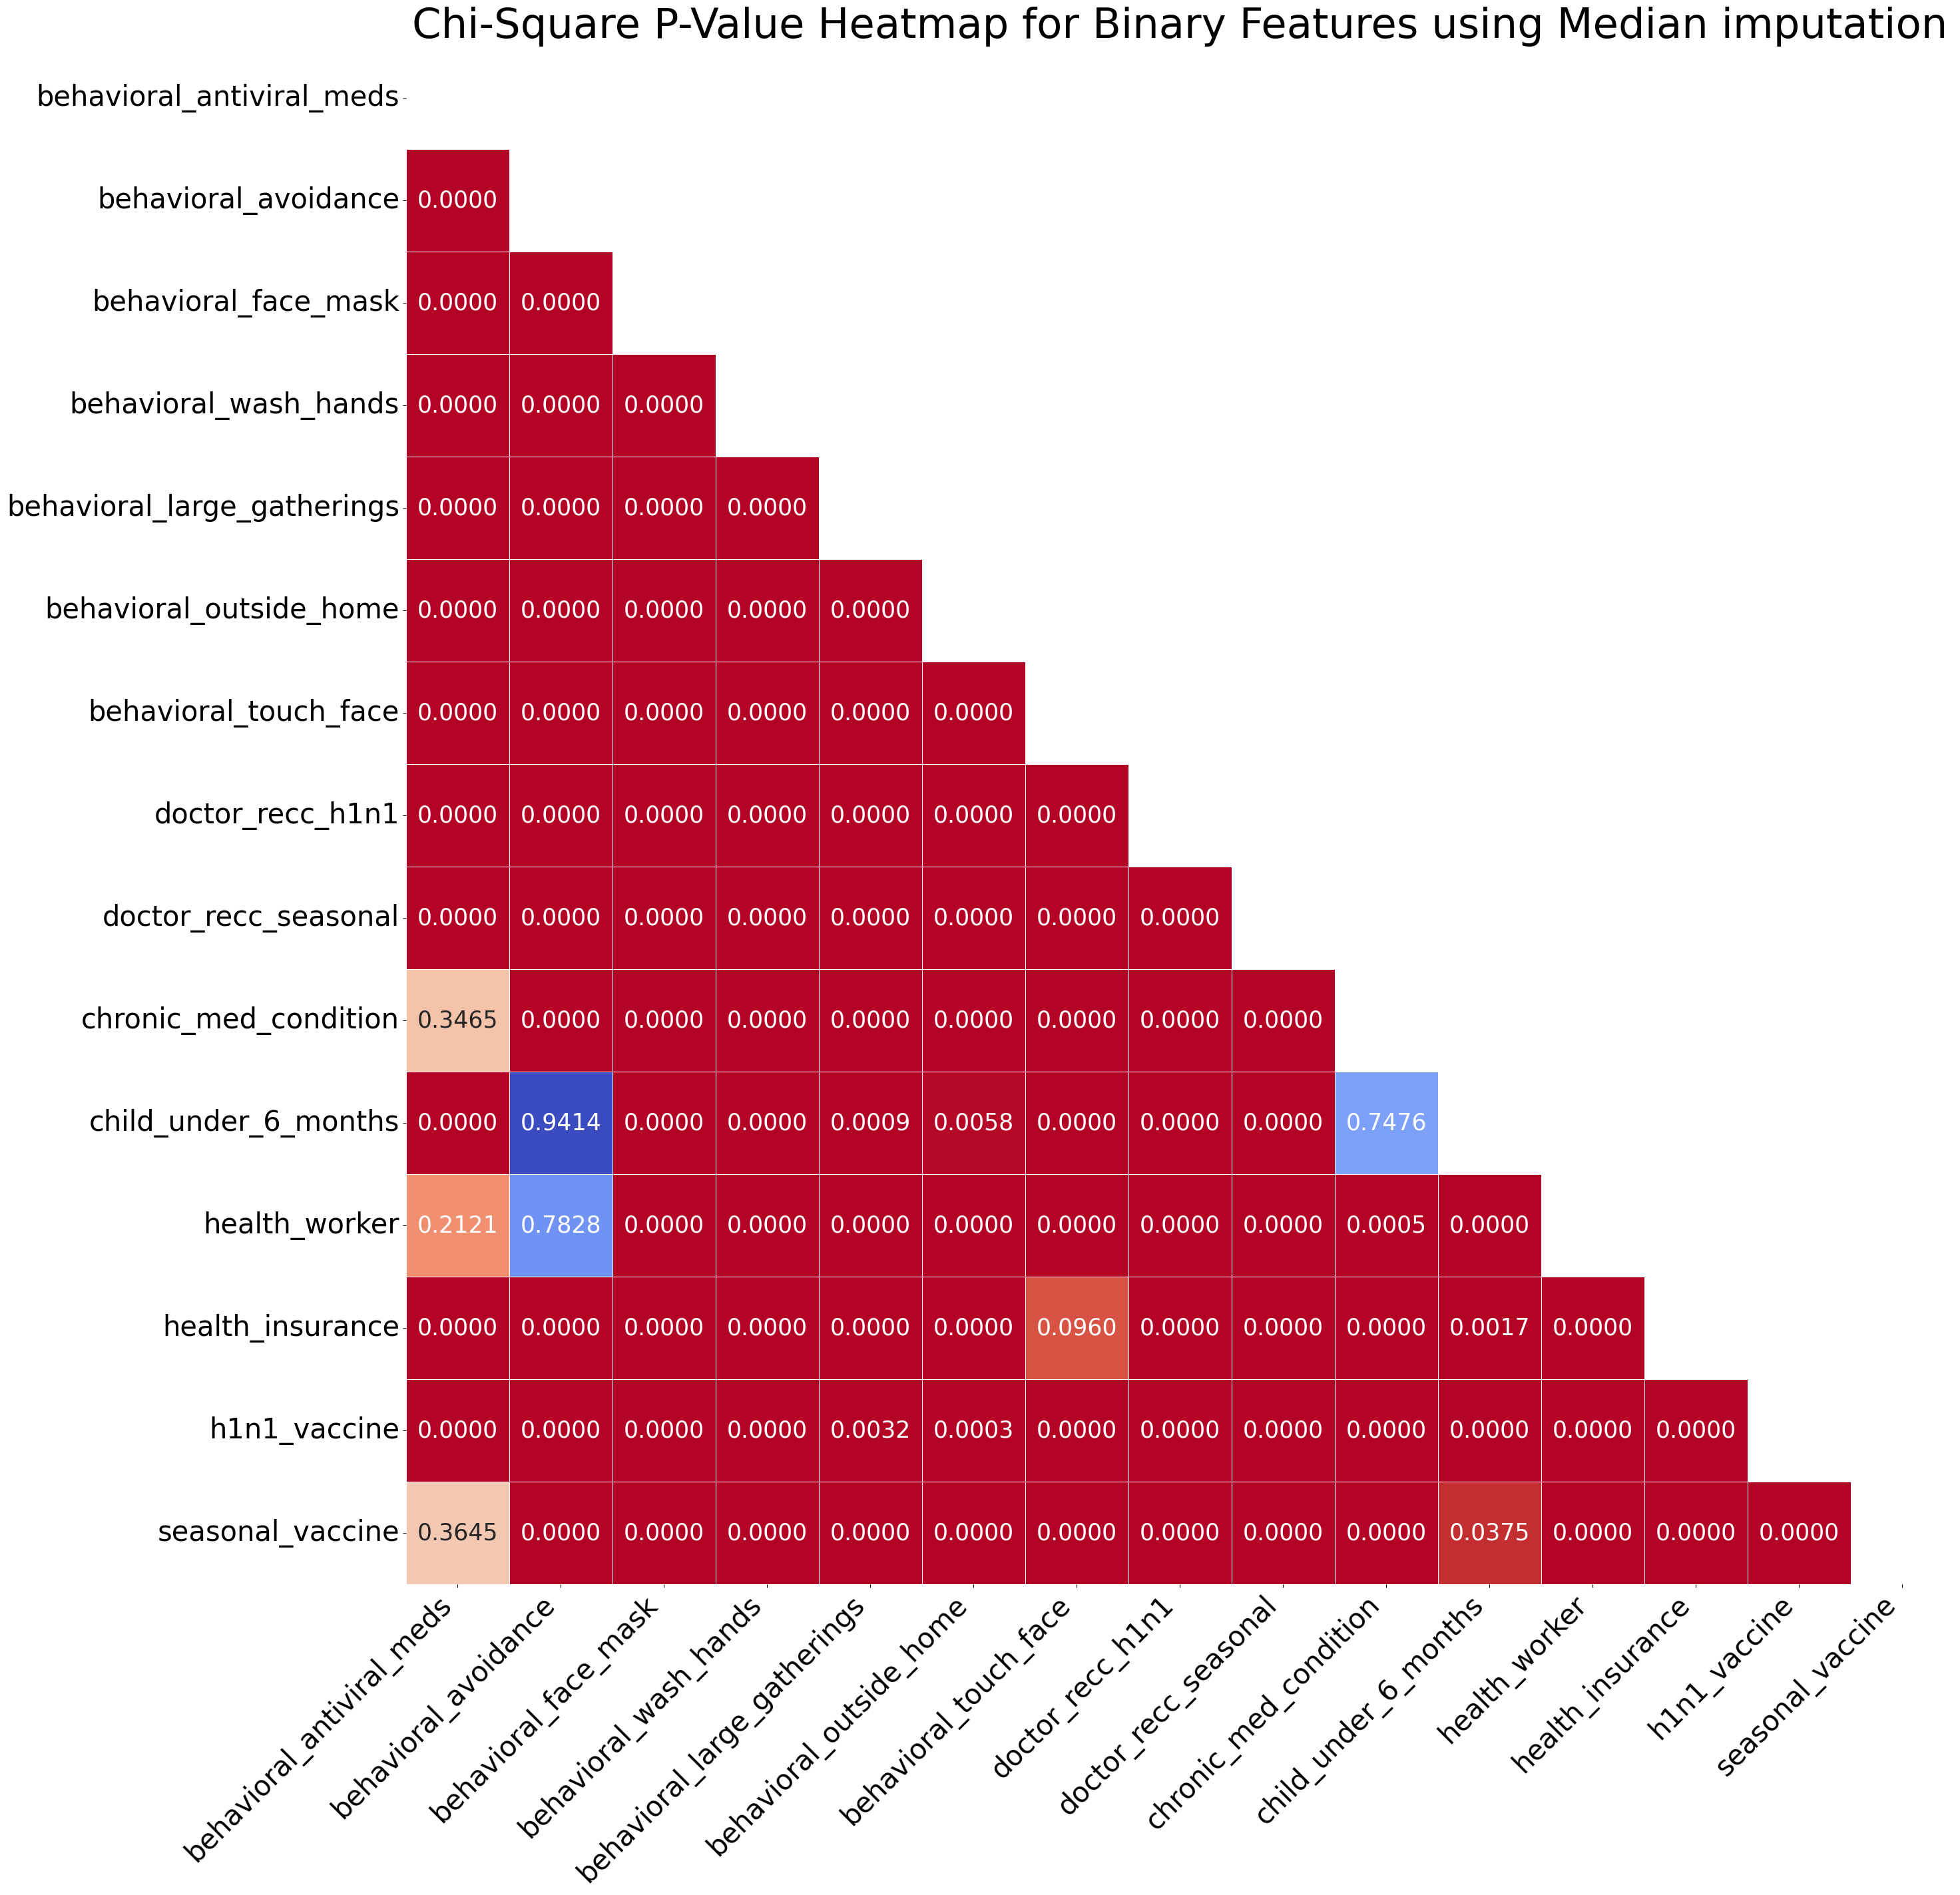

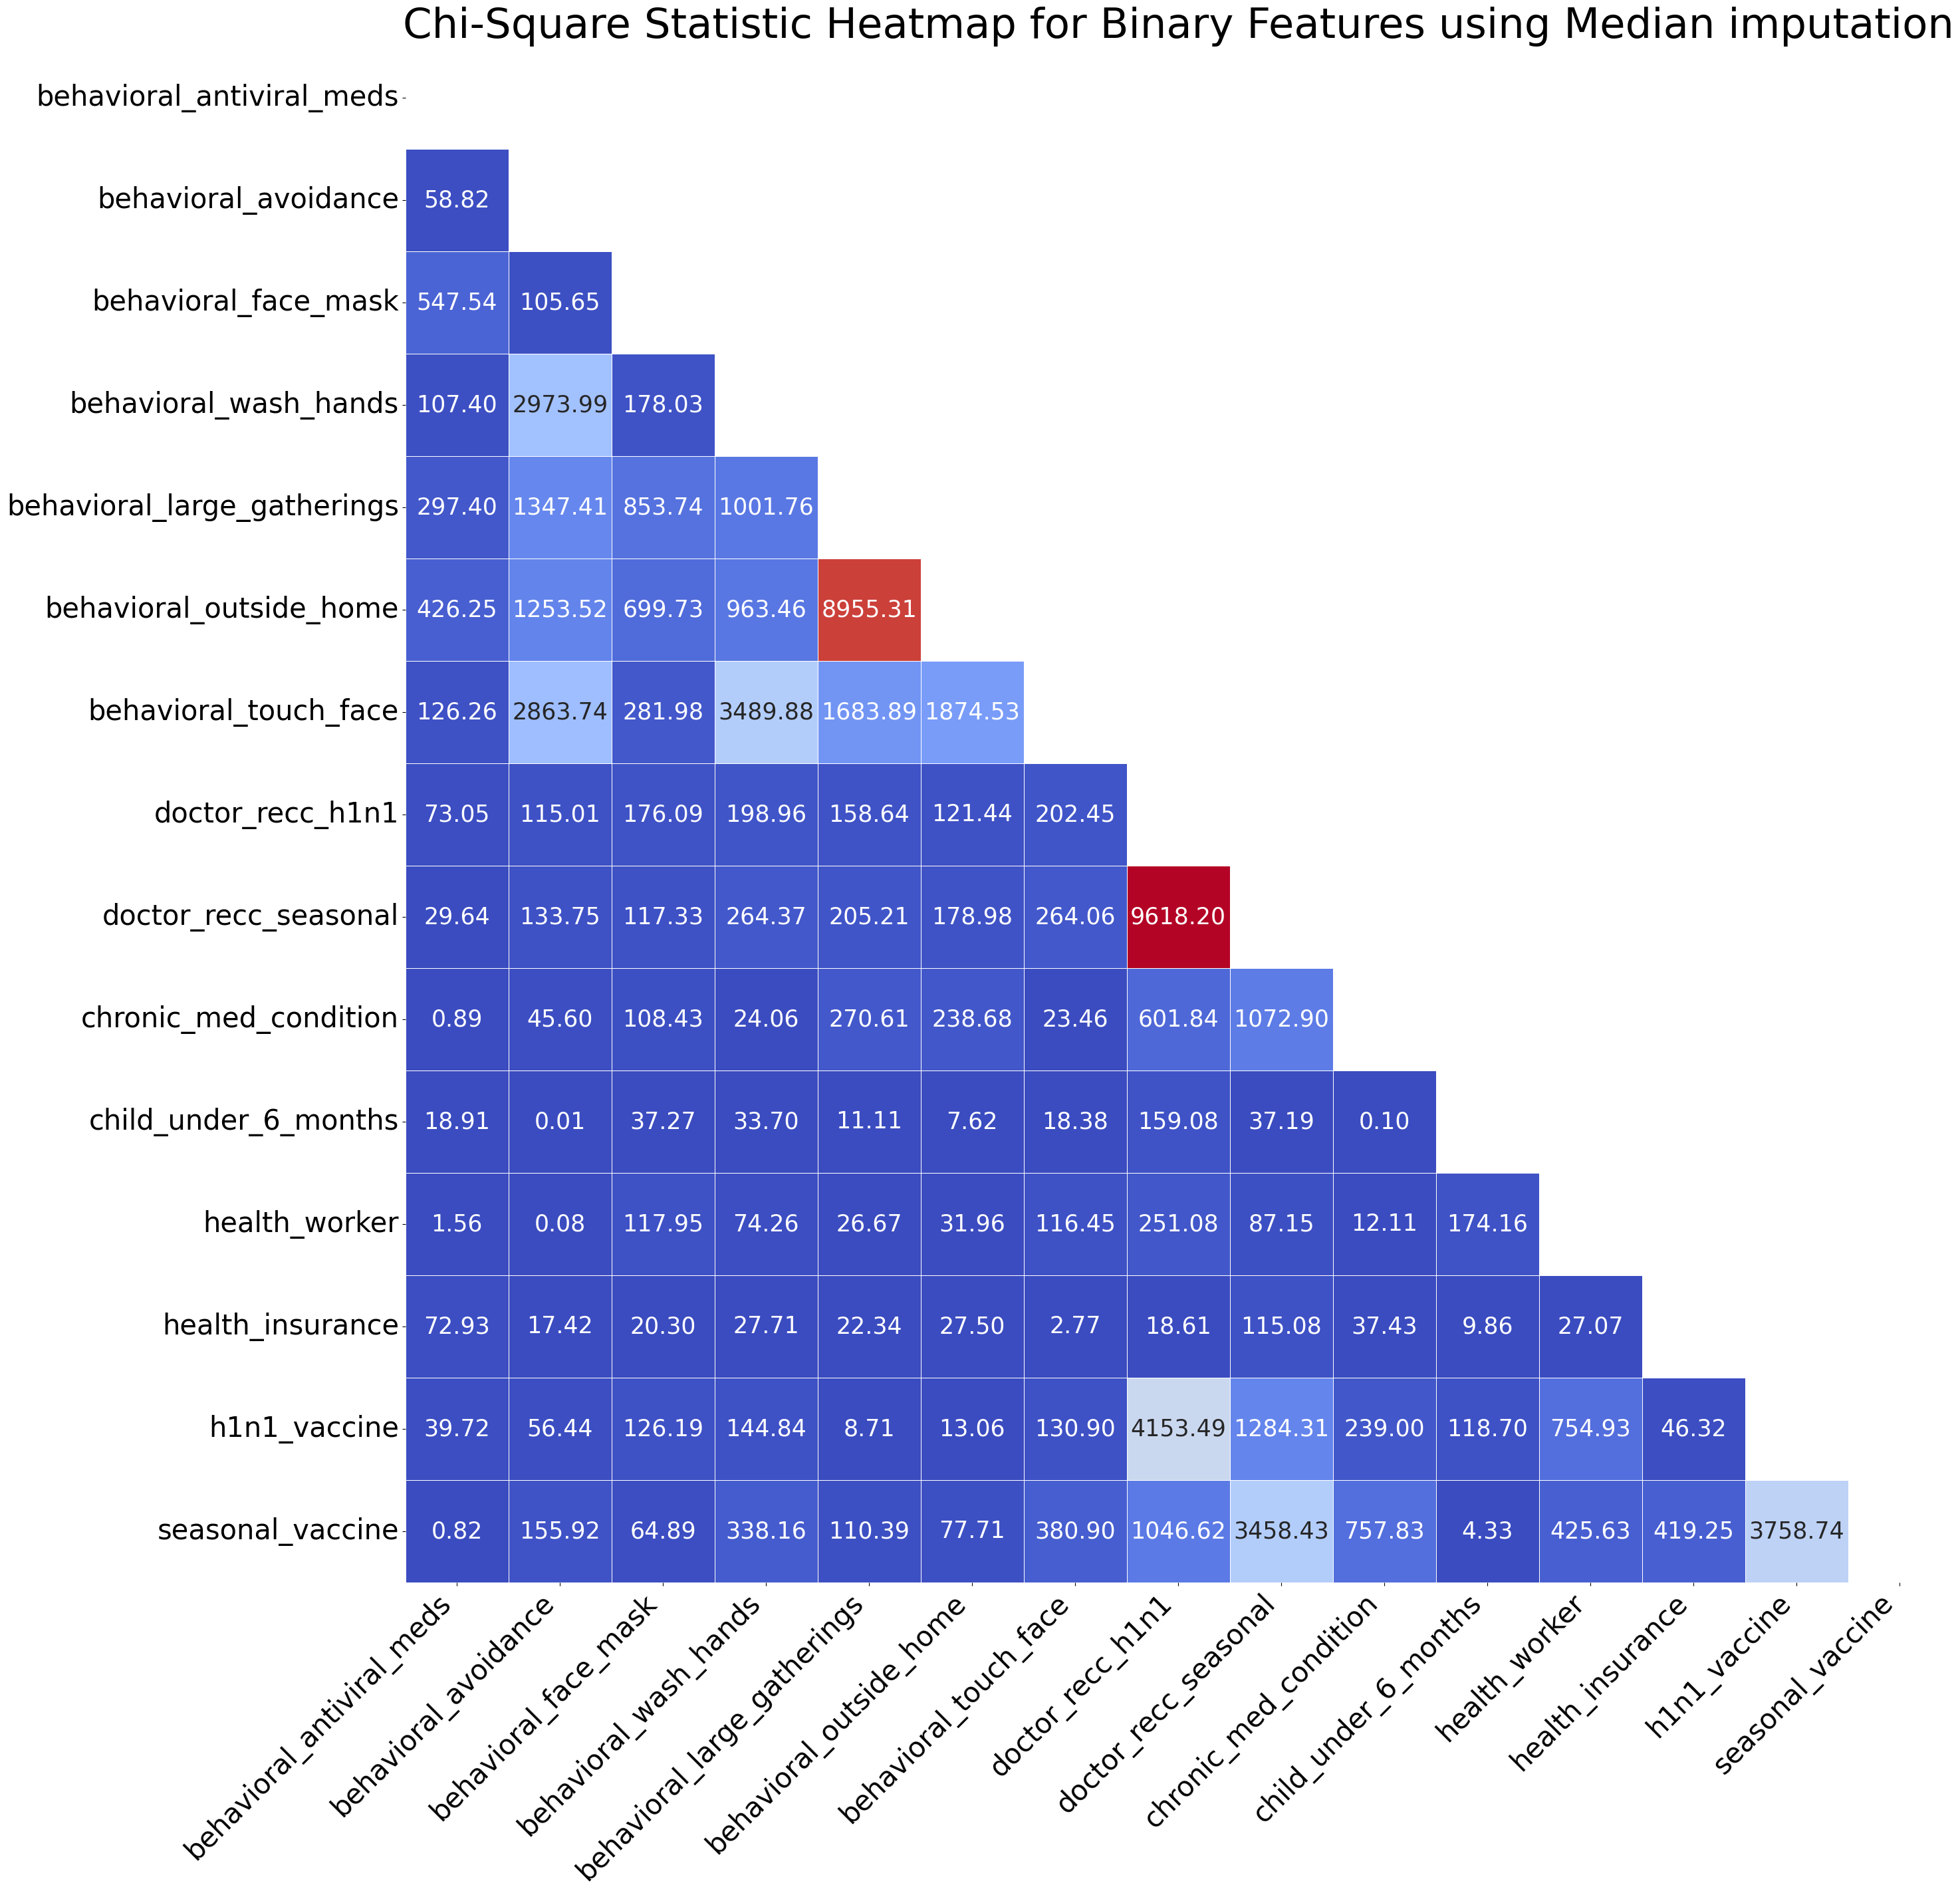

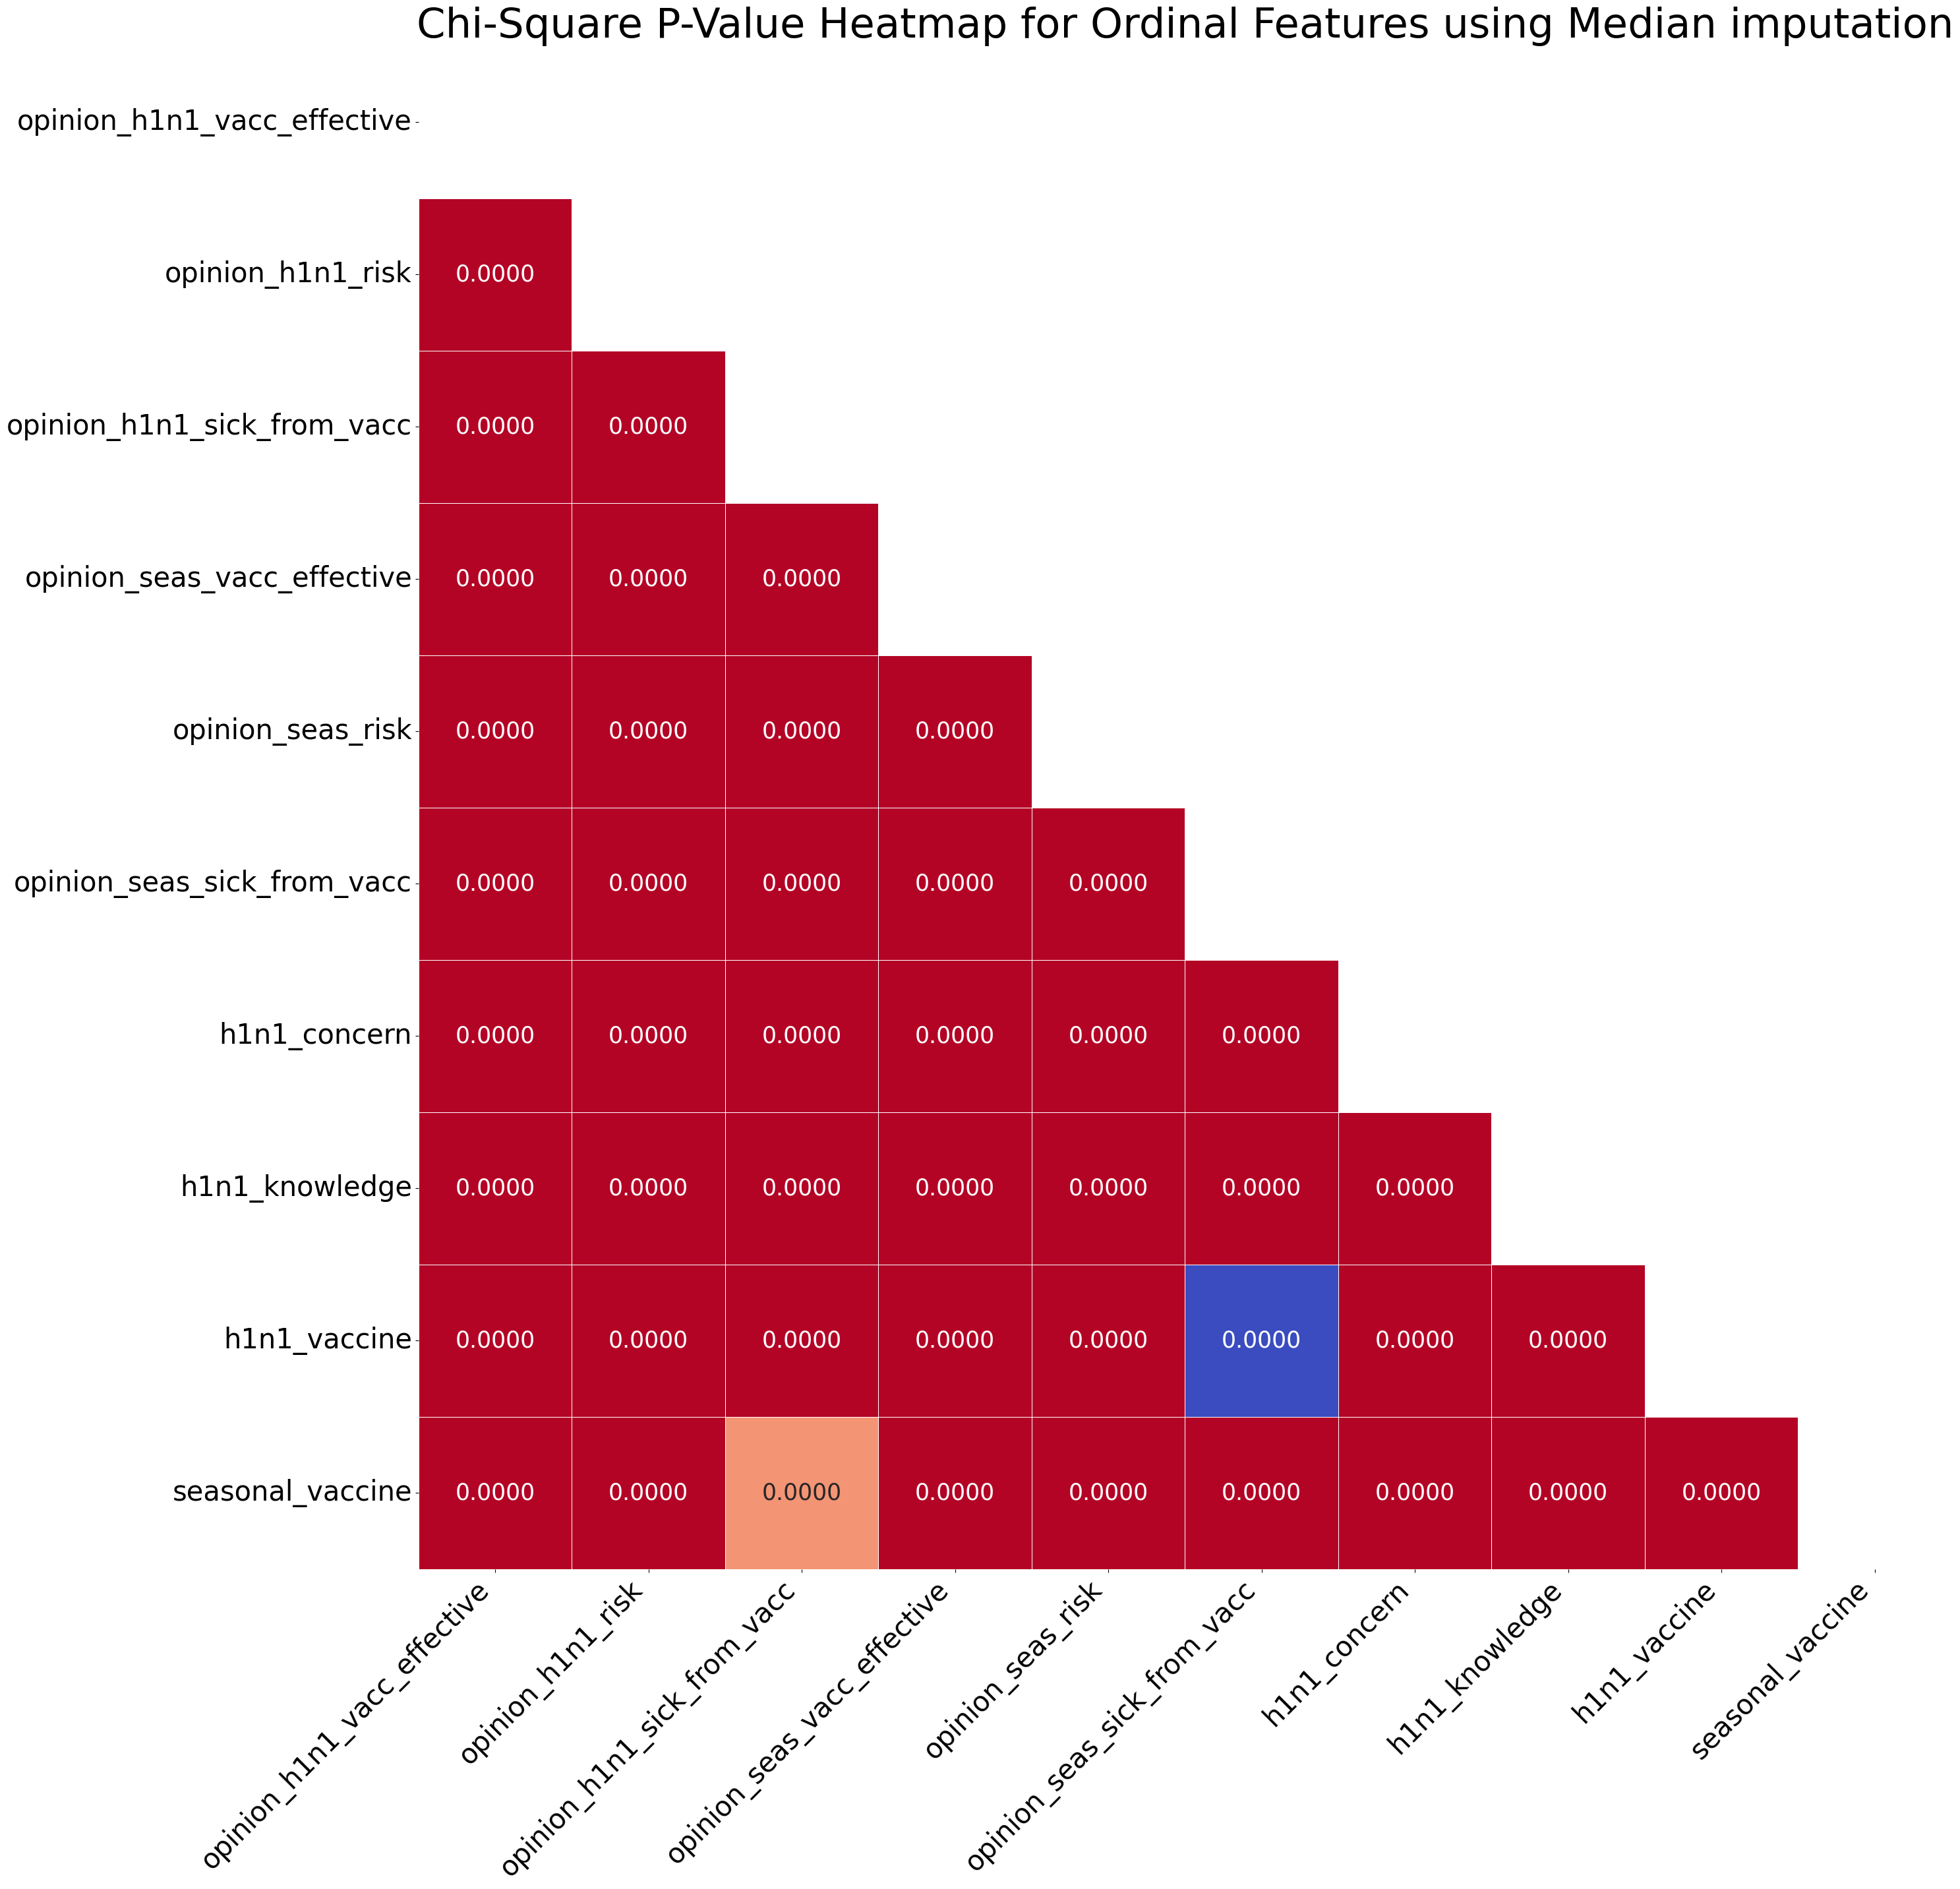

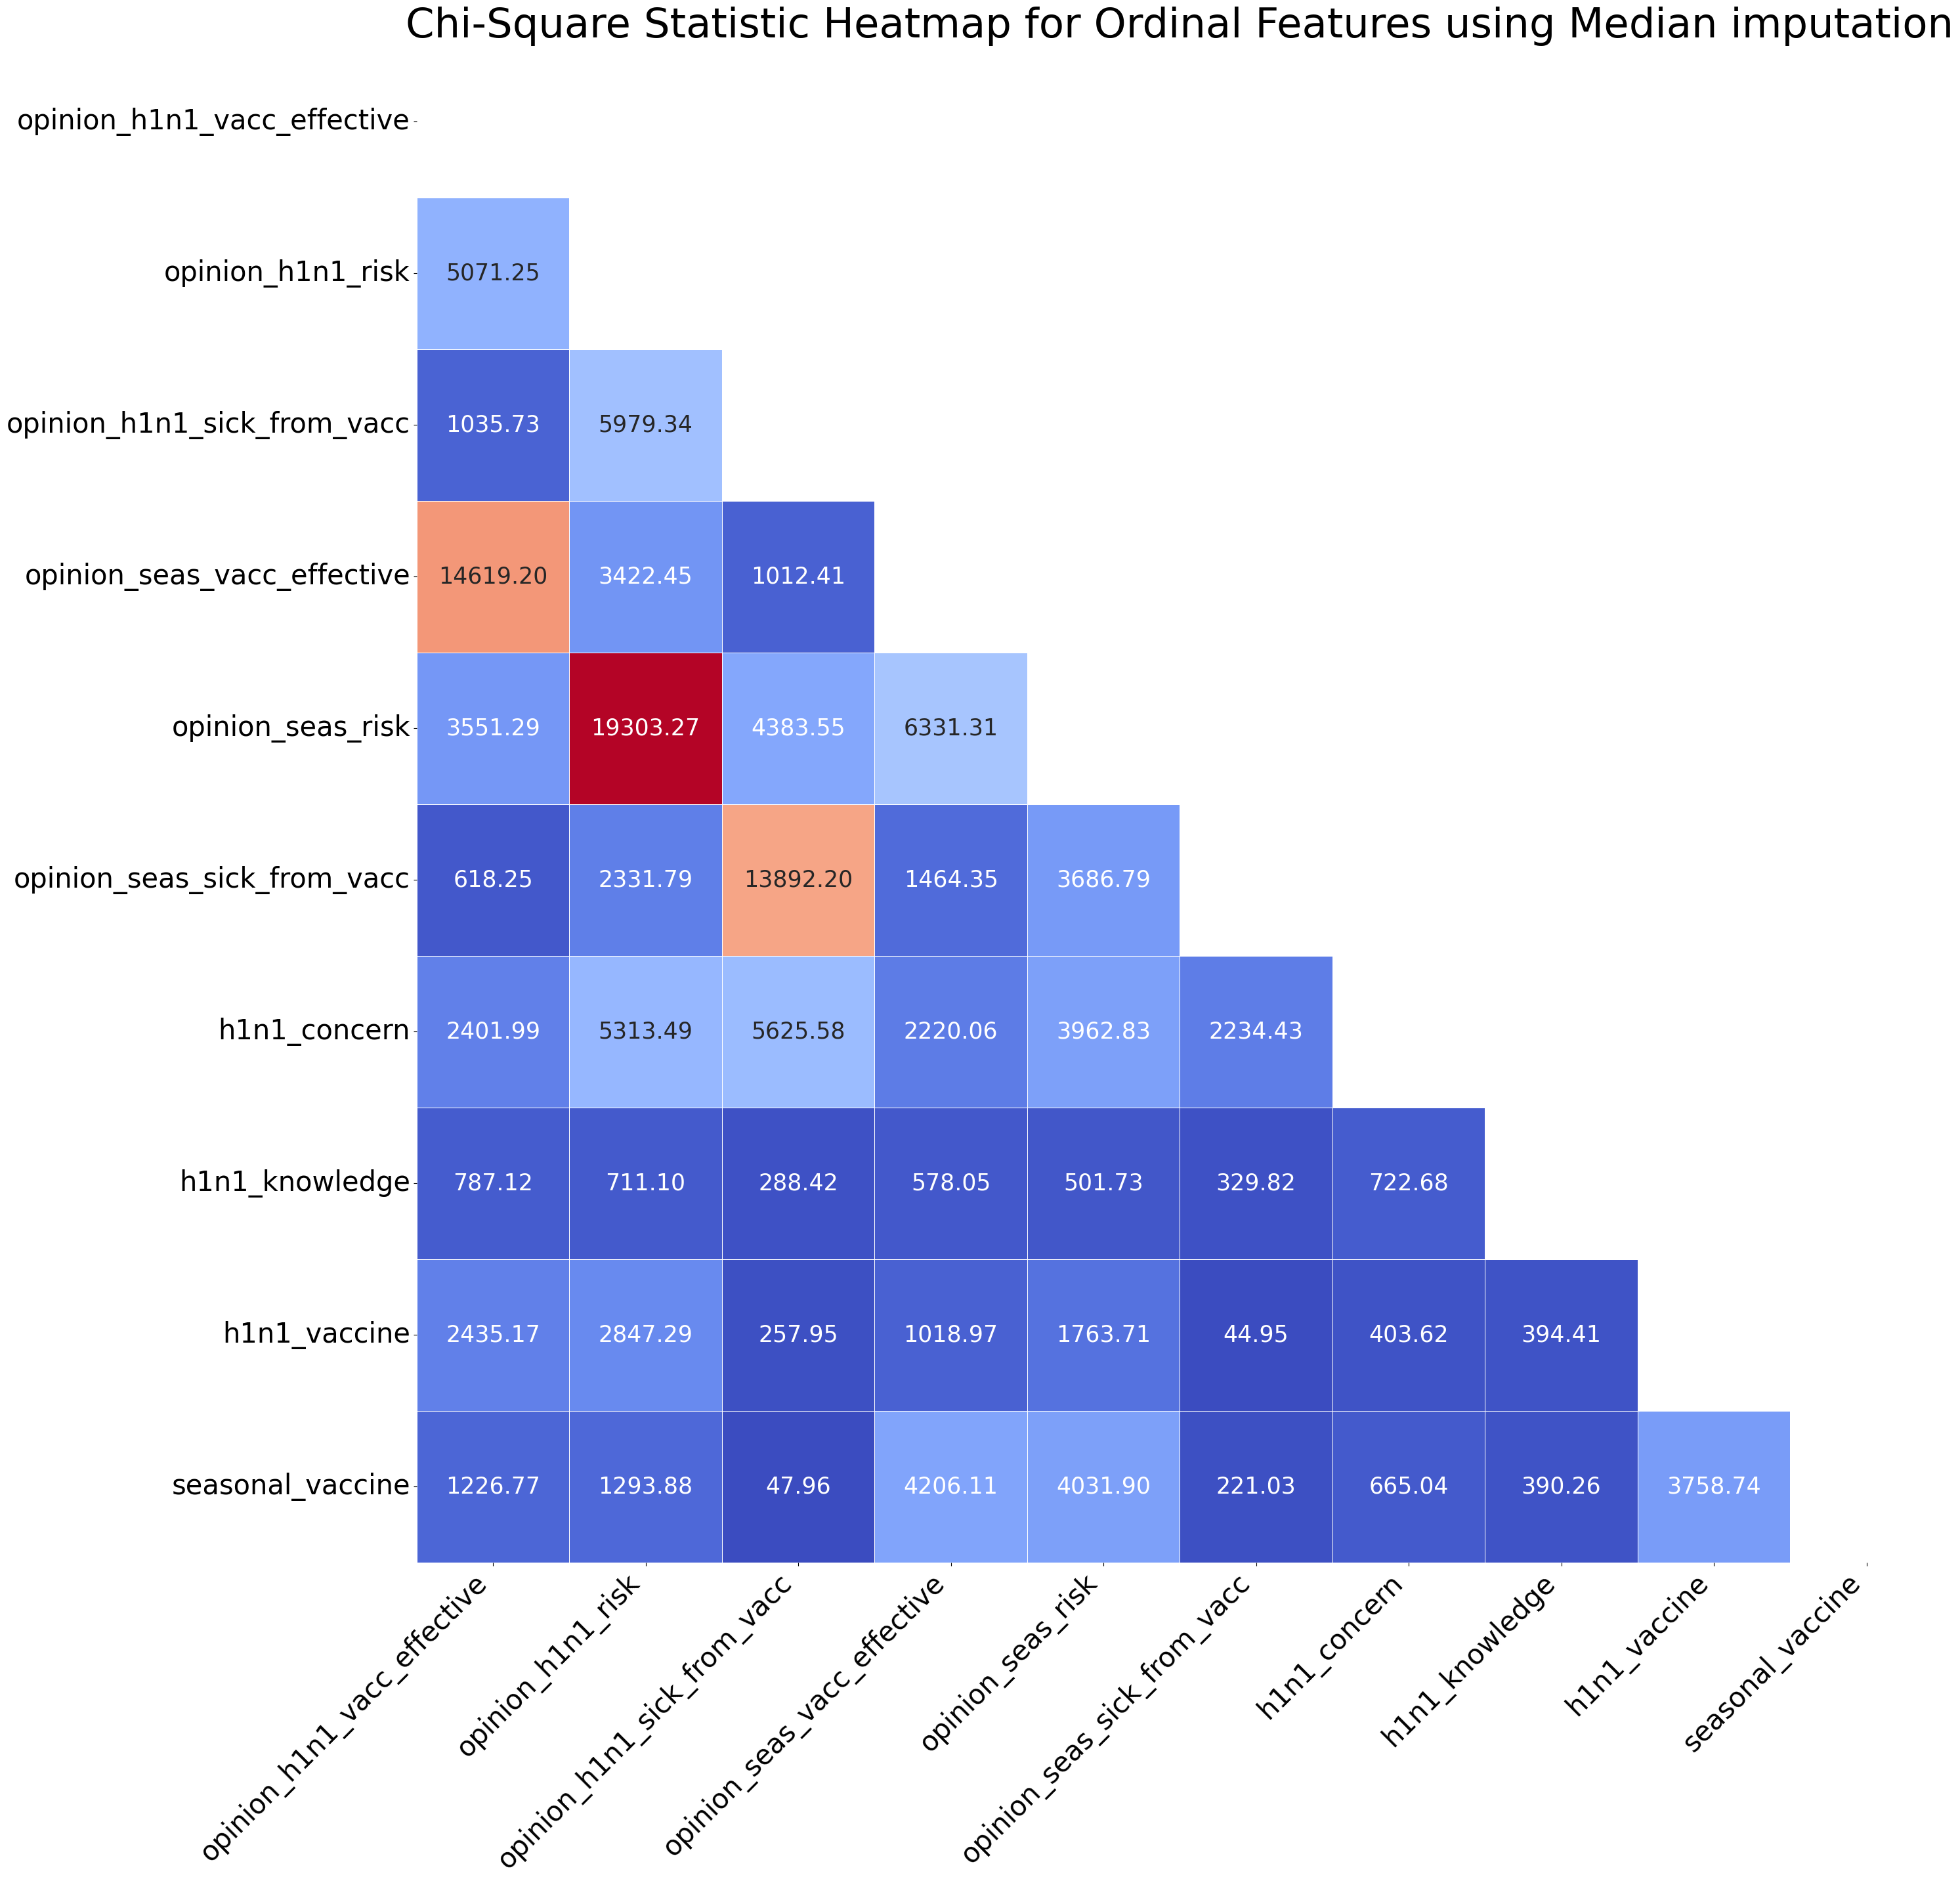

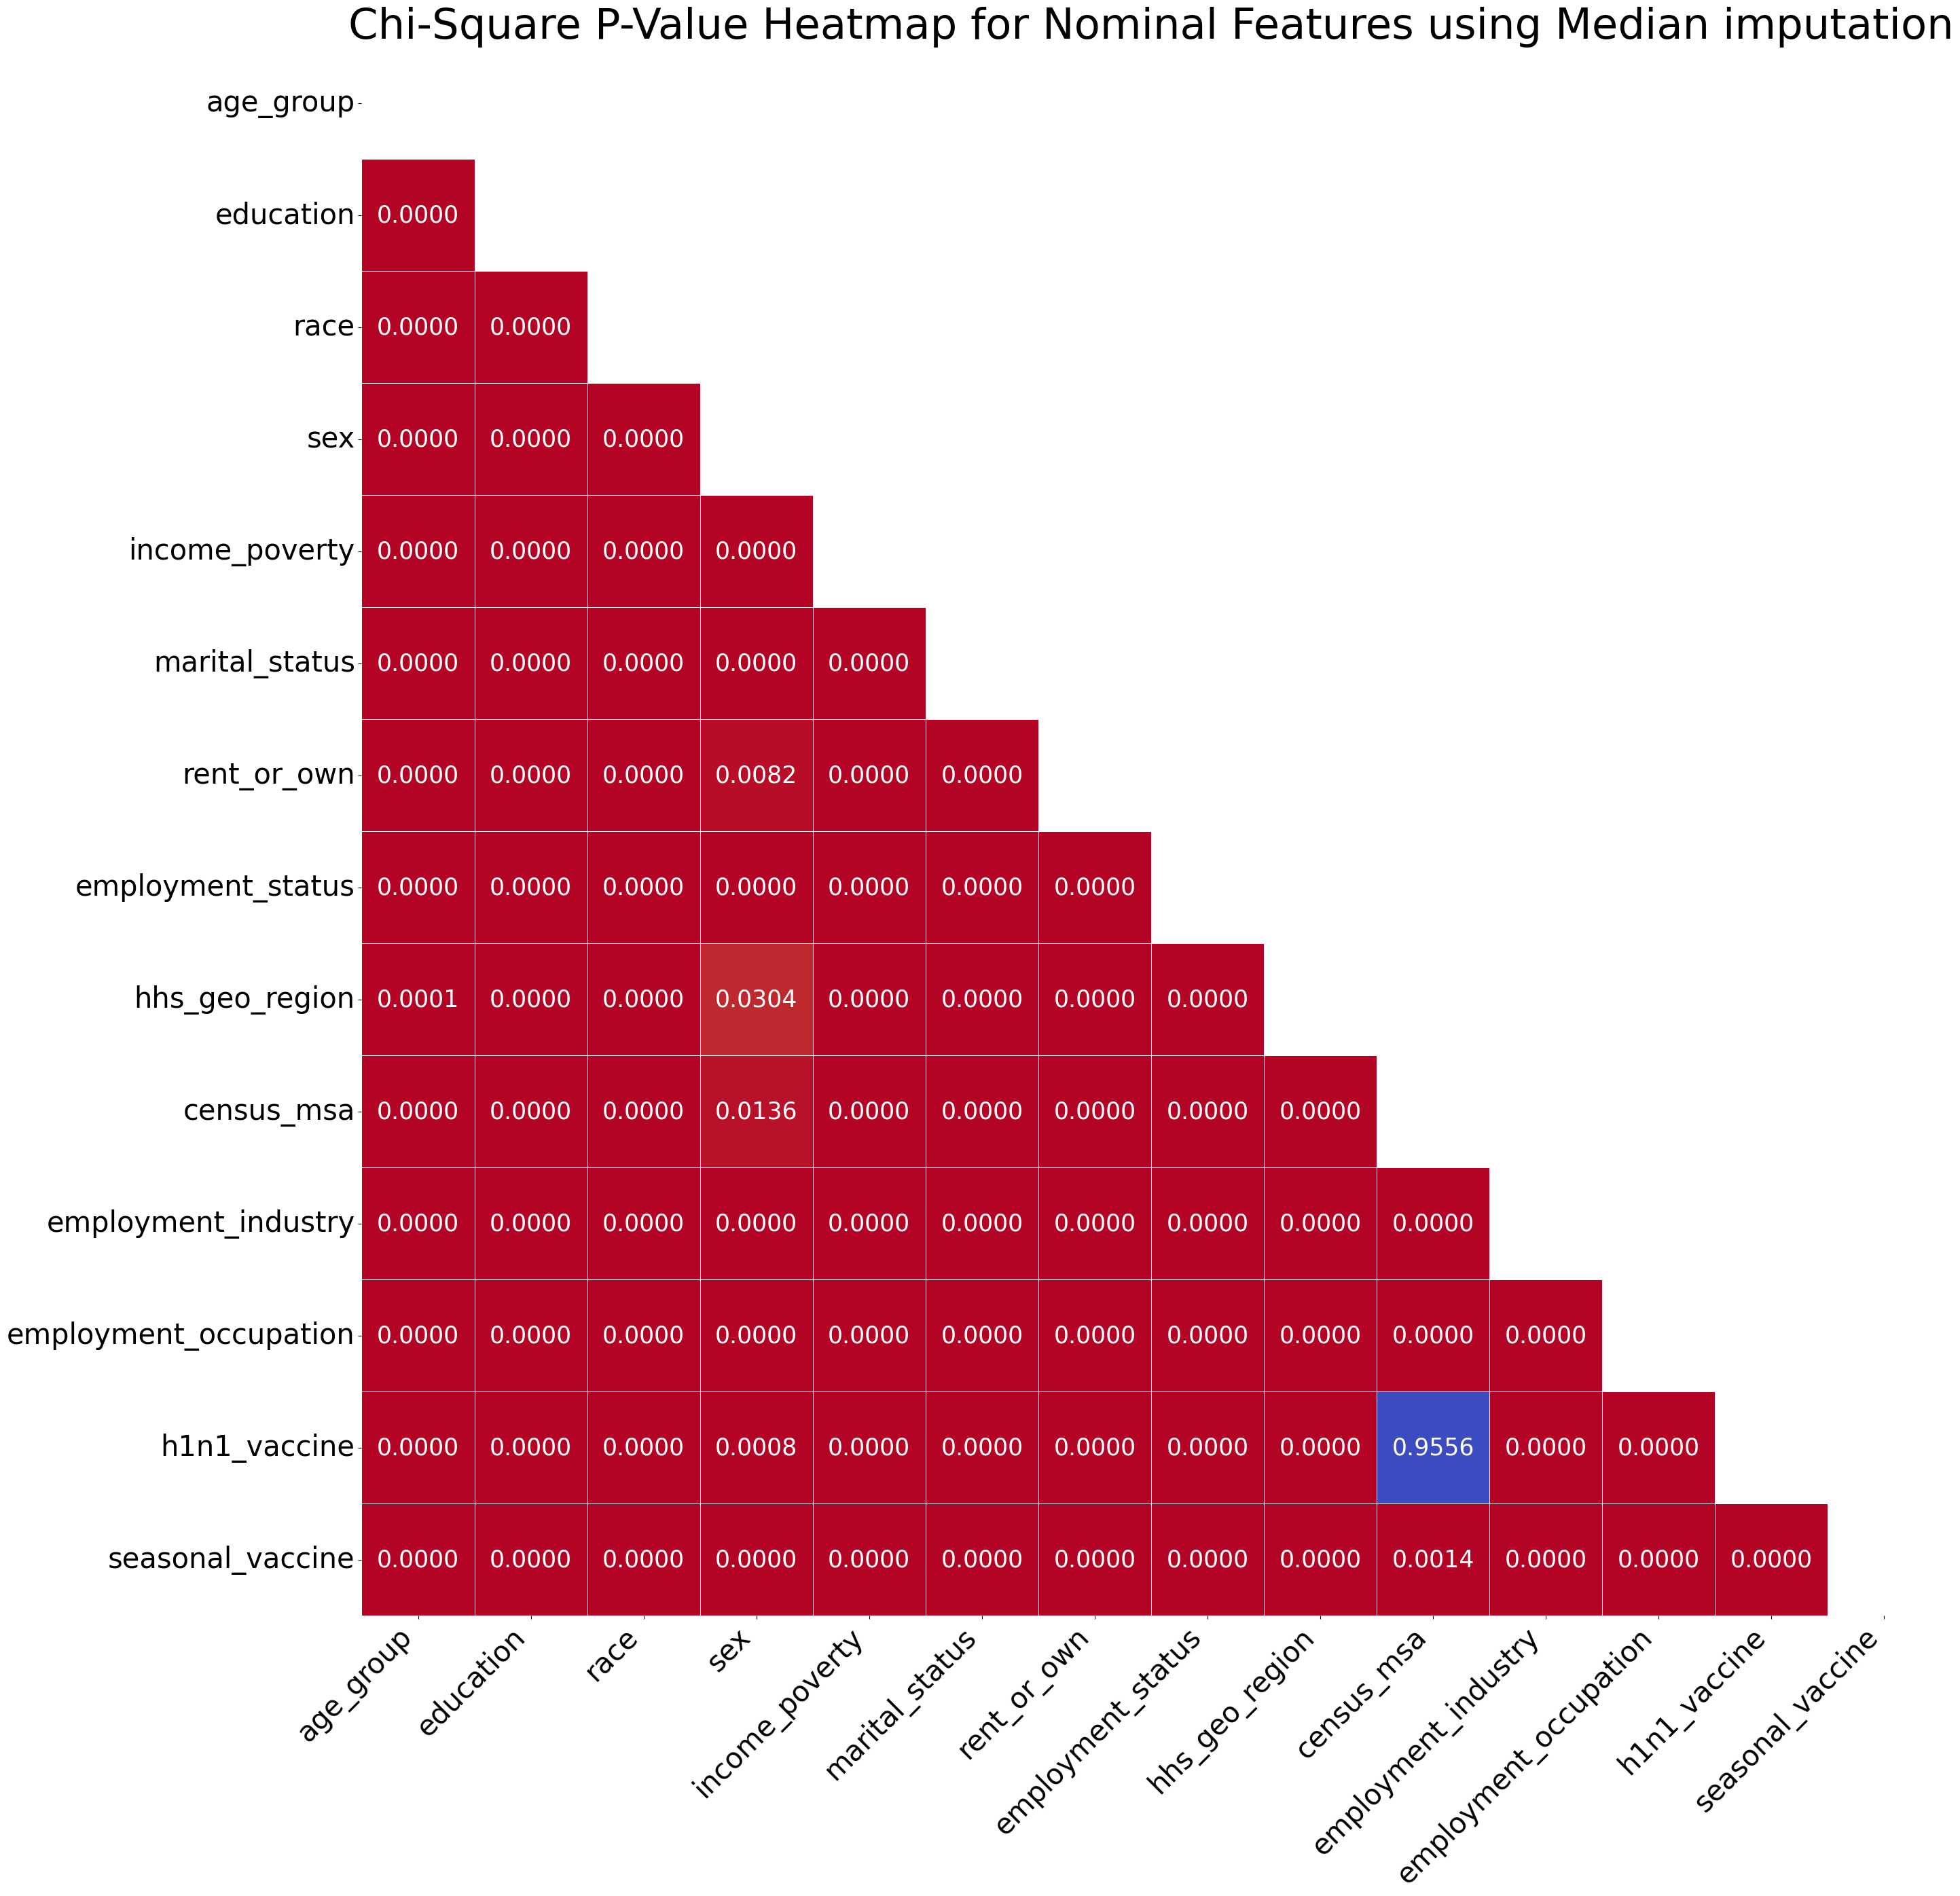

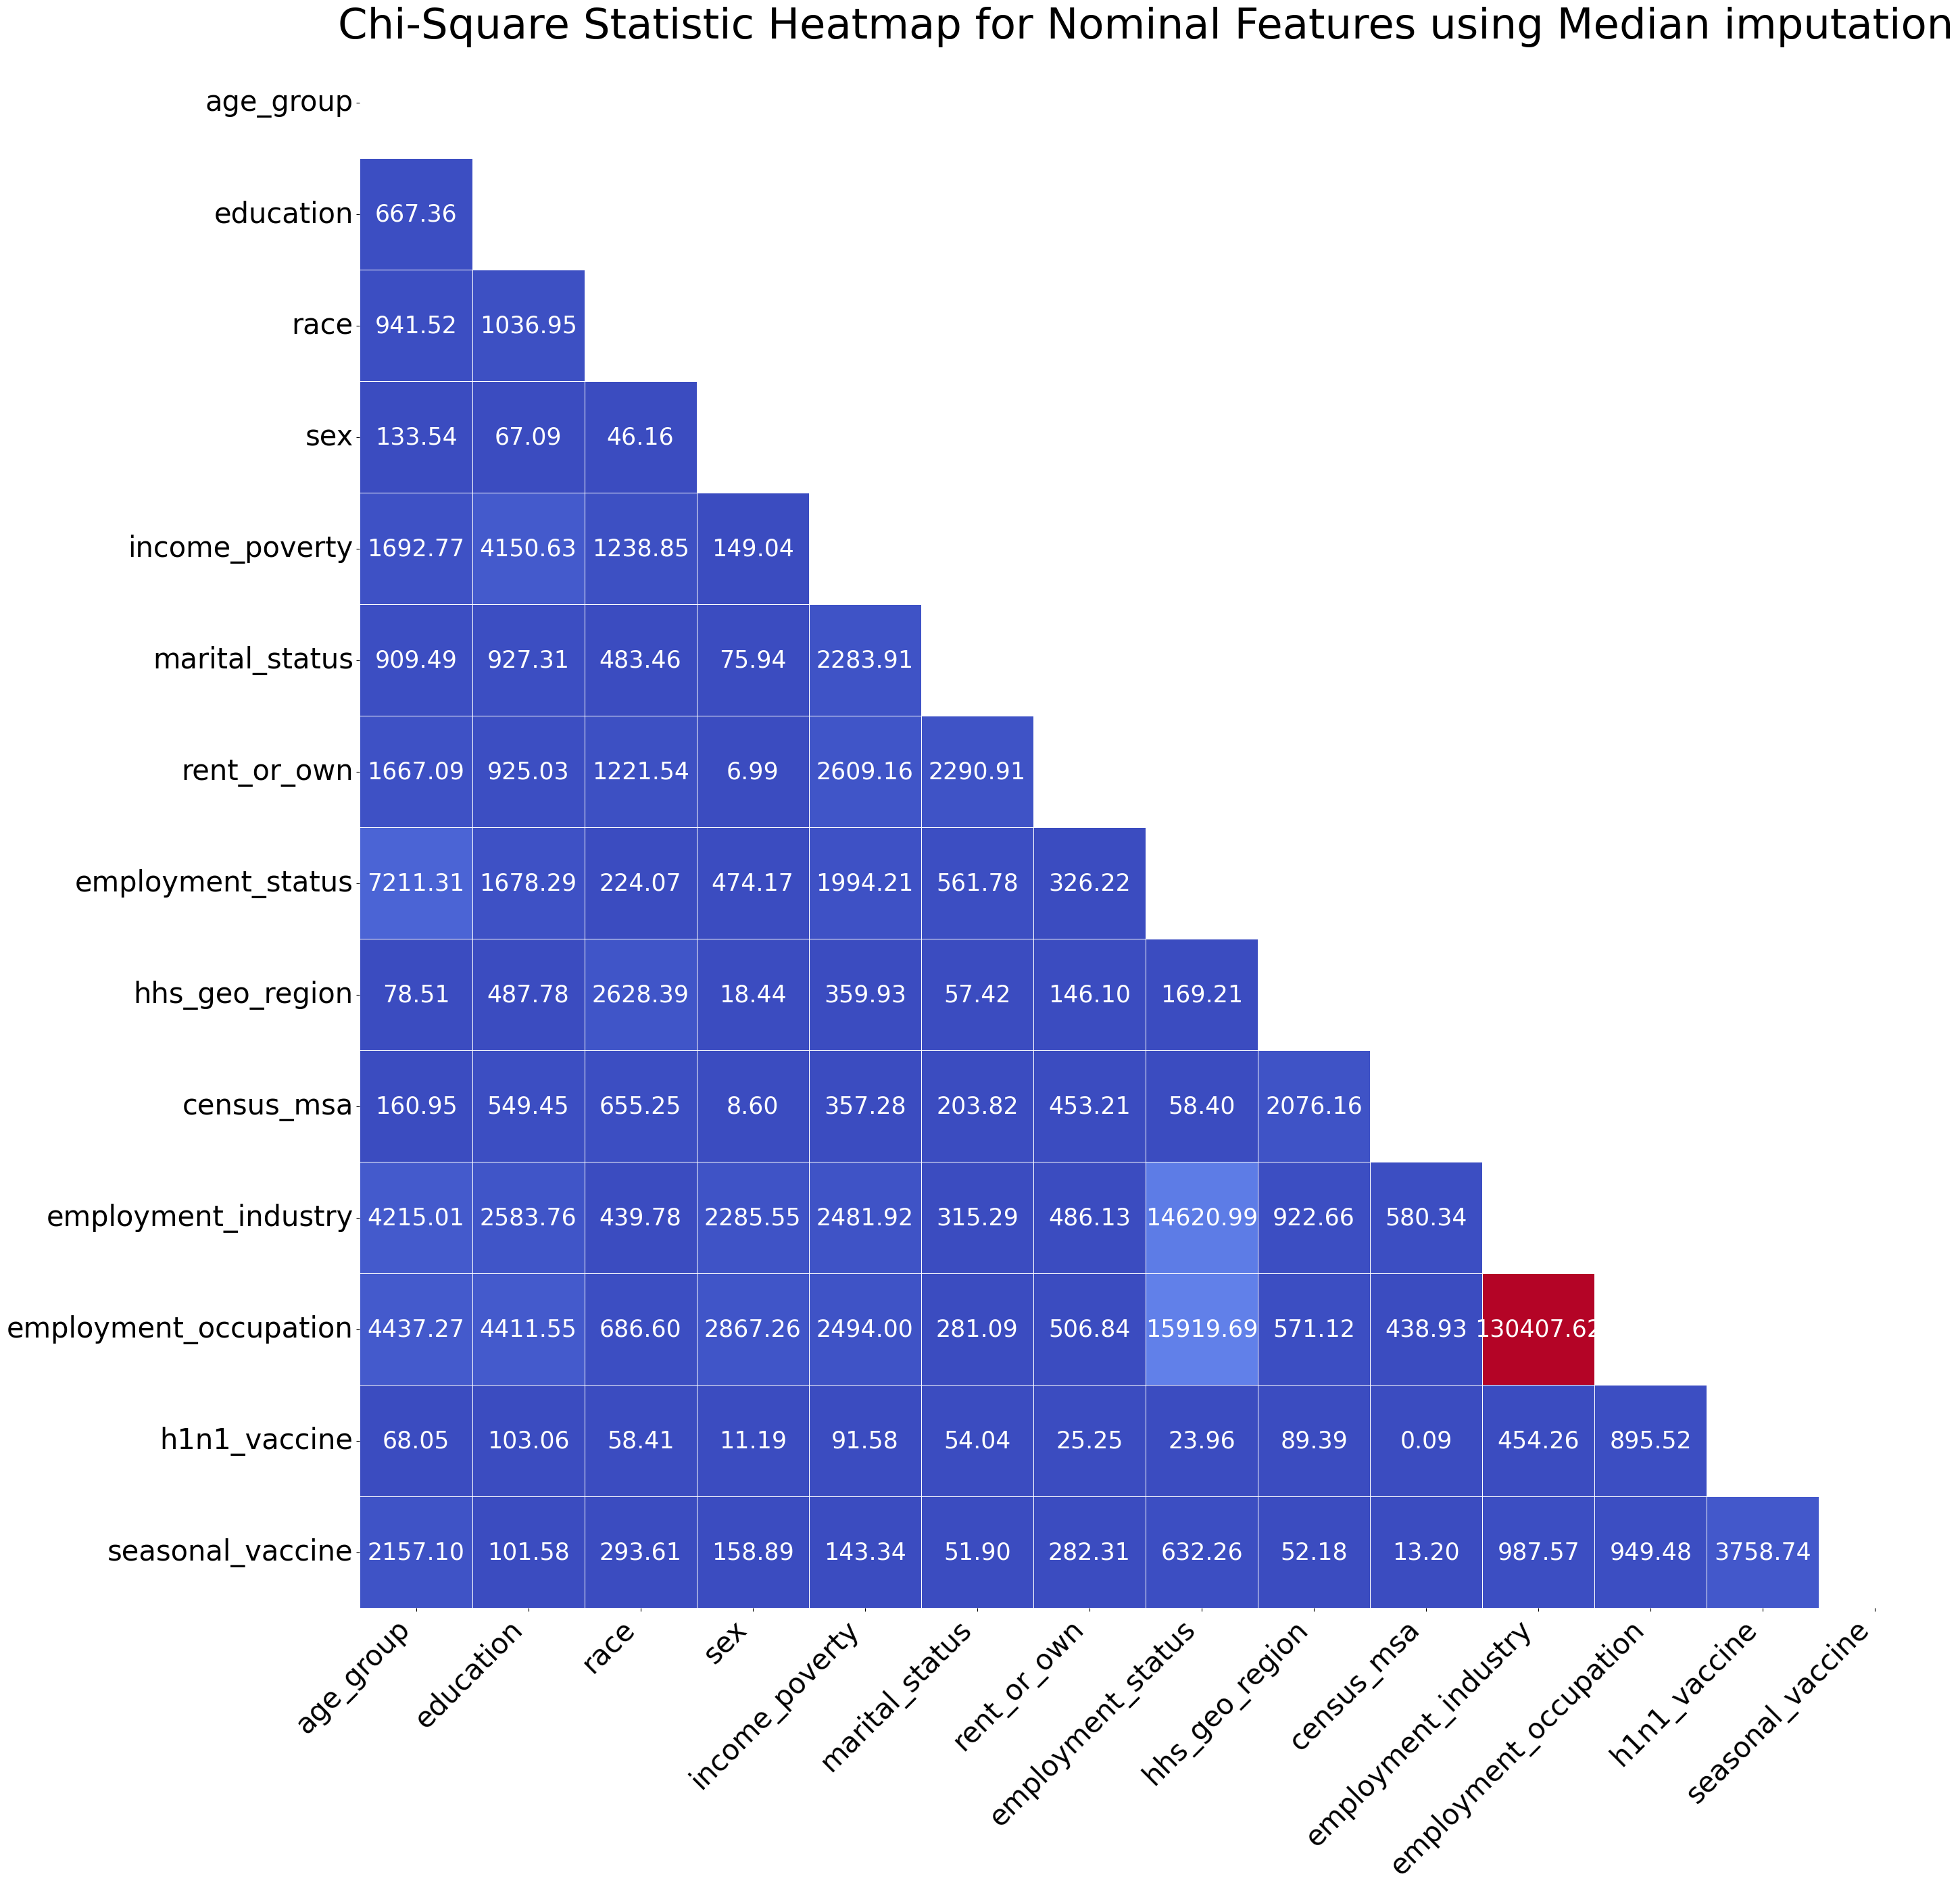

In [34]:
# Call chi_square_matrix() to plot p-values and Chi-Square statistics heatmap

# Mean imputation DataFrame
chi_values_mean_numerical = chi_square_matrix(df_x_mean[numerical_features], "Numerical Features", "Mean")
chi_values_mean_binary = chi_square_matrix(df_x_mean[binary_features], "Binary Features", "Mean")
chi_values_mean_ordinal = chi_square_matrix(df_x_mean[ordinal_features], "Ordinal Features", "Mean")
chi_values_mean_norminal = chi_square_matrix(df_x_mean[nominal_features], "Nominal Features", "Mean")

# Median imputation DataFrame
chi_values_median_numerical = chi_square_matrix(df_x_median[numerical_features], "Numerical Features", "Median")
chi_values_median_binary = chi_square_matrix(df_x_median[binary_features], "Binary Features", "Median")
chi_values_median_ordinal = chi_square_matrix(df_x_median[ordinal_features], "Ordinal Features", "Median")
chi_values_median_norminal = chi_square_matrix(df_x_median[nominal_features], "Nominal Features", "Median")

In [35]:
# Extract the Chi-Square statistics from the 2 target columns (mean imputation)
chi_value_vaccine_numerical_mean = chi_values_mean_numerical.loc[:, ['h1n1_vaccine', 'seasonal_vaccine']]
chi_value_vaccine_numerical_mean = chi_value_vaccine_numerical_mean.drop(['h1n1_vaccine', 'seasonal_vaccine'])

chi_value_vaccine_binary_mean = chi_values_mean_binary.loc[:, ['h1n1_vaccine', 'seasonal_vaccine']]
chi_value_vaccine_binary_mean = chi_value_vaccine_binary_mean.drop(['h1n1_vaccine', 'seasonal_vaccine'])

chi_value_vaccine_ordinal_mean = chi_values_mean_ordinal.loc[:, ['h1n1_vaccine', 'seasonal_vaccine']]
chi_value_vaccine_ordinal_mean = chi_value_vaccine_ordinal_mean.drop(['h1n1_vaccine', 'seasonal_vaccine'])

chi_value_vaccine_nominal_mean = chi_values_mean_norminal.loc[:, ['h1n1_vaccine', 'seasonal_vaccine']]

# Merge the DataFrames
chi_value_vaccines_mean = pd.concat([chi_value_vaccine_numerical_mean, 
                                     chi_value_vaccine_binary_mean, 
                                     chi_value_vaccine_ordinal_mean, 
                                     chi_value_vaccine_nominal_mean], axis=0)

# Extract 5 highest Chi-Square statistics and feature name
top_5_chi_value_h1n1_mean = chi_value_vaccines_mean['h1n1_vaccine'].nlargest(n=6)
top_5_chi_value_h1n1_mean = top_5_chi_value_h1n1_mean.drop('h1n1_vaccine')
print('\033[1mFeatures with the top 5 Chi-Square statistics for H1N1 vaccine (mean imputation)\033[0m')
print(top_5_chi_value_h1n1_mean)
print()
top_5_chi_value_seasonal_mean = chi_value_vaccines_mean['seasonal_vaccine'].nlargest(n=6)
top_5_chi_value_seasonal = top_5_chi_value_seasonal_mean.drop('seasonal_vaccine')
print('\033[1mFeatures with the top 5 Chi-Square statistics for seasonal vaccine (mean imputation)\033[0m')
print(top_5_chi_value_seasonal)

Features with the top 5 Chi-Square statistics for H1N1 vaccine (mean imputation)
doctor_recc_h1n1               4153.488738
seasonal_vaccine               3758.741356
opinion_h1n1_risk              2847.286845
opinion_h1n1_vacc_effective    2435.166276
opinion_seas_risk              1763.714499
Name: h1n1_vaccine, dtype: float64

Features with the top 5 Chi-Square statistics for seasonal vaccine (mean imputation)
opinion_seas_vacc_effective    4206.106745
opinion_seas_risk              4031.900659
h1n1_vaccine                   3758.741356
doctor_recc_seasonal           3458.430452
age_group                      2157.101049
Name: seasonal_vaccine, dtype: float64


In [36]:
# Extract the Chi-Square statistics from the 2 target columns (median imputation)
chi_value_vaccine_numerical_median = chi_values_median_numerical.loc[:, ['h1n1_vaccine', 'seasonal_vaccine']]
chi_value_vaccine_numerical_median = chi_value_vaccine_numerical_median.drop(['h1n1_vaccine', 'seasonal_vaccine'])

chi_value_vaccine_binary_median = chi_values_median_binary.loc[:, ['h1n1_vaccine', 'seasonal_vaccine']]
chi_value_vaccine_binary_median = chi_value_vaccine_binary_median.drop(['h1n1_vaccine', 'seasonal_vaccine'])

chi_value_vaccine_ordinal_median = chi_values_median_ordinal.loc[:, ['h1n1_vaccine', 'seasonal_vaccine']]
chi_value_vaccine_ordinal_median = chi_value_vaccine_ordinal_median.drop(['h1n1_vaccine', 'seasonal_vaccine'])

chi_value_vaccine_nominal_median = chi_values_median_norminal.loc[:, ['h1n1_vaccine', 'seasonal_vaccine']]

# Merge the DataFrames
chi_value_vaccines_median = pd.concat([chi_value_vaccine_numerical_median, 
                                     chi_value_vaccine_binary_median, 
                                     chi_value_vaccine_ordinal_median, 
                                     chi_value_vaccine_nominal_median], axis=0)

# Extract 5 highest Chi-Square statistics and feature name
top_5_chi_value_h1n1_median = chi_value_vaccines_median['h1n1_vaccine'].nlargest(n=6)
top_5_chi_value_h1n1_median = top_5_chi_value_h1n1_median.drop('h1n1_vaccine')
print('\033[1mFeatures with the top 5 Chi-Square statistics for H1N1 vaccine (median imputation)\033[0m')
print(top_5_chi_value_h1n1_median)
print()
top_5_chi_value_seasonal_median = chi_value_vaccines_median['seasonal_vaccine'].nlargest(n=6)
top_5_chi_value_seasonal_median = top_5_chi_value_seasonal_median.drop('seasonal_vaccine')
print('\033[1mFeatures with the top 5 Chi-Square statistics for seasonal vaccine (median imputation)\033[0m')
print(top_5_chi_value_seasonal_median)

Features with the top 5 Chi-Square statistics for H1N1 vaccine (median imputation)
doctor_recc_h1n1               4153.488738
seasonal_vaccine               3758.741356
opinion_h1n1_risk              2847.286845
opinion_h1n1_vacc_effective    2435.166276
opinion_seas_risk              1763.714499
Name: h1n1_vaccine, dtype: float64

Features with the top 5 Chi-Square statistics for seasonal vaccine (median imputation)
opinion_seas_vacc_effective    4206.106745
opinion_seas_risk              4031.900659
h1n1_vaccine                   3758.741356
doctor_recc_seasonal           3458.430452
age_group                      2157.101049
Name: seasonal_vaccine, dtype: float64


## Data Pre-Processing (2)

This section is written by Clarine and Carolyn with the references mentioned below. Each cell is written by both of us unless specified.<br>

_References_ <br>
[1]<br>
Title: Lab 2 - Wrangling and preprocessing data<br>
Author: Johann Benerradi, Jeremie Clos<br>
Availability: https://moodle.nottingham.ac.uk/mod/resource/view.php?id=6562915<br>

[2]<br>
Title: Lab 4 - Data Analysis and Modelling<br>
Author: Nazia Hameed, Jeremie Clos<br>
Availability: https://moodle.nottingham.ac.uk/mod/resource/view.php?id=6590728<br>

[3]<br>
Title: Random Oversampling and Undersampling for Imbalanced Classification<br>
Author: Jason Brownlee<br>
Availability: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/<br>

[4]<br>
Title: How to Combine Oversampling and Undersampling for Imbalanced Classification<br>
Author: Jason Brownlee<br>
Availability: https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/

### Data encoding
The ordinal categorical features have been encoded using label encoding, while the nominal features have not been encoded yet. Therefore, we will apply ***one-hot encoding*** to the nominal features.

In [37]:
# Function to apply one-hot encoding
def one_hot_encode(df):
    df_encoded = pd.get_dummies(df, columns=nominal_features)
    return df_encoded

In [38]:
# Call one_hot_encoding() to encode the nominal features for each DataFrame
df_x_mean_encoded = one_hot_encode(df_x_mean)
df_x_median_encoded = one_hot_encode(df_x_median)

In [39]:
# Update nominal feature columns name list
new_nominal_features = [col for col in df_x_mean_encoded.columns if col not in df_x]

### Change data type (2)
Nominal features: unit8 to bool

In [40]:
# Check original data type
print(df_x_mean_encoded.info())
print()
print(df_x_median_encoded.info())

<class 'pandas.core.frame.DataFrame'>
Index: 26501 entries, 0 to 26706
Columns: 105 entries, h1n1_concern to employment_occupation_xzmlyyjv
dtypes: bool(95), int64(8), int8(2)
memory usage: 4.3 MB
None

<class 'pandas.core.frame.DataFrame'>
Index: 26501 entries, 0 to 26706
Columns: 105 entries, h1n1_concern to employment_occupation_xzmlyyjv
dtypes: bool(95), int64(8), int8(2)
memory usage: 4.3 MB
None


In [41]:
# Function to convert data type of nominal features
# Written by Clarine

def convert_dtype_nominal(df):
    df[new_nominal_features] = df[new_nominal_features].astype("bool")
    return df

In [42]:
# Call convert_dtype_nominal() to change data type of nonimal features for each DataFrame
df_x_mean_encoded = convert_dtype_nominal(df_x_mean_encoded)
df_x_median_encoded = convert_dtype_nominal(df_x_median_encoded)

In [43]:
# Check if data types are changed properly
df_x_mean_encoded.info()
print()
df_x_median_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26501 entries, 0 to 26706
Columns: 105 entries, h1n1_concern to employment_occupation_xzmlyyjv
dtypes: bool(95), int64(8), int8(2)
memory usage: 4.3 MB

<class 'pandas.core.frame.DataFrame'>
Index: 26501 entries, 0 to 26706
Columns: 105 entries, h1n1_concern to employment_occupation_xzmlyyjv
dtypes: bool(95), int64(8), int8(2)
memory usage: 4.3 MB


### Train-Test Split

In [44]:
# Function to split dataset into training and test sets
def split_train_test(df_x, df_y):
    x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, stratify=df_y, random_state=23)
    return x_train, x_test, y_train, y_test

In [45]:
# Call split_train_test() to split the dataset into train and test sets

# Mean imputated dataset
x_train_mean, x_test_mean, y_train_mean, y_test_mean = split_train_test(df_x_mean_encoded, df_y)

# Median imputated dataset
x_train_median, x_test_median, y_train_median, y_test_median = split_train_test(df_x_median_encoded, df_y)

### Resampling Techniques
1. Random oversampling
2. SMOTEENN (SMOTE + ENN)

In [46]:
# Random oversampling
# Written by Clarine

# Create random oversampling instance
# Set random state = 42 for reproducibility
random_oversampler = RandomOverSampler(random_state=42)

# Function to apply random oversampling to the DataFrame
def random_oversampling(df_x, df_y):
    # Encode the labelled data
    # Transform the multilabel columns to a single column
    # This is to simply the resampling process
    y_str = df_y['h1n1_vaccine'].astype(str) + '_' + df_y['seasonal_vaccine'].astype(str)
    le = LabelEncoder()
    df_y['encoded'] = le.fit_transform(y_str)
    
    # Random oversample the DataFrame
    x_resampled, y_resampled = random_oversampler.fit_resample(df_x, df_y['encoded'])
    
    # Decode the labelled data
    y_decoded = le.inverse_transform(y_resampled)
    y_resampled_decoded = pd.DataFrame(y_decoded, columns=['decoded'])
    y_resampled_decoded[['h1n1_vaccine', 'seasonal_vaccine']] = y_resampled_decoded['decoded'].str.split('_', expand=True)
    y_resampled_decoded.drop('decoded', axis=1, inplace=True)
    
    # Convert the data type back to int
    y_resampled_decoded['h1n1_vaccine'] = y_resampled_decoded['h1n1_vaccine'].astype(int)
    y_resampled_decoded['seasonal_vaccine'] = y_resampled_decoded['seasonal_vaccine'].astype(int)
    
    return x_resampled, y_resampled_decoded

In [47]:
# Call random_oversampling() to apply Random Oversampling to the dataset

# Mean imputated train dataset
x_train_mean_oversample, y_train_mean_oversample = random_oversampling(x_train_mean, y_train_mean)

# Median imputated train dataset
x_train_median_oversample, y_train_median_oversample = random_oversampling(x_train_median, y_train_median)

In [48]:
# Check data distribution before and after random oversampling
# Written by Clarine

# Mean imputated train dataset
print('\033[1mMean Imputated Dataset\033[0m')

# H1N1 vaccine data distribution
b_h1n1_mean = y_train_mean['h1n1_vaccine'].value_counts(normalize=True)
print('H1N1 (before):')
print(b_h1n1_mean)
print()

a_h1n1_mean = y_train_mean_oversample['h1n1_vaccine'].value_counts(normalize=True)
print('H1N1 (after):')
print(a_h1n1_mean)
print()

# Seasonal vaccine data distribution
b_seasonal_mean = y_train_mean['seasonal_vaccine'].value_counts(normalize=True)
print('Seasonal (before):')
print(b_seasonal_mean)
print()

a_seasonal_mean = y_train_mean_oversample['seasonal_vaccine'].value_counts(normalize=True)
print('Seasonal (after):')
print(a_seasonal_mean)
print()
print()


# Median imputated train dataset
print('\033[1mMedian Imputated Dataset\033[0m')

# H1N1 vaccine data distribution
b_h1n1_median = y_train_median['h1n1_vaccine'].value_counts(normalize=True)
print('H1N1 (before):')
print(b_h1n1_median)
print()

a_h1n1_median = y_train_median_oversample['h1n1_vaccine'].value_counts(normalize=True)
print('H1N1 (after):')
print(a_h1n1_median)
print()

# Seasonal vaccine data distribution
b_seasonal_median = y_train_median['seasonal_vaccine'].value_counts(normalize=True)
print('Seasonal (before):')
print(b_seasonal_median)
print()

a_seasonal_median = y_train_median_oversample['seasonal_vaccine'].value_counts(normalize=True)
print('Seasonal (after):')
print(a_seasonal_median)
print()
print()

Mean Imputated Dataset
H1N1 (before):
h1n1_vaccine
0    0.787655
1    0.212345
Name: proportion, dtype: float64

H1N1 (after):
h1n1_vaccine
0    0.5
1    0.5
Name: proportion, dtype: float64

Seasonal (before):
seasonal_vaccine
0    0.533477
1    0.466523
Name: proportion, dtype: float64

Seasonal (after):
seasonal_vaccine
0    0.5
1    0.5
Name: proportion, dtype: float64


Median Imputated Dataset
H1N1 (before):
h1n1_vaccine
0    0.787655
1    0.212345
Name: proportion, dtype: float64

H1N1 (after):
h1n1_vaccine
0    0.5
1    0.5
Name: proportion, dtype: float64

Seasonal (before):
seasonal_vaccine
0    0.533477
1    0.466523
Name: proportion, dtype: float64

Seasonal (after):
seasonal_vaccine
0    0.5
1    0.5
Name: proportion, dtype: float64




In [49]:
# SMOTEENN resampling (SMOTE + ENN)
# Written by Carolyn

# Create SMOTEENN instance
# Set random state = 42 for reproducibility
smote_enn = SMOTEENN(random_state=42)

# Function to apply SMOTEENN to the DataFrame
def smoteenn(df_x, df_y):
    # Encode the labelled data
    # Transform the multilabel columns to a single column
    # This is to simply the resampling process
    y_str = df_y['h1n1_vaccine'].astype(str) + '_' + df_y['seasonal_vaccine'].astype(str)
    le = LabelEncoder()
    df_y['encoded'] = le.fit_transform(y_str)
    
    # Apply SMOTEENN to the DataFrame
    x_resampled, y_resampled = smote_enn.fit_resample(df_x, df_y['encoded'])
    
    # Decode the labelled data
    y_decoded = le.inverse_transform(y_resampled)
    y_resampled_decoded = pd.DataFrame(y_decoded, columns=['decoded'])
    y_resampled_decoded[['h1n1_vaccine', 'seasonal_vaccine']] = y_resampled_decoded['decoded'].str.split('_', expand=True)
    y_resampled_decoded.drop('decoded', axis=1, inplace=True)
    
    # Convert the data type back to int
    y_resampled_decoded['h1n1_vaccine'] = y_resampled_decoded['h1n1_vaccine'].astype(int)
    y_resampled_decoded['seasonal_vaccine'] = y_resampled_decoded['seasonal_vaccine'].astype(int)
    
    return x_resampled, y_resampled_decoded

In [50]:
# Call smoteenn() to apply SMOTEENN to the dataset

# Mean imputated train dataset
x_train_mean_smoteenn, y_train_mean_smoteenn = smoteenn(x_train_mean, y_train_mean)

# Median imputated train dataset
x_train_median_smoteenn, y_train_median_smoteenn = smoteenn(x_train_median, y_train_median)

## Data Modelling / Classification
This section is written by Clarine and Carolyn with the references mentioned below. Each cell is written by both of us unless specified.<br>

_References_ <br>
[1]<br>
Title: Multi Label Binary Classification with CatBoost<br>
Author: LyzhinIvan<br>
Availability: <br>

[2]<br>
Title: How to Train a Catboost Classifier with GridSearch Hyperparameter Tuning<br>
Author: Datasnips<br>
Availability: https://www.datasnips.com/54/train-catboost-classifier-with-gridsearch/<br>

[3]<br>
Title: Multi Label Binary Classification with CatBoost<br>
Author: LyzhinIvan<br>
Availability: https://github.com/catboost/tutorials/blob/94e3bc9c3510ed69c2da7f544ec8979387419ec9/classification/multilabel_classification_tutorial.ipynb<br>

[4]<br>
Title: Demo repo fro DrivenData competition "Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines<br>
Author: adalseno<br>
Availability: https://github.com/adalseno/Flu-Shot-Learning-Predict-H1N1-and-Seasonal-Flu-Vaccines/blob/main/Flu_CatBoost-tuned-OptunaCVI.ipynb

### Model Evaluation

In [51]:
# Function to evaluate the CatBoost performance
# Written by Clarine

def eval_model_catboost(y_pred, y_pred_prob, y_test):
    print('\033[3mEvaluation metrics\033[0m')

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')

    # Accuracy per class
    accuracy_h1n1 = accuracy_score(y_test['h1n1_vaccine'], y_pred[:, 0])
    print(f'Accuracy for h1n1_vaccine: {accuracy_h1n1}')
    accuracy_seasonal = accuracy_score(y_test['seasonal_vaccine'], y_pred[:, 1])
    print(f'Accuracy for seasonal_vaccine: {accuracy_seasonal}')

    # Hamming loss
    hamming_loss_score = hamming_loss(y_test, y_pred)
    print(f'Hamming loss: {hamming_loss_score}')

    # F1
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    print('Micro F1 score:', f1_micro)
    print('Weighted F1 score:', f1_weighted)
    print()

    # AUROC
    h1n1_pred_prob = y_pred_prob[:,0].reshape(-1,1)
    seasonal_pred_prob = y_pred_prob[:,1].reshape(-1,1)
    auc_h1n1 = roc_auc_score(y_test.h1n1_vaccine, h1n1_pred_prob)
    auc_seasonal = roc_auc_score(y_test.seasonal_vaccine, seasonal_pred_prob)
    print('AUROC for h1n1_vaccine: ', auc_h1n1)
    print('AUROC for seasonal_vaccine: ', auc_seasonal)
    
    # Combined AUROC
    combined_auc = roc_auc_score(y_test, np.hstack((h1n1_pred_prob, seasonal_pred_prob)))
    print('Combined AUROC: ', combined_auc)
    print()
    
    # Plot the AUROC curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Compute false positive rate (FPR), true positive rate (TPR) and thresholds for each class
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Plot the AUROC for each label (H1N1 and seasonal vaccine) 
    plt.figure(figsize=(10,10))
    for i in range(2):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.4f})')
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.ylabel('True Positive Rate (TPR)', fontsize=20)
    plt.xlabel('False Positive Rate (FPR)', fontsize=20)
    plt.title("Receiver Operating Characteristics", fontsize=20)
    plt.legend(loc='upper left', fontsize=15)
    plt.show()  

In [52]:
# Function to evaluate the Random Forest performance
# Written by Carolyn

def eval_model_rf(y_pred, y_h1n1, y_seasonal, y_test):
    print('\033[3mEvaluation metrics\033[0m')

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')

    # Accuracy per label
    accuracy_h1n1 = accuracy_score(y_test['h1n1_vaccine'], y_pred[:, 0])
    print(f'Accuracy for h1n1_vaccine: {accuracy_h1n1}')
    accuracy_seasonal = accuracy_score(y_test['seasonal_vaccine'], y_pred[:, 1])
    print(f'Accuracy for seasonal_vaccine: {accuracy_seasonal}')

    # Hamming loss
    hamming_loss_score = hamming_loss(y_test, y_pred)
    print(f'Hamming loss: {hamming_loss_score}')

    # F1
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    print('Micro F1 score:', f1_micro)
    print('Weighted F1 score:', f1_weighted)
    print()

    # AUROC
    h1n1_pred_prob = y_h1n1[:, 1].reshape(-1, 1)
    seasonal_pred_prob = y_seasonal[:, 1].reshape(-1, 1)
    auc_h1n1 = roc_auc_score(y_test.h1n1_vaccine, h1n1_pred_prob)
    auc_seasonal = roc_auc_score(y_test.seasonal_vaccine, seasonal_pred_prob)
    print('AUROC for h1n1_vaccine: ', auc_h1n1)
    print('AUROC for seasonal_vaccine: ', auc_seasonal)
    
    # Combined AUROC
    combined_auc = roc_auc_score(y_test, np.hstack((h1n1_pred_prob, seasonal_pred_prob)))
    print('Combined AUROC: ', combined_auc)
    print()
    
    # Plot the AUROC curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    y_pred_prob = []
    y_pred_prob.append(h1n1_pred_prob)
    y_pred_prob.append(seasonal_pred_prob)
    
    # Compute false positive rate (FPR), true positive rate (TPR) and thresholds for each label
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_pred_prob[i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Plot the AUROC for each label (H1N1 and seasonal vaccine) 
    plt.figure(figsize=(10,10))
    for i in range(2):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.4f})')
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.ylabel('True Positive Rate (TPR)', fontsize=20)
    plt.xlabel('False Positive Rate (FPR)', fontsize=20)
    plt.title("Receiver Operating Characteristics", fontsize=20)
    plt.legend(loc='upper left', fontsize=15)
    plt.show() 

In [53]:
# Function to make prediction on test set and evaluate the model performance
def make_pred(model, x_test, y_test, rf=False):
    y_pred = model.predict(x_test)
    y_pred_prob = model.predict_proba(x_test)
    
    if rf:
        y_pred_prob_h1n1 = y_pred_prob[0]
        y_pred_prob_seasonal = y_pred_prob[1]
        # Evaluate model performance
        eval_model_rf(y_pred, y_pred_prob_h1n1, y_pred_prob_seasonal, y_test)
    else:
        # Evaluate model performance
        eval_model_catboost(y_pred, y_pred_prob, y_test)

### Random Forest (RF) Algorithm
This section is written by Carolyn.

In [54]:
# Function to build and train Random Forest with hyperparameter tuning using grid search
def random_forest(X_train, y_train):
    rf = RandomForestClassifier(random_state=42)

    param_grid = {
        'criterion': ["gini", "entropy"],
        'max_depth': [20, 40],
        'n_estimators': [400, 500],
        'max_features': ['sqrt', 'log2']
    }
    
    rf_grid_search = GridSearchCV(rf, param_grid, cv = 5, scoring='f1_micro')
    rf_grid_search.fit(X_train, y_train)
    
    print(rf_grid_search.best_params_)
    print(rf_grid_search.best_score_)
    return rf_grid_search

In [69]:
# Random Forest with for handling imbalance dataset with random oversampling
# mean imputation
random_oversampling_mean_rf = random_forest(x_train_mean_oversample, y_train_mean_oversample)

{'criterion': 'gini', 'max_depth': 40, 'max_features': 'log2', 'n_estimators': 400}
0.9191192927321754


In [71]:
# Random Forest with for handling imbalance dataset with random oversampling
# median imputation
random_oversampling_median_rf = random_forest(x_train_median_oversample, y_train_median_oversample)

{'criterion': 'entropy', 'max_depth': 40, 'max_features': 'log2', 'n_estimators': 500}
0.918727164599229


In [72]:
# Random Forest with for handling imbalance dataset with SMOTEENN
# mean imputation
smoteenn_mean_rf = random_forest(x_train_mean_smoteenn, y_train_mean_smoteenn)

{'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 500}
0.8868702180538224


In [78]:
# Random Forest with for handling imbalance dataset with SMOTEENN
# median imputation
smoteenn_median_rf = random_forest(x_train_median_smoteenn, y_train_median_smoteenn)

{'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 500}
0.8876305935973436


In [204]:
# Random Forest with no resampling
# mean imputation
y_train_mean = y_train_mean.drop('encoded', axis=1)
mean_rf = random_forest(x_train_mean, y_train_mean)

{'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 500}
0.6885652621792719


In [205]:
# Random Forest with no resampling
# median imputation
y_train_median = y_train_median.drop('encoded', axis=1)
median_rf = random_forest(x_train_median, y_train_median)

{'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 500}
0.6892544263251825


**Best Random Forest Model**
1. Mean imputation
2. Random Oversampling

*Best hyperparameters:*<br>
{'criterion': 'gini', 'max_depth': 40, 'max_features': 'log2', 'n_estimators': 400}<br>

*Best Weighted-F1 score:*
0.9191192927321754

Evaluation metrics
Accuracy: 0.6587850584832097
Accuracy for h1n1_vaccine: 0.8362470129543453
Accuracy for seasonal_vaccine: 0.7756257074581814
Hamming loss: 0.19406363979373664
Micro F1 score: 0.700968992248062
Weighted F1 score: 0.6863506729848794

AUROC for h1n1_vaccine:  0.8276017636869812
AUROC for seasonal_vaccine:  0.850922899356875
Combined AUROC:  0.8392623315219281



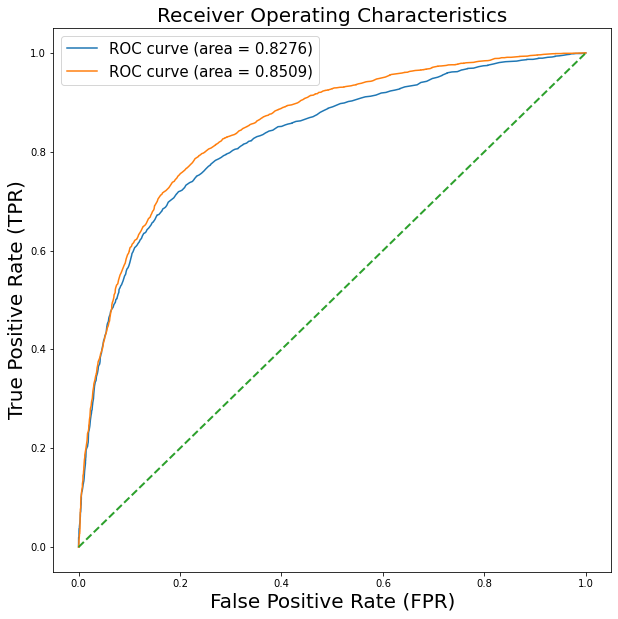

In [206]:
# Retrain best RandomForest(RF) model to evaluate it using other performance metrics
best_rf_param = random_oversampling_mean_rf.best_params_

# Create a new RandomForest(RF) classifier with the best hyperparameter found
best_criterion = best_rf_param['criterion']
best_max_depth = best_rf_param['max_depth']
best_max_features = best_rf_param['max_features']
best_n_estimators = best_rf_param['n_estimators']

best_rf_model = RandomForestClassifier(n_estimators=best_n_estimators, criterion=best_criterion, 
                                       max_features=best_max_features, max_depth=best_max_depth, 
                                       random_state=42)

# Fit the best RandomForest(RF) model on the training data
best_rf_model.fit(x_train_mean_oversample, y_train_mean_oversample)

# Use the best RandomForest(RF) model for prediction and evaluate its performance
make_pred(best_rf_model, x_test_mean, y_test_mean, rf=True)

### CatBoost Algorithm
This section is written by Clarine.

In [57]:
# Function to build and train CatBoost with hyperparameter tuning using grid search
def catboost(df_x, df_y):
    # Create Cat Boost classifier instance
    catBoost = CatBoostClassifier(loss_function='MultiLogloss',
                                  verbose=False,
                                  random_seed=42)
    
    # Data pool
    train_pool = Pool(df_x, df_y)
    
    # Hyperparameter grid for grid search
    grid = {'iterations': [1000, 1500],
            'learning_rate': [0.05, 0.1],
            'depth': [6, 10],
            'l2_leaf_reg': [0.3, 0.5]}
    
    # Perform grid search to find the best hyperparameter combination
    grid_result = catBoost.grid_search(grid, train_pool, cv=5, verbose=False)
    return grid_result

In [80]:
# CatBoost with mean imputation and random oversampling
catboost_mean_oversample = catboost(x_train_mean_oversample, y_train_mean_oversample)

# Evaluate the model performance
print('\033[1mCatBoost with Mean Imputation and Random Oversampling\033[0m')

# Display best hyperparameter
print('\033[3mBest hyperparameter\033[0m')
best_param_catboost_mean_oversample = catboost_mean_oversample['params']
print(best_param_catboost_mean_oversample)
print()

# Display best MultiLogloss score
print('\033[3mBest MultiLogloss score\033[0m')
best_score_catboost_mean_oversample = min(catboost_mean_oversample['cv_results']['test-MultiLogloss-mean'])
print(best_score_catboost_mean_oversample)

CatBoost with Mean Imputation and Random Oversampling
Best hyperparameter
{'depth': 10, 'iterations': 1000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.3}

Best MultiLogloss score
0.17096648724749325


In [81]:
# CatBoost with median imputation and random oversampling
catboost_median_oversample = catboost(x_train_median_oversample, y_train_median_oversample)

# Evaluate the model performance
print('\033[1mCatBoost with Median Imputation and Random Oversampling\033[0m')

# Display best hyperparameter
print('\033[3mBest hyperparameter\033[0m')
best_param_catboost_median_oversample = catboost_median_oversample['params']
print(best_param_catboost_median_oversample)
print()

# Display best MultiLogloss score
print('\033[3mBest MultiLogloss score\033[0m')
best_score_catboost_median_oversample = min(catboost_median_oversample['cv_results']['test-MultiLogloss-mean'])
print(best_score_catboost_median_oversample)


bestTest = 0.317102866
bestIteration = 999


bestTest = 0.2617212868
bestIteration = 999


bestTest = 0.3198210595
bestIteration = 999


bestTest = 0.2650699606
bestIteration = 999


bestTest = 0.2830606004
bestIteration = 1499


bestTest = 0.2343592485
bestIteration = 1499


bestTest = 0.2853837835
bestIteration = 1499


bestTest = 0.2374145419
bestIteration = 1499


bestTest = 0.1747635291
bestIteration = 896


bestTest = 0.182447806
bestIteration = 457


bestTest = 0.1759291514
bestIteration = 961


bestTest = 0.1789782719
bestIteration = 503


bestTest = 0.1747635291
bestIteration = 896


bestTest = 0.182447806
bestIteration = 457


bestTest = 0.1758769536
bestIteration = 1041


bestTest = 0.1789782719
bestIteration = 503

Training on fold [0/5]

bestTest = 0.169888983
bestIteration = 868

Training on fold [1/5]

bestTest = 0.166872703
bestIteration = 977

Training on fold [2/5]

bestTest = 0.1710966835
bestIteration = 936

Training on fold [3/5]

bestTest = 0.1739339874
bestItera

In [58]:
# CatBoost with mean imputation and SMOTEENN
catboost_mean_smoteenn = catboost(x_train_mean_smoteenn, y_train_mean_smoteenn)

# Evaluate the model performance
print('\033[1mCatBoost with Mean Imputation and SMOTEENN\033[0m')

# Display best hyperparameter
print('\033[3mBest hyperparameter\033[0m')
best_param_catboost_mean_smoteenn = catboost_mean_smoteenn['params']
print(best_param_catboost_mean_smoteenn)
print()

# Display best MultiLogloss score
print('\033[3mBest MultiLogloss score\033[0m')
best_score_catboost_mean_smoteenn = min(catboost_mean_smoteenn['cv_results']['test-MultiLogloss-mean'])
print(best_score_catboost_mean_smoteenn)


bestTest = 0.161509073
bestIteration = 999


bestTest = 0.1220595657
bestIteration = 997


bestTest = 0.1636240932
bestIteration = 999


bestTest = 0.1229343185
bestIteration = 999


bestTest = 0.136137092
bestIteration = 1499


bestTest = 0.1118166009
bestIteration = 1479


bestTest = 0.137580866
bestIteration = 1499


bestTest = 0.1109545072
bestIteration = 1499


bestTest = 0.09941567906
bestIteration = 777


bestTest = 0.1012104556
bestIteration = 391


bestTest = 0.09928378581
bestIteration = 817


bestTest = 0.1027006008
bestIteration = 429


bestTest = 0.09941567906
bestIteration = 777


bestTest = 0.1012104556
bestIteration = 391


bestTest = 0.09928378581
bestIteration = 817


bestTest = 0.1027006008
bestIteration = 429

Training on fold [0/5]

bestTest = 0.0860073024
bestIteration = 938

Training on fold [1/5]

bestTest = 0.07637018186
bestIteration = 996

Training on fold [2/5]

bestTest = 0.08286951216
bestIteration = 956

Training on fold [3/5]

bestTest = 0.08806075729
b

In [59]:
# CatBoost with median imputation and SMOTEENN
catboost_median_smoteenn = catboost(x_train_median_smoteenn, y_train_median_smoteenn)

# Evaluate the model performance
print('\033[1mCatBoost with Median Imputation and SMOTEENN\033[0m')

# Display best hyperparameter
print('\033[3mBest hyperparameter\033[0m')
best_param_catboost_median_smoteenn = catboost_median_smoteenn['params']
print(best_param_catboost_median_smoteenn)
print()

# Display best MultiLogloss score
print('\033[3mBest MultiLogloss score\033[0m')
best_score_catboost_median_smoteenn = min(catboost_median_smoteenn['cv_results']['test-MultiLogloss-mean'])
print(best_score_catboost_median_smoteenn)


bestTest = 0.1511873423
bestIteration = 999


bestTest = 0.1138559829
bestIteration = 999


bestTest = 0.1536940538
bestIteration = 999


bestTest = 0.1157661094
bestIteration = 998


bestTest = 0.1260749092
bestIteration = 1499


bestTest = 0.09872085162
bestIteration = 1491


bestTest = 0.1278566249
bestIteration = 1499


bestTest = 0.1010360291
bestIteration = 1493


bestTest = 0.08093038378
bestIteration = 999


bestTest = 0.08485471559
bestIteration = 570


bestTest = 0.08072280966
bestIteration = 995


bestTest = 0.08231791719
bestIteration = 680


bestTest = 0.08064367339
bestIteration = 1157


bestTest = 0.08485471559
bestIteration = 570


bestTest = 0.0804244061
bestIteration = 1079


bestTest = 0.08231791719
bestIteration = 680

Training on fold [0/5]

bestTest = 0.08874911463
bestIteration = 974

Training on fold [1/5]

bestTest = 0.08303942914
bestIteration = 1323

Training on fold [2/5]

bestTest = 0.08901875526
bestIteration = 902

Training on fold [3/5]

bestTest = 0.08

In [208]:
# CatBoost with mean imputation and no resampling
catboost_mean = catboost(x_train_mean, y_train_mean)

# Evaluate the model performance
print('\033[1mCatBoost with Mean Imputation and No Resampling\033[0m')

# Display best hyperparameter
print('\033[3mBest hyperparameter\033[0m')
best_param_catboost_mean = catboost_mean['params']
print(best_param_catboost_mean)
print()

# Display best MultiLogloss score
print('\033[3mBest MultiLogloss score\033[0m')
best_score_catboost_mean = min(catboost_mean['cv_results']['test-MultiLogloss-mean'])
print(best_score_catboost_mean)

CatBoost with Mean Imputation and No Resampling
Best hyperparameter
{'depth': 6, 'iterations': 1000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.5}

Best MultiLogloss score
0.42076773888168945


In [209]:
# CatBoost with median imputation and no resampling
catboost_median = catboost(x_train_median, y_train_median)

# Evaluate the model performance
print('\033[1mCatBoost with Median Imputation and No Resampling\033[0m')

# Display best hyperparameter
print('\033[3mBest hyperparameter\033[0m')
best_param_catboost_median = catboost_median['params']
print(best_param_catboost_median)
print()

# Display best MultiLogloss score
print('\033[3mBest MultiLogloss score\033[0m')
best_score_catboost_median = min(catboost_median['cv_results']['test-MultiLogloss-mean'])
print(best_score_catboost_median)

CatBoost with Mean Imputation and No Resampling
Best hyperparameter
{'depth': 6, 'iterations': 1000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.3}

Best MultiLogloss score
0.4211081941960573


**Best CatBoost Model**
1. Median imputation
2. SMOTEENN resampling

*Best hyperparameters:*<br>
{'depth': 10, 'iterations': 1500, 'learning_rate': 0.05, 'l2_leaf_reg': 0.5}<br>

*Best MultiLogloss score:*
0.08523723143324502

Evaluation metrics
Accuracy: 0.5585460948308388
Accuracy for h1n1_vaccine: 0.7337441831216199
Accuracy for seasonal_vaccine: 0.7212929191296692
Hamming loss: 0.27248144887435544
Micro F1 score: 0.6789181178214153
Weighted F1 score: 0.6858631263925578

AUROC for h1n1_vaccine:  0.8133022649382177
AUROC for seasonal_vaccine:  0.8409824896355752
Combined AUROC:  0.8271423772868964



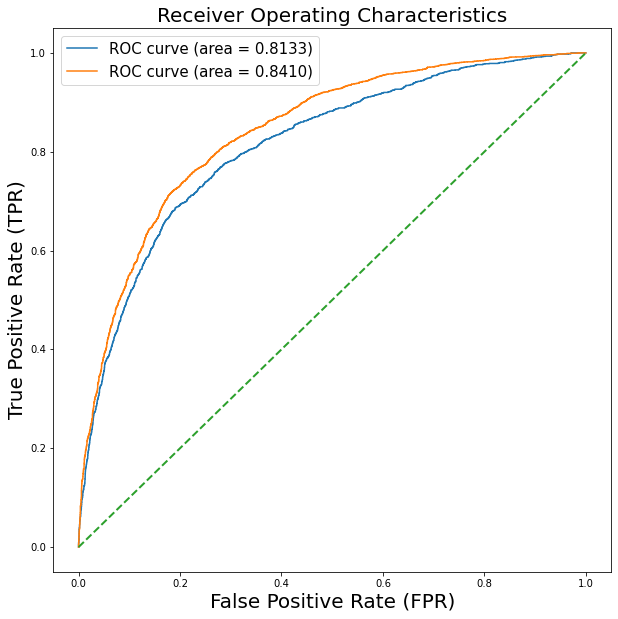

In [210]:
# Retrain best CatBoost model to evaluate it using other performance metrics
best_catboost_param = best_param_catboost_median_smoteenn

# Create a new CatBoost classifier with the best hyperparameter found
best_catboost = CatBoostClassifier(loss_function='MultiLogloss',
                                   **best_catboost_param,
                                   verbose=False,
                                   random_seed=42)

# Fit the best CatBoost model on the training data
best_catboost.fit(x_train_median_smoteenn, y_train_median_smoteenn)

# Use the best CatBoost model for prediction and evaluate its performance
make_pred(best_catboost, x_test_median, y_test_median)